In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/EECE693_Project")


In [2]:
BASE_DIR = "/content/drive/MyDrive/EECE693_Project/Preprocessed_HICMA"

TRAIN_DIR = f"{BASE_DIR}/train/images"
VAL_DIR   = f"{BASE_DIR}/val/images"
TEST_DIR  = f"{BASE_DIR}/test/images"

TRAIN_LABELS = f"{BASE_DIR}/train_labels.csv"
VAL_LABELS   = f"{BASE_DIR}/val_labels.csv"
TEST_LABELS  = f"{BASE_DIR}/test_labels.csv"

In [3]:
import pandas as pd

df_train = pd.read_csv(TRAIN_LABELS)
df_val   = pd.read_csv(VAL_LABELS)
df_test  = pd.read_csv(TEST_LABELS)

In [4]:
df_train.head()


img_name    class  \
0                                     901-3.png    Naskh   
1         Al-Haj-22-38-Thuluth_segment_no_2.png  Thuluth   
2                                     296-2.png    Naskh   
3  Al-Mumtahanah-60-4-Diwani-1_segment_no_0.png   Diwani   
4                     Al-Sharh_segment_no_4.png    Naskh   

                                               label source_set  height  width  
0  يومئذ تعرضون لا تخفى منكم خافية فأما من أوتي ك...       Set2     256   4000  
1                     ان الله يدافع عن الذين ءامنوا        Set1     256    640  
2      لذلك العبد و الأمة ما شاء الله و قال صلى الله       Set3     256   1696  
3          ربنا عليك توكلنا وإليك أنبنا وإليك المصير       Set1     256    960  
4                         فرغت فانصب  وإلى ربك فارغب       Set1     256   1888

In [6]:
# Normalize labels
for df_ in [df_train, df_val, df_test]:
    df_["label"] = df_["label"].astype(str).apply(normalize_label)

NameError: name 'normalize_label' is not defined

In [19]:
# %% FULL OCR TRAINING SCRIPT FOR Preprocessed_HICMA DATASET

# ====================== Setup ======================
import os, time, random, unicodedata, gc
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
import albumentations as A
from torchvision import models
from tqdm.auto import tqdm

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

def human(n): return f"{n:,}"

def autocast_cuda():
    return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        t = torch.cuda.get_device_properties(0).total_memory/1e9
        return f"GPU: {a:.2f}/{r:.2f}/{t:.1f}GB"
    return "CPU"

# ====================== Data Paths ======================
BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Preprocessed_HICMA")

TRAIN_DIR = BASE_DIR / "train/images"
VAL_DIR   = BASE_DIR / "val/images"
TEST_DIR  = BASE_DIR / "test/images"

TRAIN_LABELS = BASE_DIR / "train_labels.csv"
VAL_LABELS   = BASE_DIR / "val_labels.csv"
TEST_LABELS  = BASE_DIR / "test_labels.csv"

assert TRAIN_LABELS.exists() and VAL_LABELS.exists() and TEST_LABELS.exists(), "Label CSVs not found!"

# ====================== Load CSVs & Normalize ======================
def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df_train = pd.read_csv(TRAIN_LABELS)
df_val   = pd.read_csv(VAL_LABELS)
df_test  = pd.read_csv(TEST_LABELS)

for df in [df_train, df_val, df_test]:
    df['label'] = df['label'].astype(str).apply(normalize_label)
    df['img_path'] = df['img_name'].apply(lambda x: str((TRAIN_DIR if 'train' in df.columns else VAL_DIR) / x))

# ====================== Charset ======================
all_labels = pd.concat([df_train['label'], df_val['label'], df_test['label']])
char_counts = Counter()
for s in all_labels:
    for ch in s:
        char_counts[ch] += 1

charset = ['<BLANK>'] + sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
char2idx = {c: i for i, c in enumerate(charset)}
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
print(f"Charset size: {len(charset)}")

# ====================== Style Classes ======================
all_classes = pd.concat([df_train['class'], df_val['class'], df_test['class']]).fillna("Unknown")
style_names = sorted(all_classes.unique())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}

# ====================== Label Encoding ======================
RTL_REVERSE = True
def encode_label(text, rtl_reverse=True):
    if rtl_reverse: text = text[::-1]
    return [char2idx[ch] for ch in text if ch in char2idx and ch != '<BLANK>']

for df in [df_train, df_val, df_test]:
    df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
    df = df[df['enc_len'] > 0].reset_index(drop=True)

# ====================== Image Processing ======================
H_TARGET = 64
W_MAX = 512
MEAN, STD = 0.5, 0.5
MIN_PX_PER_CHAR = 8

def decode_pred(indices, rtl_reverse=RTL_REVERSE):
    res, prev = [], None
    for idx in indices:
        if idx != BLANK_IDX and idx != prev:
            res.append(idx2char[idx])
        prev = idx
    s = "".join(res)
    return s[::-1] if rtl_reverse else s

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def pad_width_to_multiple(img, multiple=4, pad_value=255):
    h, w = img.shape
    pad_w = (multiple - (w % multiple)) % multiple
    if pad_w == 0: return img
    return cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=pad_value)

# ====================== Augmentations ======================
AUG_P = 0.35
train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.MotionBlur(blur_limit=3, p=AUG_P*0.7),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
    A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.02, rotate_limit=3, border_mode=cv2.BORDER_REPLICATE, p=AUG_P*0.8),
    A.CoarseDropout(max_holes=3, max_height=8, max_width=20, fill_value=255, p=AUG_P*0.5),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P*0.8)
])

def stroke_thickness_jitter(img, p=0.4):
    if random.random() > p: return img
    k = random.choice([1,1,2])
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*k+1,2*k+1))
    return cv2.erode(img, kernel) if random.random()<0.5 else cv2.dilate(img, kernel)

def cutout_stripes(img, p=0.25):
    if random.random() > p: return img
    h,w = img.shape
    n = random.randint(1,2)
    for _ in range(n):
        stripe_w = max(2,int(random.random()*max(3,w*0.1)))
        x0 = random.randint(0,max(0,w-stripe_w))
        img[:,x0:x0+stripe_w] = 255
    return img

def apply_train_aug(img):
    img = stroke_thickness_jitter(img)
    img = cutout_stripes(img)
    return train_aug(image=img)['image']

# ====================== Dataset ======================
class OCRDataset(Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.training = training
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.ones((H_TARGET,64),dtype=np.uint8)*255
        label_ids = encode_label(row['label'])
        style_idx = style2idx[row['class']]
        img = resize_keep_ar_enforced(img,H_TARGET,label_len=len(label_ids))

        # >>> INSERT HERE <<<
        MAX_WIDTH = 600
        if img.shape[1] > MAX_WIDTH:
          img = cv2.resize(img, (MAX_WIDTH, H_TARGET), interpolation=cv2.INTER_AREA)

        if self.training: img = apply_train_aug(img)
        img = pad_width_to_multiple(img)
        img = (img.astype(np.float32)/255.0 - MEAN)/STD
        img_t = torch.from_numpy(img)[None,...]
        return img_t, torch.tensor(label_ids,dtype=torch.long), row['label'], torch.tensor(style_idx), row['class'], img_t.shape[-1]

def collate_fn(batch):
    batch = sorted(batch,key=lambda x:x[-1],reverse=True)
    imgs, labels, label_strs, style_idxs, style_names_b, widths = zip(*batch)
    max_w = max(widths)
    bsz = len(imgs)
    padded = torch.full((bsz,1,H_TARGET,max_w),(0.0-MEAN)/STD,dtype=torch.float32)
    for i,im in enumerate(imgs):
        w = im.shape[-1]
        padded[i,:,:, :w] = im
    label_lens = torch.tensor([len(l) for l in labels],dtype=torch.long)
    labels_concat = torch.cat(labels,dim=0) if len(labels) else torch.tensor([],dtype=torch.long)
    return padded, labels_concat, label_lens, label_strs, torch.stack(style_idxs), style_names_b, torch.tensor(widths,dtype=torch.long)

# ====================== Model ======================
try: _IMAGENET_WEIGHTS = models.ResNet34_Weights.IMAGENET1K_V1
except: _IMAGENET_WEIGHTS = "IMAGENET1K_V1"

class ResNet34OCRBackbone(nn.Module):
    def __init__(self,in_ch=1):
        super().__init__()
        try: m=models.resnet34(weights=_IMAGENET_WEIGHTS)
        except: m=models.resnet34(pretrained=True)
        w=m.conv1.weight.data
        new_w=w.mean(dim=1,keepdim=True)
        m.conv1 = nn.Conv2d(in_ch,64,kernel_size=7,stride=(2,1),padding=3,bias=False)
        with torch.no_grad(): m.conv1.weight.copy_(new_w)
        m.maxpool = nn.MaxPool2d(3,stride=(2,1),padding=1)
        self.stem = nn.Sequential(m.conv1,m.bn1,m.relu,m.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = m.layer1, m.layer2, m.layer3, m.layer4
        self.out = nn.AdaptiveAvgPool2d((1,None))
    def forward(self,x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        fmap = x
        seq = self.out(fmap).squeeze(2).permute(2,0,1)
        return seq,fmap

class TemporalGLUBlock(nn.Module):
    def __init__(self,c=512,k=5,dilation=1,p=0.1):
        super().__init__()
        pad = (k-1)//2*dilation
        self.conv=nn.Conv1d(c,2*c,kernel_size=k,padding=pad,dilation=dilation)
        self.glu = nn.GLU(dim=1)
        self.drop=nn.Dropout(p)
        self.res=nn.Conv1d(c,c,kernel_size=1)
    def forward(self,x):
        x = x.permute(1,2,0)
        y = self.glu(self.conv(x))
        y = self.drop(y)+self.res(x)
        return y.permute(2,0,1)

class BiLSTMStack(nn.Module):
    def __init__(self,in_dim,hidden=256,num_layers=2,dropout=0.25):
        super().__init__()
        layers=[]
        for i in range(num_layers):
            inp=in_dim if i==0 else hidden*2
            layers.append(nn.LSTM(inp,hidden,bidirectional=True,batch_first=False))
            layers.append(nn.Dropout(dropout))
        self.layers=nn.ModuleList(layers)
    def forward(self,x):
        for i in range(0,len(self.layers),2):
            x,_=self.layers[i](x)
            x=self.layers[i+1](x)
        return x

class OCR_MultiTask_V3(nn.Module):
    def __init__(self,num_chars,num_styles,blank_idx=0,aux_weight=0.3):
        super().__init__()
        self.backbone = ResNet34OCRBackbone()
        self.tcn1 = TemporalGLUBlock(512,5,1,0.1)
        self.tcn2 = TemporalGLUBlock(512,5,2,0.1)
        self.lstm = BiLSTMStack(512,256,2,0.25)
        self.ctc_head_main = nn.Linear(512,num_chars)
        self.ctc_head_aux = nn.Linear(512,num_chars)
        self.style_head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),
                                        nn.Dropout(0.25),
                                        nn.Linear(512,max(256,num_styles*4)), nn.ReLU(True),
                                        nn.Linear(max(256,num_styles*4),num_styles))
        self.blank_idx = blank_idx
        self.aux_weight = aux_weight
        with torch.no_grad():
            self.ctc_head_main.bias.zero_(); self.ctc_head_main.bias[blank_idx]=-2.0
            self.ctc_head_aux.bias.zero_(); self.ctc_head_aux.bias[blank_idx]=-2.0
    def forward(self,x):
        seq,fmap=self.backbone(x)
        tcn_out=self.tcn2(self.tcn1(seq))
        lstm_out=self.lstm(tcn_out)
        ctc_logits_main=self.ctc_head_main(lstm_out)
        ctc_logits_aux=self.ctc_head_aux(tcn_out)
        style_logits=self.style_head(fmap.detach())
        return ctc_logits_main,ctc_logits_aux,style_logits

# ====================== Dataloaders ======================
BATCH_SIZE=32
train_ds = OCRDataset(df_train,training=True)
val_ds   = OCRDataset(df_val,training=False)
test_ds  = OCRDataset(df_test,training=False)

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4)
val_loader   = DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)
test_loader  = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)

# ====================== Loss & Optimizer ======================
num_chars = len(charset)
num_styles = len(style_names)
model = OCR_MultiTask_V3(num_chars,num_styles,blank_idx=BLANK_IDX).to(DEVICE)

ctc_loss_fn = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True)
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=50,eta_min=1e-6)
scaler = torch.amp.GradScaler(enabled=(DEVICE=="cuda"))

# ====================== Training & Evaluation Functions ======================
def ctc_time_lengths(widths):
    return torch.clamp(widths // 4, min=1, max=64)

def greedy_decode_ctc(logits,widths):
    max_idxs=logits.softmax(-1).argmax(-1)
    T,B = max_idxs.shape
    res=[]
    for b in range(B):
        L=int(widths[b])
        seq=max_idxs[:L,b].tolist()
        res.append(decode_pred(seq))
    return res

@torch.no_grad()
def evaluate(model,loader):
    model.eval(); tot_loss=tot_cer=tot_wer=0; cnt=0; cls_correct=cls_total=0
    for imgs,labels_concat,label_lens,label_strs,style_idxs,style_names_b,widths in loader:
        imgs,style_idxs,label_lens = imgs.to(DEVICE),style_idxs.to(DEVICE),label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)
        ctc_logits_main,ctc_logits_aux,style_logits=model(imgs)
        log_probs_main=ctc_logits_main.log_softmax(2)
        input_lens = torch.clamp(widths.to(DEVICE) // 4, min=1)
        loss_ctc = ctc_loss_fn(log_probs_main.float(),labels_concat.to(DEVICE),input_lens,label_lens) if len(labels_concat)>0 else 0
        loss_cls = cls_loss_fn(style_logits, style_idxs)
        loss = loss_ctc + 0.2*loss_cls
        tot_loss += loss.item()*imgs.size(0); cnt+=imgs.size(0)
        preds=greedy_decode_ctc(ctc_logits_main,widths)
        for gt,pr in zip(label_strs,preds):
            tot_cer += editdistance.eval(gt,pr)/max(1,len(gt))
            tot_wer += editdistance.eval(gt.split(),pr.split())/max(1,len(gt.split()))
        cls_correct += (style_logits.argmax(1)==style_idxs).sum().item()
        cls_total += imgs.size(0)
    return {"loss":tot_loss/cnt,"cer":tot_cer/cnt,"wer":tot_wer/cnt,"style_acc":cls_correct/cls_total}

# ====================== TRAINING LOOP ======================
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0
    seen = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}")

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        label_lens = label_lens.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)

            # Fix: input lengths must match the time dimension (T) of the model output
            T = log_probs_main.size(0)  # sequence length
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens) if len(labels_concat) > 0 else 0
            loss_cls = cls_loss_fn(style_logits, style_idxs)
            loss = loss_ctc + 0.2 * loss_cls

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix({"train_loss": running / seen})

    scheduler.step()

    val_metrics = evaluate(model, val_loader)
    print(f"VAL Epoch {epoch}: Loss {val_metrics['loss']:.4f}, CER {val_metrics['cer']:.3f}, "
          f"WER {val_metrics['wer']:.3f}, StyleAcc {val_metrics['style_acc']:.3f}")

# ====================== TEST ======================
test_metrics = evaluate(model, test_loader)
print("TEST:", test_metrics)



Device: cuda
Charset size: 49


/tmp/ipython-input-438537127.py:133: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
/tmp/ipython-input-438537127.py:135: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
/tmp/ipython-input-438537127.py:136: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-438537127.py:138: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=8, m

Epoch 01:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 1: Loss 3.2408, CER 0.931, WER 0.997, StyleAcc 0.799


Epoch 02:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 2: Loss 3.2329, CER 0.910, WER 1.000, StyleAcc 0.789


Epoch 03:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 3: Loss 3.1534, CER 0.892, WER 0.990, StyleAcc 0.809


Epoch 04:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 4: Loss 3.1783, CER 0.747, WER 1.398, StyleAcc 0.809


Epoch 05:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 5: Loss 3.2207, CER 0.714, WER 1.388, StyleAcc 0.783


Epoch 06:   0%|          | 0/126 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

VAL Epoch 6: Loss 3.2171, CER 0.720, WER 1.461, StyleAcc 0.757


Epoch 07:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 7: Loss 3.9753, CER 0.978, WER 1.900, StyleAcc 0.741


Epoch 08:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 8: Loss 3.1704, CER 0.943, WER 1.000, StyleAcc 0.743


Epoch 09:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 9: Loss 3.1823, CER 0.812, WER 0.977, StyleAcc 0.743


Epoch 10:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 10: Loss 3.1994, CER 0.976, WER 1.000, StyleAcc 0.367
TEST: {'loss': 3.11879675051801, 'cer': 0.9761866641720668, 'wer': 1.0, 'style_acc': 0.7435387673956262}


Device: cuda
Charset size: 49


/tmp/ipython-input-2585713651.py:133: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
/tmp/ipython-input-2585713651.py:135: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
/tmp/ipython-input-2585713651.py:136: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2585713651.py:138: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=

Epoch 01:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 1: Loss 3.2177, CER 0.9308, WER 0.9923, StyleAcc 0.8108


Epoch 02:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 2: Loss 3.3168, CER 0.9244, WER 0.9866, StyleAcc 0.7191


Epoch 03:   0%|          | 0/126 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

VAL Epoch 3: Loss 3.2136, CER 0.9093, WER 0.9829, StyleAcc 0.8028


Epoch 04:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 4: Loss 3.2202, CER 0.9076, WER 0.9918, StyleAcc 0.8088


Epoch 05:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 5: Loss 3.1651, CER 0.8926, WER 0.9993, StyleAcc 0.8127


Epoch 06:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 6: Loss 3.0917, CER 0.7168, WER 1.1704, StyleAcc 0.7928


Epoch 07:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 7: Loss 3.2544, CER 0.7039, WER 1.5880, StyleAcc 0.4462


Epoch 08:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 8: Loss 3.3255, CER 0.9263, WER 1.0040, StyleAcc 0.7430


Epoch 09:   0%|          | 0/126 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

VAL Epoch 9: Loss 3.3424, CER 0.8379, WER 1.0573, StyleAcc 0.7331


Epoch 10:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 10: Loss 3.1560, CER 0.8736, WER 0.9972, StyleAcc 0.7430


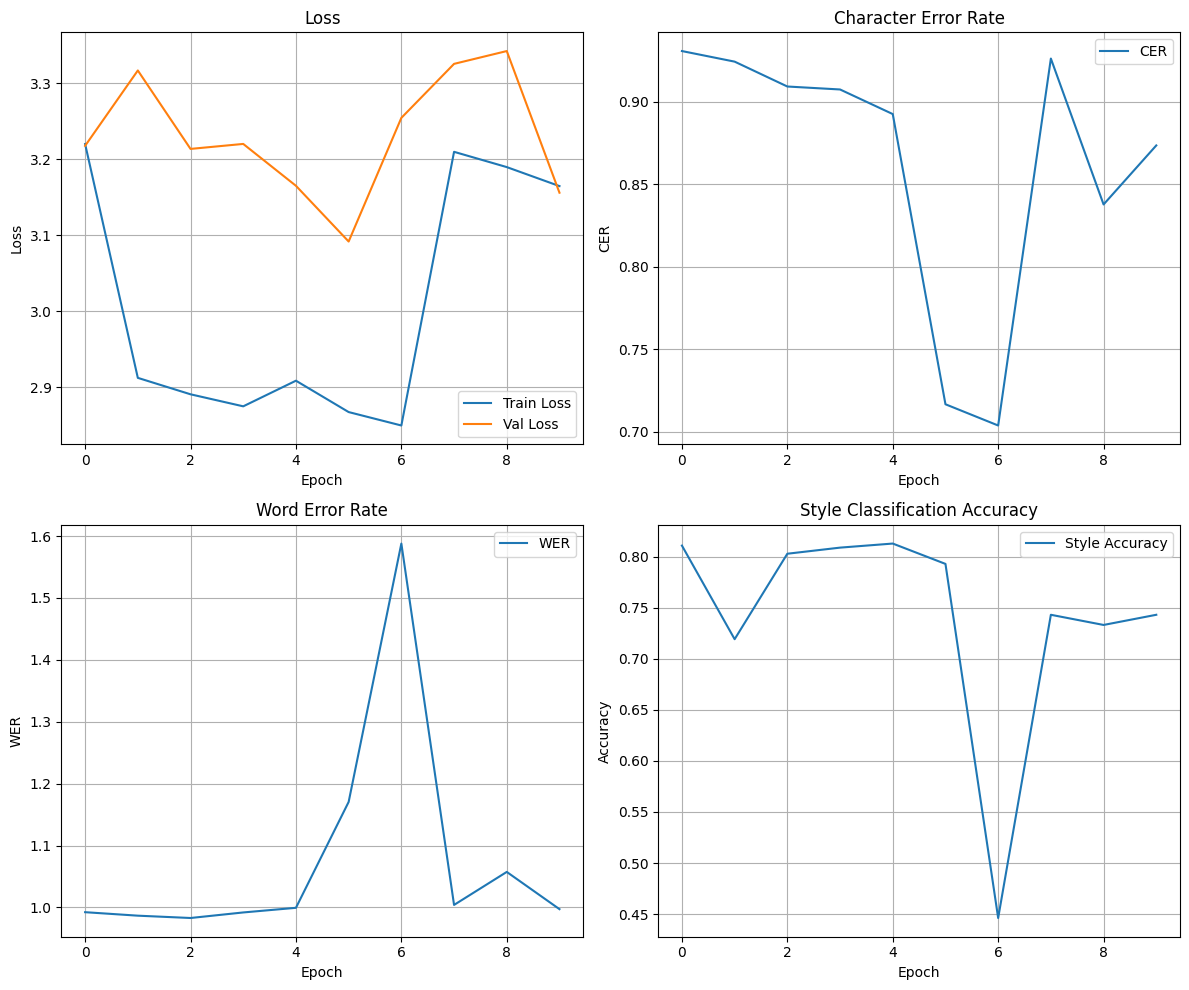


TEST METRICS — Loss: 3.0605, CER: 0.9762, WER: 1.0000, StyleAcc: 0.7435


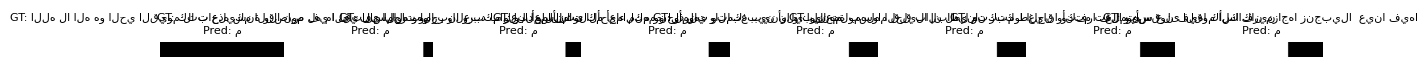

In [12]:
# %% FULL OCR TRAINING SCRIPT FOR Preprocessed_HICMA DATASET

# ====================== Setup ======================
import os, time, random, unicodedata, gc
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
import albumentations as A
from torchvision import models
from tqdm.auto import tqdm

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

def human(n): return f"{n:,}"

def autocast_cuda():
    return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        t = torch.cuda.get_device_properties(0).total_memory/1e9
        return f"GPU: {a:.2f}/{r:.2f}/{t:.1f}GB"
    return "CPU"

# ====================== Data Paths ======================
BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Preprocessed_HICMA")

TRAIN_DIR = BASE_DIR / "train/images"
VAL_DIR   = BASE_DIR / "val/images"
TEST_DIR  = BASE_DIR / "test/images"

TRAIN_LABELS = BASE_DIR / "train_labels.csv"
VAL_LABELS   = BASE_DIR / "val_labels.csv"
TEST_LABELS  = BASE_DIR / "test_labels.csv"

assert TRAIN_LABELS.exists() and VAL_LABELS.exists() and TEST_LABELS.exists(), "Label CSVs not found!"

# ====================== Load CSVs & Normalize ======================
def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df_train = pd.read_csv(TRAIN_LABELS)
df_val   = pd.read_csv(VAL_LABELS)
df_test  = pd.read_csv(TEST_LABELS)

for df in [df_train, df_val, df_test]:
    df['label'] = df['label'].astype(str).apply(normalize_label)
    df['img_path'] = df['img_name'].apply(lambda x: str((TRAIN_DIR if 'train' in df.columns else VAL_DIR) / x))

# ====================== Charset ======================
all_labels = pd.concat([df_train['label'], df_val['label'], df_test['label']])
char_counts = Counter()
for s in all_labels:
    for ch in s:
        char_counts[ch] += 1

charset = ['<BLANK>'] + sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
char2idx = {c: i for i, c in enumerate(charset)}
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
print(f"Charset size: {len(charset)}")

# ====================== Style Classes ======================
all_classes = pd.concat([df_train['class'], df_val['class'], df_test['class']]).fillna("Unknown")
style_names = sorted(all_classes.unique())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}

# ====================== Label Encoding ======================
RTL_REVERSE = True
def encode_label(text, rtl_reverse=True):
    if rtl_reverse: text = text[::-1]
    return [char2idx[ch] for ch in text if ch in char2idx and ch != '<BLANK>']

for df in [df_train, df_val, df_test]:
    df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
    df = df[df['enc_len'] > 0].reset_index(drop=True)

# ====================== Image Processing ======================
H_TARGET = 64
W_MAX = 512
MEAN, STD = 0.5, 0.5
MIN_PX_PER_CHAR = 8

def decode_pred(indices, rtl_reverse=RTL_REVERSE):
    res, prev = [], None
    for idx in indices:
        if idx != BLANK_IDX and idx != prev:
            res.append(idx2char[idx])
        prev = idx
    s = "".join(res)
    return s[::-1] if rtl_reverse else s

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def pad_width_to_multiple(img, multiple=4, pad_value=255):
    h, w = img.shape
    pad_w = (multiple - (w % multiple)) % multiple
    if pad_w == 0: return img
    return cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=pad_value)

# ====================== Augmentations ======================
AUG_P = 0.35
train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.MotionBlur(blur_limit=3, p=AUG_P*0.7),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
    A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.02, rotate_limit=3, border_mode=cv2.BORDER_REPLICATE, p=AUG_P*0.8),
    A.CoarseDropout(max_holes=3, max_height=8, max_width=20, fill_value=255, p=AUG_P*0.5),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P*0.8)
])

def stroke_thickness_jitter(img, p=0.4):
    if random.random() > p: return img
    k = random.choice([1,1,2])
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*k+1,2*k+1))
    return cv2.erode(img, kernel) if random.random()<0.5 else cv2.dilate(img, kernel)

def cutout_stripes(img, p=0.25):
    if random.random() > p: return img
    h,w = img.shape
    n = random.randint(1,2)
    for _ in range(n):
        stripe_w = max(2,int(random.random()*max(3,w*0.1)))
        x0 = random.randint(0,max(0,w-stripe_w))
        img[:,x0:x0+stripe_w] = 255
    return img

def apply_train_aug(img):
    img = stroke_thickness_jitter(img)
    img = cutout_stripes(img)
    return train_aug(image=img)['image']

# ====================== Dataset ======================
class OCRDataset(Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.training = training
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.ones((H_TARGET,64),dtype=np.uint8)*255
        label_ids = encode_label(row['label'])
        style_idx = style2idx[row['class']]
        img = resize_keep_ar_enforced(img,H_TARGET,label_len=len(label_ids))
        if self.training: img = apply_train_aug(img)
        img = pad_width_to_multiple(img)
        img = (img.astype(np.float32)/255.0 - MEAN)/STD
        img_t = torch.from_numpy(img)[None,...]
        return img_t, torch.tensor(label_ids,dtype=torch.long), row['label'], torch.tensor(style_idx), row['class'], img_t.shape[-1]

def collate_fn(batch):
    batch = sorted(batch,key=lambda x:x[-1],reverse=True)
    imgs, labels, label_strs, style_idxs, style_names_b, widths = zip(*batch)
    max_w = max(widths)
    bsz = len(imgs)
    padded = torch.full((bsz,1,H_TARGET,max_w),(0.0-MEAN)/STD,dtype=torch.float32)
    for i,im in enumerate(imgs):
        w = im.shape[-1]
        padded[i,:,:, :w] = im
    label_lens = torch.tensor([len(l) for l in labels],dtype=torch.long)
    labels_concat = torch.cat(labels,dim=0) if len(labels) else torch.tensor([],dtype=torch.long)
    return padded, labels_concat, label_lens, label_strs, torch.stack(style_idxs), style_names_b, torch.tensor(widths,dtype=torch.long)

# ====================== Model ======================
try: _IMAGENET_WEIGHTS = models.ResNet34_Weights.IMAGENET1K_V1
except: _IMAGENET_WEIGHTS = "IMAGENET1K_V1"

class ResNet34OCRBackbone(nn.Module):
    def __init__(self,in_ch=1):
        super().__init__()
        try: m=models.resnet34(weights=_IMAGENET_WEIGHTS)
        except: m=models.resnet34(pretrained=True)
        w=m.conv1.weight.data
        new_w=w.mean(dim=1,keepdim=True)
        m.conv1 = nn.Conv2d(in_ch,64,kernel_size=7,stride=(2,1),padding=3,bias=False)
        with torch.no_grad(): m.conv1.weight.copy_(new_w)
        m.maxpool = nn.MaxPool2d(3,stride=(2,1),padding=1)
        self.stem = nn.Sequential(m.conv1,m.bn1,m.relu,m.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = m.layer1, m.layer2, m.layer3, m.layer4
        self.out = nn.AdaptiveAvgPool2d((1,None))
    def forward(self,x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        fmap = x
        seq = self.out(fmap).squeeze(2).permute(2,0,1)
        return seq,fmap

class TemporalGLUBlock(nn.Module):
    def __init__(self,c=512,k=5,dilation=1,p=0.1):
        super().__init__()
        pad = (k-1)//2*dilation
        self.conv=nn.Conv1d(c,2*c,kernel_size=k,padding=pad,dilation=dilation)
        self.glu = nn.GLU(dim=1)
        self.drop=nn.Dropout(p)
        self.res=nn.Conv1d(c,c,kernel_size=1)
    def forward(self,x):
        x = x.permute(1,2,0)
        y = self.glu(self.conv(x))
        y = self.drop(y)+self.res(x)
        return y.permute(2,0,1)

class BiLSTMStack(nn.Module):
    def __init__(self,in_dim,hidden=256,num_layers=2,dropout=0.25):
        super().__init__()
        layers=[]
        for i in range(num_layers):
            inp=in_dim if i==0 else hidden*2
            layers.append(nn.LSTM(inp,hidden,bidirectional=True,batch_first=False))
            layers.append(nn.Dropout(dropout))
        self.layers=nn.ModuleList(layers)
    def forward(self,x):
        for i in range(0,len(self.layers),2):
            x,_=self.layers[i](x)
            x=self.layers[i+1](x)
        return x

class OCR_MultiTask_V3(nn.Module):
    def __init__(self,num_chars,num_styles,blank_idx=0,aux_weight=0.3):
        super().__init__()
        self.backbone = ResNet34OCRBackbone()
        self.tcn1 = TemporalGLUBlock(512,5,1,0.1)
        self.tcn2 = TemporalGLUBlock(512,5,2,0.1)
        self.lstm = BiLSTMStack(512,256,2,0.25)
        self.ctc_head_main = nn.Linear(512,num_chars)
        self.ctc_head_aux = nn.Linear(512,num_chars)
        self.style_head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),
                                        nn.Dropout(0.25),
                                        nn.Linear(512,max(256,num_styles*4)), nn.ReLU(True),
                                        nn.Linear(max(256,num_styles*4),num_styles))
        self.blank_idx = blank_idx
        self.aux_weight = aux_weight
        with torch.no_grad():
            self.ctc_head_main.bias.zero_(); self.ctc_head_main.bias[blank_idx]=-2.0
            self.ctc_head_aux.bias.zero_(); self.ctc_head_aux.bias[blank_idx]=-2.0
    def forward(self,x):
        seq,fmap=self.backbone(x)
        tcn_out=self.tcn2(self.tcn1(seq))
        lstm_out=self.lstm(tcn_out)
        ctc_logits_main=self.ctc_head_main(lstm_out)
        ctc_logits_aux=self.ctc_head_aux(tcn_out)
        style_logits=self.style_head(fmap.detach())
        return ctc_logits_main,ctc_logits_aux,style_logits

# ====================== Dataloaders ======================
BATCH_SIZE=32
train_ds = OCRDataset(df_train,training=True)
val_ds   = OCRDataset(df_val,training=False)
test_ds  = OCRDataset(df_test,training=False)

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4)
val_loader   = DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)
test_loader  = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)

# ====================== Loss & Optimizer ======================
num_chars = len(charset)
num_styles = len(style_names)
model = OCR_MultiTask_V3(num_chars,num_styles,blank_idx=BLANK_IDX).to(DEVICE)

ctc_loss_fn = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True)
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=50,eta_min=1e-6)
scaler = torch.amp.GradScaler(enabled=(DEVICE=="cuda"))

# ====================== Training & Evaluation Functions ======================
def ctc_time_lengths(widths): return torch.clamp(widths,min=1)

def greedy_decode_ctc(logits,widths):
    max_idxs=logits.softmax(-1).argmax(-1)
    T,B = max_idxs.shape
    res=[]
    for b in range(B):
        L=int(widths[b])
        seq=max_idxs[:L,b].tolist()
        res.append(decode_pred(seq))
    return res

@torch.no_grad()
def evaluate(model,loader):
    model.eval(); tot_loss=tot_cer=tot_wer=0; cnt=0; cls_correct=cls_total=0
    for imgs,labels_concat,label_lens,label_strs,style_idxs,style_names_b,widths in loader:
        imgs,style_idxs,label_lens = imgs.to(DEVICE),style_idxs.to(DEVICE),label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)
        ctc_logits_main,ctc_logits_aux,style_logits=model(imgs)
        log_probs_main=ctc_logits_main.log_softmax(2)
        # Fix: input_lens must match sequence length of logits
        T = log_probs_main.size(0)  # time dimension
        input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)
        loss_ctc = ctc_loss_fn(log_probs_main.float(),labels_concat.to(DEVICE),input_lens,label_lens) if len(labels_concat)>0 else 0
        loss_cls = cls_loss_fn(style_logits, style_idxs)
        loss = loss_ctc + 0.2*loss_cls
        tot_loss += loss.item()*imgs.size(0); cnt+=imgs.size(0)
        preds=greedy_decode_ctc(ctc_logits_main,widths)
        for gt,pr in zip(label_strs,preds):
            tot_cer += editdistance.eval(gt,pr)/max(1,len(gt))
            tot_wer += editdistance.eval(gt.split(),pr.split())/max(1,len(gt.split()))
        cls_correct += (style_logits.argmax(1)==style_idxs).sum().item()
        cls_total += imgs.size(0)
    return {"loss":tot_loss/cnt,"cer":tot_cer/cnt,"wer":tot_wer/cnt,"style_acc":cls_correct/cls_total}

# ====================== TRAINING LOOP WITH HISTORY TRACKING ======================
EPOCHS = 10

# History dictionary to store metrics
history = {
    "train_loss": [],
    "val_loss": [],
    "val_cer": [],
    "val_wer": [],
    "val_style_acc": []
}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0
    seen = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}")

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        label_lens = label_lens.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)

            # Input lengths must match time dimension
            T = log_probs_main.size(0)
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens) if len(labels_concat) > 0 else 0
            loss_cls = cls_loss_fn(style_logits, style_idxs)
            loss = loss_ctc + 0.2 * loss_cls

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix({"train_loss": running / seen})

    # Step scheduler
    scheduler.step()

    # Epoch train loss
    train_loss_epoch = running / max(1, seen)
    history["train_loss"].append(train_loss_epoch)

    # Validation metrics
    val_metrics = evaluate(model, val_loader)
    print(f"VAL Epoch {epoch}: Loss {val_metrics['loss']:.4f}, CER {val_metrics['cer']:.4f}, "
          f"WER {val_metrics['wer']:.4f}, StyleAcc {val_metrics['style_acc']:.4f}")

    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

# ====================== PLOTTING TRAINING CURVES ======================
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history["val_cer"], label="CER")
plt.title("Character Error Rate")
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history["val_wer"], label="WER")
plt.title("Word Error Rate")
plt.xlabel("Epoch")
plt.ylabel("WER")
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history["val_style_acc"], label="Style Accuracy")
plt.title("Style Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ====================== TEST EVALUATION ======================
test_metrics = evaluate(model, test_loader)
print(f"\nTEST METRICS — Loss: {test_metrics['loss']:.4f}, CER: {test_metrics['cer']:.4f}, "
      f"WER: {test_metrics['wer']:.4f}, StyleAcc: {test_metrics['style_acc']:.4f}")

# ====================== QUALITATIVE SAMPLES ======================
def show_samples(model, loader, k=8):
    model.eval()
    imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths = next(iter(loader))
    imgs = imgs.to(DEVICE)
    with torch.no_grad():
        ctc_logits, _, _ = model(imgs)
    preds = greedy_decode_ctc(ctc_logits, widths)
    plt.figure(figsize=(15,3))
    for i in range(min(k,len(preds))):
        plt.subplot(1,k,i+1)
        plt.imshow(imgs[i,0].cpu(), cmap='gray')
        plt.title(f"GT: {label_strs[i]}\nPred: {preds[i]}", fontsize=8)
        plt.axis('off')
    plt.show()

show_samples(model, test_loader, k=8)




TRAINING
Device: cuda | GPU: 0.94/2.29/15.8GB

Epochs=100, Batch=32, Steps/epoch=126


Epoch 01:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 01/100 | train_loss=5.7129 | val_loss=3.0879 | CER=0.8242 | WER=0.9918 | StyleAcc=0.743 | 115.8s
  ✓ New best CER=0.8242 saved to checkpoints/ocr_december_best.pt


Epoch 02:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 02/100 | train_loss=5.0520 | val_loss=3.2263 | CER=0.8237 | WER=0.9816 | StyleAcc=0.743 | 115.4s
  ✓ New best CER=0.8237 saved to checkpoints/ocr_december_best.pt


Epoch 03:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 03/100 | train_loss=4.4408 | val_loss=3.1087 | CER=0.7152 | WER=1.3616 | StyleAcc=0.743 | 115.8s
  ✓ New best CER=0.7152 saved to checkpoints/ocr_december_best.pt


Epoch 04:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 04/100 | train_loss=4.1008 | val_loss=3.2298 | CER=0.7987 | WER=1.3089 | StyleAcc=0.743 | 115.8s


Epoch 05:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 05/100 | train_loss=3.9722 | val_loss=3.0921 | CER=0.7744 | WER=1.2531 | StyleAcc=0.745 | 115.6s


Epoch 06:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 06/100 | train_loss=3.9309 | val_loss=3.0891 | CER=0.7057 | WER=1.2087 | StyleAcc=0.743 | 115.8s
  ✓ New best CER=0.7057 saved to checkpoints/ocr_december_best.pt


Epoch 07:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 07/100 | train_loss=3.8343 | val_loss=3.1244 | CER=0.7283 | WER=1.3963 | StyleAcc=0.743 | 115.6s


Epoch 08:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 08/100 | train_loss=3.7560 | val_loss=3.1587 | CER=0.7746 | WER=1.3302 | StyleAcc=0.743 | 114.8s


Epoch 09:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 09/100 | train_loss=3.6984 | val_loss=3.2049 | CER=0.7709 | WER=1.3011 | StyleAcc=0.743 | 113.8s


Epoch 10:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 10/100 | train_loss=3.8032 | val_loss=3.1561 | CER=0.7768 | WER=1.2573 | StyleAcc=0.743 | 113.7s


Epoch 11:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 11/100 | train_loss=3.6557 | val_loss=3.1654 | CER=0.7302 | WER=1.3223 | StyleAcc=0.743 | 113.5s


Epoch 12:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 12/100 | train_loss=3.6766 | val_loss=3.1875 | CER=0.7780 | WER=1.2704 | StyleAcc=0.743 | 113.4s


Epoch 13:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 13/100 | train_loss=3.7103 | val_loss=3.1460 | CER=0.7779 | WER=1.2500 | StyleAcc=0.743 | 113.2s


Epoch 14:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 14/100 | train_loss=3.6447 | val_loss=3.2213 | CER=0.7704 | WER=1.2662 | StyleAcc=0.743 | 114.1s


Epoch 15:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 15/100 | train_loss=3.6468 | val_loss=3.1362 | CER=0.7812 | WER=1.2590 | StyleAcc=0.743 | 114.3s


Epoch 16:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 16/100 | train_loss=3.6447 | val_loss=3.1694 | CER=0.7858 | WER=1.2406 | StyleAcc=0.743 | 115.3s


Epoch 17:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 17/100 | train_loss=3.6128 | val_loss=3.1711 | CER=0.7898 | WER=1.2628 | StyleAcc=0.743 | 115.7s


Epoch 18:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 18/100 | train_loss=3.6009 | val_loss=3.1788 | CER=0.7892 | WER=1.2690 | StyleAcc=0.743 | 115.6s


Epoch 19:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 19/100 | train_loss=3.6032 | val_loss=3.1314 | CER=0.7726 | WER=1.2222 | StyleAcc=0.743 | 116.6s


Epoch 20:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 20/100 | train_loss=3.5820 | val_loss=3.1533 | CER=0.7885 | WER=1.2640 | StyleAcc=0.743 | 115.3s


Epoch 21:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 21/100 | train_loss=3.5751 | val_loss=3.1492 | CER=0.7778 | WER=1.2457 | StyleAcc=0.743 | 114.2s


Epoch 22:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 22/100 | train_loss=3.5748 | val_loss=3.1554 | CER=0.7791 | WER=1.2567 | StyleAcc=0.743 | 113.8s


Epoch 23:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 23/100 | train_loss=3.5747 | val_loss=3.1495 | CER=0.7741 | WER=1.2592 | StyleAcc=0.743 | 113.9s


Epoch 24:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 24/100 | train_loss=3.5951 | val_loss=3.1529 | CER=0.7753 | WER=1.2457 | StyleAcc=0.743 | 114.2s


Epoch 25:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 25/100 | train_loss=3.5904 | val_loss=3.1464 | CER=0.7851 | WER=1.2460 | StyleAcc=0.743 | 114.9s


Epoch 26:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 26/100 | train_loss=3.5695 | val_loss=3.1588 | CER=0.7763 | WER=1.2421 | StyleAcc=0.743 | 113.8s


Epoch 27:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 27/100 | train_loss=3.5654 | val_loss=3.1414 | CER=0.7742 | WER=1.2489 | StyleAcc=0.743 | 115.3s


Epoch 28:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 28/100 | train_loss=3.5641 | val_loss=3.1681 | CER=0.7743 | WER=1.2421 | StyleAcc=0.743 | 114.7s


Epoch 29:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 29/100 | train_loss=3.5568 | val_loss=3.1426 | CER=0.7768 | WER=1.2587 | StyleAcc=0.743 | 113.3s


Epoch 30:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 30/100 | train_loss=3.5590 | val_loss=3.1390 | CER=0.7845 | WER=1.2561 | StyleAcc=0.743 | 114.4s


Epoch 31:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 31/100 | train_loss=3.5539 | val_loss=3.1428 | CER=0.7844 | WER=1.2564 | StyleAcc=0.743 | 115.3s


Epoch 32:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 32/100 | train_loss=3.5559 | val_loss=3.1483 | CER=0.7820 | WER=1.2433 | StyleAcc=0.743 | 114.2s


Epoch 33:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 33/100 | train_loss=3.5521 | val_loss=3.1452 | CER=0.7813 | WER=1.2497 | StyleAcc=0.743 | 113.6s


Epoch 34:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 34/100 | train_loss=3.5508 | val_loss=3.1423 | CER=0.7857 | WER=1.2526 | StyleAcc=0.743 | 115.2s


Epoch 35:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 35/100 | train_loss=3.5487 | val_loss=3.1556 | CER=0.7830 | WER=1.2495 | StyleAcc=0.743 | 114.7s


Epoch 36:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 36/100 | train_loss=3.5530 | val_loss=3.1518 | CER=0.7821 | WER=1.2484 | StyleAcc=0.743 | 113.0s


Epoch 37:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 37/100 | train_loss=3.5468 | val_loss=3.1474 | CER=0.7826 | WER=1.2478 | StyleAcc=0.743 | 113.4s


Epoch 38:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 38/100 | train_loss=3.5456 | val_loss=3.1455 | CER=0.7846 | WER=1.2452 | StyleAcc=0.743 | 114.6s


Epoch 39:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 39/100 | train_loss=3.5509 | val_loss=3.1459 | CER=0.7831 | WER=1.2460 | StyleAcc=0.743 | 115.2s


Epoch 40:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 40/100 | train_loss=3.5526 | val_loss=3.1477 | CER=0.7827 | WER=1.2465 | StyleAcc=0.743 | 114.2s


Epoch 41:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 41/100 | train_loss=3.5491 | val_loss=3.1465 | CER=0.7826 | WER=1.2477 | StyleAcc=0.743 | 114.8s


Epoch 42:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 42/100 | train_loss=3.5473 | val_loss=3.1452 | CER=0.7841 | WER=1.2494 | StyleAcc=0.743 | 114.7s


Epoch 43:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 43/100 | train_loss=3.5478 | val_loss=3.1441 | CER=0.7827 | WER=1.2492 | StyleAcc=0.743 | 113.9s


Epoch 44:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 44/100 | train_loss=3.5542 | val_loss=3.1483 | CER=0.7815 | WER=1.2466 | StyleAcc=0.743 | 113.2s


Epoch 45:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 45/100 | train_loss=3.5497 | val_loss=3.1469 | CER=0.7821 | WER=1.2402 | StyleAcc=0.743 | 113.7s


Epoch 46:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 46/100 | train_loss=3.5463 | val_loss=3.1399 | CER=0.7755 | WER=1.2446 | StyleAcc=0.743 | 114.4s


Epoch 47:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 47/100 | train_loss=3.5501 | val_loss=3.1455 | CER=0.7812 | WER=1.2437 | StyleAcc=0.743 | 113.3s


Epoch 48:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 48/100 | train_loss=3.5497 | val_loss=3.1271 | CER=0.7834 | WER=1.2412 | StyleAcc=0.743 | 113.1s


Epoch 49:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 49/100 | train_loss=3.5520 | val_loss=3.1442 | CER=0.7848 | WER=1.2488 | StyleAcc=0.743 | 114.2s


Epoch 50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 50/100 | train_loss=3.5526 | val_loss=3.1650 | CER=0.7763 | WER=1.2466 | StyleAcc=0.743 | 113.7s


Epoch 51:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 51/100 | train_loss=3.5481 | val_loss=3.1396 | CER=0.7745 | WER=1.2482 | StyleAcc=0.743 | 112.8s


Epoch 52:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 52/100 | train_loss=3.5510 | val_loss=3.1369 | CER=0.7799 | WER=1.2481 | StyleAcc=0.743 | 112.7s


Epoch 53:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 53/100 | train_loss=3.5510 | val_loss=3.1493 | CER=0.7802 | WER=1.2528 | StyleAcc=0.743 | 113.5s


Epoch 54:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 54/100 | train_loss=3.5554 | val_loss=3.1747 | CER=0.7897 | WER=1.2719 | StyleAcc=0.743 | 114.1s


Epoch 55:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 55/100 | train_loss=3.5705 | val_loss=3.1338 | CER=0.7764 | WER=1.2467 | StyleAcc=0.743 | 113.4s


Epoch 56:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 56/100 | train_loss=3.5631 | val_loss=3.1811 | CER=0.7738 | WER=1.2335 | StyleAcc=0.743 | 113.0s


Epoch 57:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 57/100 | train_loss=3.5767 | val_loss=3.1247 | CER=0.7587 | WER=1.2396 | StyleAcc=0.743 | 114.1s


Epoch 58:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 58/100 | train_loss=3.6182 | val_loss=3.1545 | CER=0.7637 | WER=1.2827 | StyleAcc=0.743 | 114.0s


Epoch 59:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 59/100 | train_loss=3.5777 | val_loss=3.1320 | CER=0.7609 | WER=1.2509 | StyleAcc=0.743 | 113.0s


Epoch 60:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 60/100 | train_loss=3.5580 | val_loss=3.1449 | CER=0.7586 | WER=1.2694 | StyleAcc=0.743 | 113.2s


Epoch 61:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 61/100 | train_loss=3.5715 | val_loss=3.1704 | CER=0.7844 | WER=1.2352 | StyleAcc=0.743 | 114.5s


Epoch 62:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 62/100 | train_loss=3.5652 | val_loss=3.1674 | CER=0.7667 | WER=1.2653 | StyleAcc=0.743 | 114.0s


Epoch 63:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 63/100 | train_loss=3.7229 | val_loss=3.0974 | CER=0.7325 | WER=1.1739 | StyleAcc=0.743 | 113.1s


Epoch 64:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 64/100 | train_loss=3.6024 | val_loss=3.1582 | CER=0.7943 | WER=1.2495 | StyleAcc=0.743 | 113.5s


Epoch 65:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 65/100 | train_loss=3.5657 | val_loss=3.1613 | CER=0.7936 | WER=1.2577 | StyleAcc=0.743 | 117.9s


Epoch 66:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 66/100 | train_loss=3.7186 | val_loss=3.1821 | CER=0.7802 | WER=1.3491 | StyleAcc=0.743 | 115.6s


Epoch 67:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 67/100 | train_loss=3.6367 | val_loss=3.1157 | CER=0.7691 | WER=1.2765 | StyleAcc=0.743 | 114.4s


Epoch 68:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 68/100 | train_loss=3.6071 | val_loss=3.1701 | CER=0.7690 | WER=1.2408 | StyleAcc=0.743 | 114.9s


Epoch 69:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 69/100 | train_loss=3.6172 | val_loss=3.1662 | CER=0.7876 | WER=1.2619 | StyleAcc=0.743 | 115.2s


Epoch 70:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 70/100 | train_loss=3.5922 | val_loss=3.2197 | CER=0.7709 | WER=1.2221 | StyleAcc=0.743 | 114.7s


Epoch 71:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 71/100 | train_loss=3.7057 | val_loss=3.1781 | CER=0.7818 | WER=1.2715 | StyleAcc=0.743 | 113.9s


Epoch 72:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 72/100 | train_loss=3.6976 | val_loss=3.1599 | CER=0.7723 | WER=1.2581 | StyleAcc=0.743 | 115.7s


Epoch 73:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 73/100 | train_loss=3.6368 | val_loss=3.1652 | CER=0.7668 | WER=1.2460 | StyleAcc=0.743 | 115.3s


Epoch 74:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 74/100 | train_loss=3.7077 | val_loss=3.2139 | CER=0.8030 | WER=1.2799 | StyleAcc=0.743 | 114.5s


Epoch 75:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 75/100 | train_loss=3.8084 | val_loss=3.2173 | CER=0.7159 | WER=1.4560 | StyleAcc=0.743 | 115.1s


Epoch 76:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 76/100 | train_loss=3.6883 | val_loss=3.1713 | CER=0.7664 | WER=1.3527 | StyleAcc=0.743 | 115.5s


Epoch 77:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 77/100 | train_loss=3.7507 | val_loss=3.2016 | CER=0.7652 | WER=1.3770 | StyleAcc=0.743 | 115.5s


Epoch 78:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 78/100 | train_loss=3.9457 | val_loss=3.1604 | CER=0.7342 | WER=1.5328 | StyleAcc=0.743 | 114.1s


Epoch 79:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 79/100 | train_loss=3.9439 | val_loss=3.1720 | CER=0.7305 | WER=1.4334 | StyleAcc=0.743 | 114.9s


Epoch 80:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 80/100 | train_loss=4.6127 | val_loss=3.0685 | CER=0.7840 | WER=1.0798 | StyleAcc=0.743 | 115.3s


Epoch 81:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 81/100 | train_loss=4.0767 | val_loss=3.1952 | CER=0.7995 | WER=1.6450 | StyleAcc=0.743 | 115.2s


Epoch 82:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 82/100 | train_loss=3.9779 | val_loss=3.1702 | CER=0.7683 | WER=1.4105 | StyleAcc=0.743 | 113.6s


Epoch 83:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 83/100 | train_loss=3.9479 | val_loss=3.2039 | CER=0.7363 | WER=1.5485 | StyleAcc=0.739 | 114.2s


Epoch 84:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 84/100 | train_loss=3.9974 | val_loss=3.2265 | CER=0.7187 | WER=1.2344 | StyleAcc=0.743 | 114.8s


Epoch 85:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 85/100 | train_loss=3.9405 | val_loss=3.2150 | CER=0.7093 | WER=1.3419 | StyleAcc=0.743 | 115.4s


Epoch 86:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 86/100 | train_loss=4.4166 | val_loss=3.3116 | CER=0.8130 | WER=1.0500 | StyleAcc=0.743 | 114.5s


Epoch 87:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 87/100 | train_loss=4.0025 | val_loss=3.1182 | CER=0.7115 | WER=1.4312 | StyleAcc=0.743 | 115.4s


Epoch 88:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 88/100 | train_loss=3.8813 | val_loss=3.1751 | CER=0.7659 | WER=1.3690 | StyleAcc=0.743 | 115.2s


Epoch 89:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 89/100 | train_loss=3.9688 | val_loss=3.1222 | CER=0.7910 | WER=1.0051 | StyleAcc=0.743 | 119.6s


Epoch 90:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 90/100 | train_loss=3.9469 | val_loss=3.1721 | CER=0.7304 | WER=1.1288 | StyleAcc=0.743 | 120.1s


Epoch 91:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 91/100 | train_loss=3.9299 | val_loss=3.2062 | CER=0.7192 | WER=1.4641 | StyleAcc=0.743 | 119.7s


Epoch 92:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 92/100 | train_loss=3.9714 | val_loss=3.1746 | CER=0.6976 | WER=1.2525 | StyleAcc=0.743 | 119.4s
  ✓ New best CER=0.6976 saved to checkpoints/ocr_december_best.pt


Epoch 93:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 93/100 | train_loss=3.9428 | val_loss=3.1340 | CER=0.7121 | WER=1.4619 | StyleAcc=0.743 | 121.1s


Epoch 94:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 94/100 | train_loss=4.3055 | val_loss=3.2070 | CER=0.7542 | WER=1.0375 | StyleAcc=0.743 | 120.6s


Epoch 95:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 95/100 | train_loss=4.0950 | val_loss=3.0838 | CER=0.7524 | WER=1.0054 | StyleAcc=0.743 | 120.7s


Epoch 96:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 96/100 | train_loss=4.2555 | val_loss=3.0802 | CER=0.6962 | WER=1.0879 | StyleAcc=0.743 | 119.6s
  ✓ New best CER=0.6962 saved to checkpoints/ocr_december_best.pt


Epoch 97:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 97/100 | train_loss=4.1495 | val_loss=3.2509 | CER=0.7631 | WER=1.7486 | StyleAcc=0.743 | 116.7s


Epoch 98:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 98/100 | train_loss=4.1494 | val_loss=3.0223 | CER=0.7139 | WER=1.1862 | StyleAcc=0.743 | 116.2s


Epoch 99:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 99/100 | train_loss=4.0226 | val_loss=3.1515 | CER=0.7016 | WER=1.2879 | StyleAcc=0.743 | 116.1s


Epoch 100:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 100/100 | train_loss=4.0410 | val_loss=3.1512 | CER=0.7229 | WER=1.5056 | StyleAcc=0.743 | 115.1s


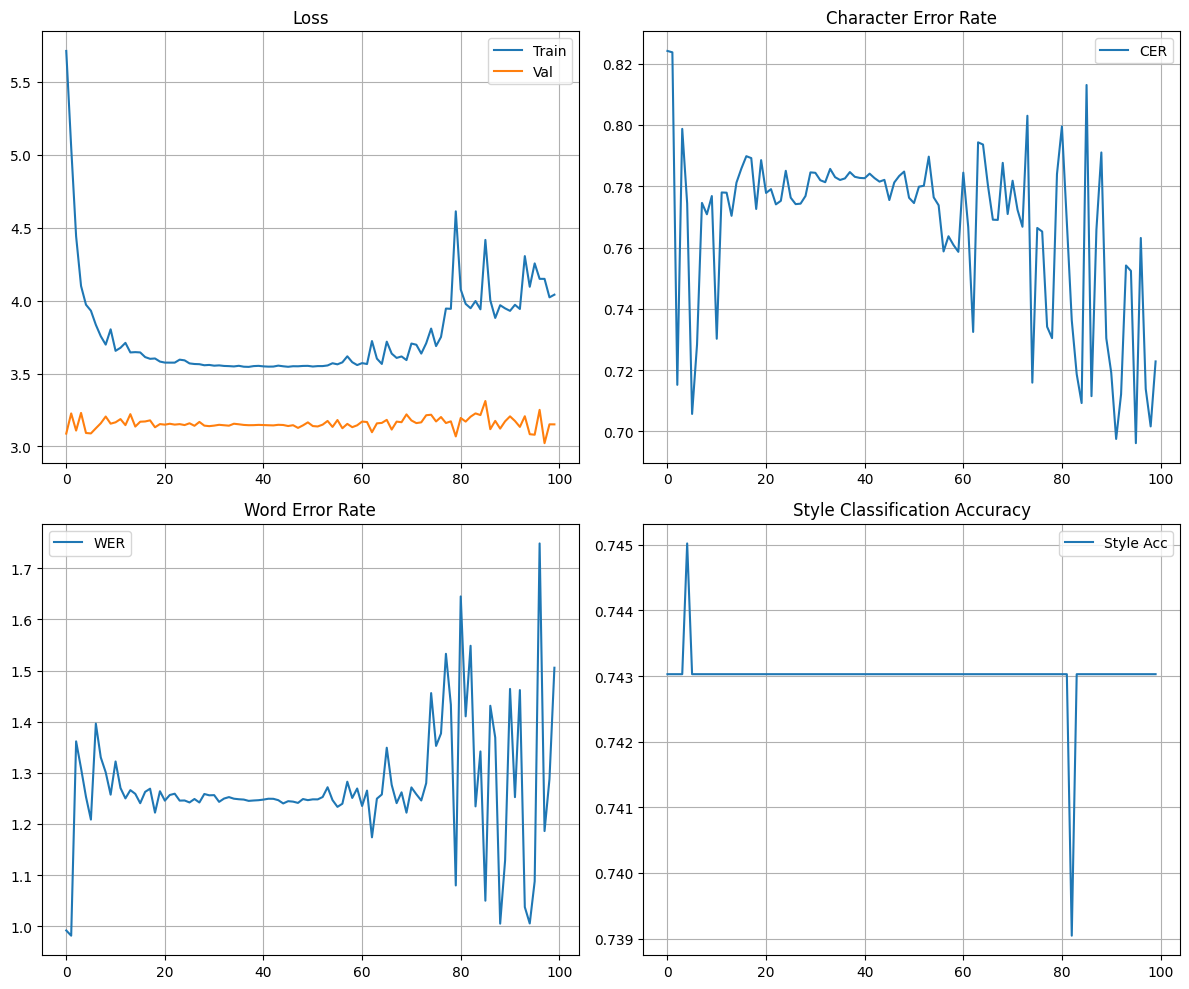


TEST EVALUATION
TEST — CER=0.6895 | WER=0.9927 | Style Acc=0.7435


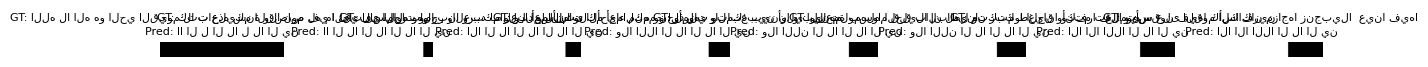

In [16]:
# ====================== Training Loop ======================
from pathlib import Path
import matplotlib.pyplot as plt
import gc, time

SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH = SAVE_DIR / "ocr_december_best.pt"

history = {
    "train_loss": [], "val_loss": [],
    "val_cer": [], "val_wer": [], "val_style_acc": []
}

best_cer = float('inf')
EPOCHS = 100

MAX_NORM = 5.0
AUX_CTC_WEIGHT = 0.3
LAMBDA_CLS = 0.2

print("\n" + "="*60)
print("TRAINING")
print("="*60)
print(f"Device: {DEVICE} | {gpu_mem()}\n")
steps_per_epoch = len(train_loader)
print(f"Epochs={EPOCHS}, Batch={BATCH_SIZE}, Steps/epoch={steps_per_epoch}")

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    seen = 0
    t0 = time.time()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=False)
    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        label_lens = label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with autocast_cuda():
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)
            log_probs_aux = ctc_logits_aux.log_softmax(2)

            T = log_probs_main.size(0)  # time dimension
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc_main = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens)
            loss_ctc_aux  = ctc_loss_fn(log_probs_aux.float(), labels_concat, input_lens, label_lens)
            loss_cls = cls_loss_fn(style_logits, style_idxs)

            loss = loss_ctc_main + AUX_CTC_WEIGHT * loss_ctc_aux + LAMBDA_CLS * loss_cls

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix(avg=f"{running_loss / max(1, seen):.4f}")

    scheduler.step()
    train_loss = running_loss / max(1, seen)
    history["train_loss"].append(train_loss)

    # ===== Validation =====
    val_metrics = evaluate(model, val_loader)
    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.4f} | "
          f"val_loss={val_metrics['loss']:.4f} | CER={val_metrics['cer']:.4f} | "
          f"WER={val_metrics['wer']:.4f} | StyleAcc={val_metrics['style_acc']:.3f} | {dt:.1f}s")

    # Save best model
    if val_metrics["cer"] < best_cer:
        best_cer = val_metrics["cer"]
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "charset": charset,
            "style_names": style_names
        }, BEST_PATH)
        print(f"  ✓ New best CER={best_cer:.4f} saved to {BEST_PATH}")

    # Memory cleanup
    gc.collect()
    torch.cuda.empty_cache()

# ===== Training Curves =====
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history["train_loss"], label="Train")
axes[0, 0].plot(history["val_loss"], label="Val")
axes[0, 0].set_title("Loss"); axes[0, 0].legend(); axes[0, 0].grid(True)

axes[0, 1].plot(history["val_cer"], label="CER")
axes[0, 1].set_title("Character Error Rate"); axes[0, 1].legend(); axes[0, 1].grid(True)

axes[1, 0].plot(history["val_wer"], label="WER")
axes[1, 0].set_title("Word Error Rate"); axes[1, 0].legend(); axes[1, 0].grid(True)

axes[1, 1].plot(history["val_style_acc"], label="Style Acc")
axes[1, 1].set_title("Style Classification Accuracy"); axes[1, 1].legend(); axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(SAVE_DIR / "training_curves.png", dpi=150)
plt.show()

# ===== Test Evaluation =====
print("\nTEST EVALUATION")
ckpt = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"], strict=False)
model.eval()
test_metrics = evaluate(model, test_loader)
print(f"TEST — CER={test_metrics['cer']:.4f} | WER={test_metrics['wer']:.4f} | Style Acc={test_metrics['style_acc']:.4f}")

# ===== Show Qualitative Samples =====
show_samples(model, test_loader, k=8)


Device: cuda
Charset size: 49


/tmp/ipython-input-266575667.py:143: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
/tmp/ipython-input-266575667.py:145: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
/tmp/ipython-input-266575667.py:146: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-266575667.py:148: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=8, m

Epoch 01:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 1: Loss 2.4171, CER 0.8197, WER 0.9945, StyleAcc 0.1813


Epoch 02:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 2: Loss 2.4155, CER 0.7017, WER 1.0215, StyleAcc 0.0817


Epoch 03:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 3: Loss 2.3826, CER 0.6883, WER 0.9757, StyleAcc 0.3406


Epoch 04:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 4: Loss 2.4176, CER 0.6928, WER 0.9996, StyleAcc 0.1414


Epoch 05:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 5: Loss 2.3546, CER 0.6996, WER 1.0105, StyleAcc 0.1414


Epoch 06:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

VAL Epoch 6: Loss 2.3806, CER 0.7245, WER 0.9896, StyleAcc 0.1414


Epoch 07:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 7: Loss 2.3894, CER 0.6843, WER 1.0037, StyleAcc 0.1414


Epoch 08:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 8: Loss 2.4312, CER 0.7293, WER 1.0577, StyleAcc 0.1414


Epoch 09:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 9: Loss 2.4319, CER 0.7292, WER 1.0577, StyleAcc 0.1414


Epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 10: Loss 2.4310, CER 0.7293, WER 1.0577, StyleAcc 0.1414


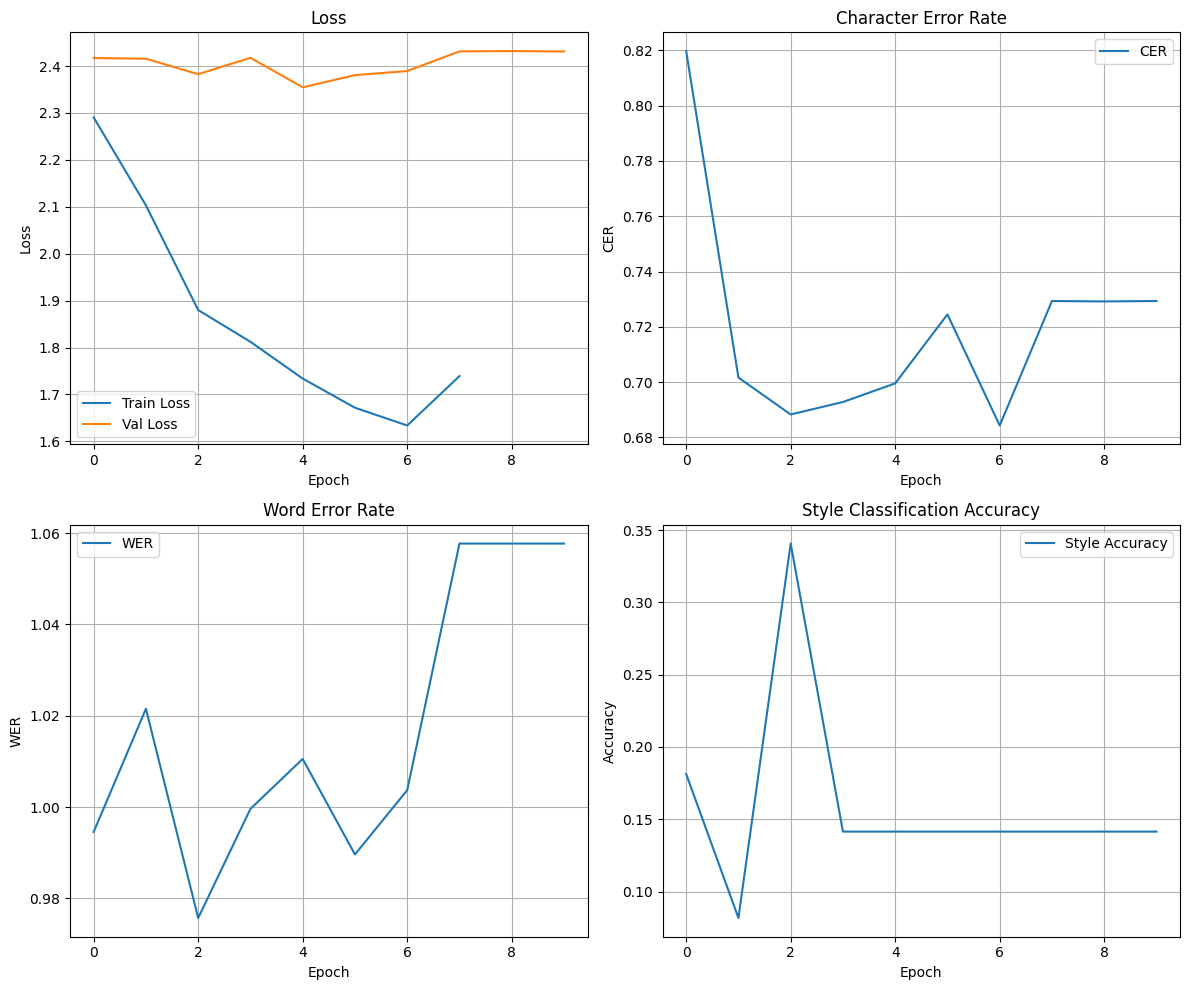


TEST METRICS — Loss: 2.3196, CER: 0.7403, WER: 1.0575, StyleAcc: 0.1471


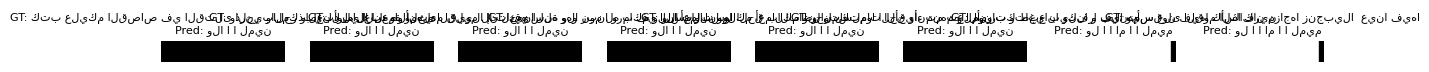

In [22]:
# %% FULL OCR TRAINING SCRIPT FOR Preprocessed_HICMA DATASET

# ====================== Setup ======================
import os, time, random, unicodedata, gc
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
import albumentations as A
from torchvision import models
from tqdm.auto import tqdm

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

def human(n): return f"{n:,}"

def autocast_cuda():
    return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        t = torch.cuda.get_device_properties(0).total_memory/1e9
        return f"GPU: {a:.2f}/{r:.2f}/{t:.1f}GB"
    return "CPU"

# ====================== Data Paths ======================
BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Augmented_HICMA")

TRAIN_DIR = BASE_DIR / "train/images"
VAL_DIR   = BASE_DIR / "val/images"
TEST_DIR  = BASE_DIR / "test/images"

TRAIN_LABELS = BASE_DIR / "train_labels.csv"
VAL_LABELS   = BASE_DIR / "val_labels.csv"
TEST_LABELS  = BASE_DIR / "test_labels.csv"

assert TRAIN_LABELS.exists() and VAL_LABELS.exists() and TEST_LABELS.exists(), "Label CSVs not found!"

# ====================== Load CSVs & Normalize ======================
def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df_train = pd.read_csv(TRAIN_LABELS)
df_val   = pd.read_csv(VAL_LABELS)
df_test  = pd.read_csv(TEST_LABELS)

for df in [df_train, df_val, df_test]:
    df['label'] = df['label'].astype(str).apply(normalize_label)
    df['img_path'] = df['img_name'].apply(lambda x: str((TRAIN_DIR if 'train' in df.columns else VAL_DIR) / x))

# ====================== Charset ======================
all_labels = pd.concat([df_train['label'], df_val['label'], df_test['label']])
char_counts = Counter()
for s in all_labels:
    for ch in s:
        char_counts[ch] += 1

charset = ['<BLANK>'] + sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
char2idx = {c: i for i, c in enumerate(charset)}
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
print(f"Charset size: {len(charset)}")

# ====================== Style Classes ======================
all_classes = pd.concat([df_train['class'], df_val['class'], df_test['class']]).fillna("Unknown")
style_names = sorted(all_classes.unique())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}

# ====================== Label Encoding ======================
RTL_REVERSE = True
def encode_label(text, rtl_reverse=True):
    if rtl_reverse: text = text[::-1]
    return [char2idx[ch] for ch in text if ch in char2idx and ch != '<BLANK>']

for df in [df_train, df_val, df_test]:
    df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
    df = df[df['enc_len'] > 0].reset_index(drop=True)

# ====================== Image Processing ======================
H_TARGET = 64
W_MAX = 384
MEAN, STD = 0.5, 0.5
MIN_PX_PER_CHAR = 8

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def decode_pred(indices, rtl_reverse=RTL_REVERSE):
    res, prev = [], None
    for idx in indices:
        if idx != BLANK_IDX and idx != prev:
            res.append(idx2char[idx])
        prev = idx
    s = "".join(res)
    return s[::-1] if rtl_reverse else s

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def pad_width_to_multiple(img, multiple=4, pad_value=255):
    h, w = img.shape
    pad_w = (multiple - (w % multiple)) % multiple
    if pad_w == 0: return img
    return cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=pad_value)

# ====================== Augmentations ======================
AUG_P = 0.35
train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.MotionBlur(blur_limit=3, p=AUG_P*0.7),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
    A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.02, rotate_limit=3, border_mode=cv2.BORDER_REPLICATE, p=AUG_P*0.8),
    A.CoarseDropout(max_holes=3, max_height=8, max_width=20, fill_value=255, p=AUG_P*0.5),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P*0.8)
])

def stroke_thickness_jitter(img, p=0.4):
    if random.random() > p: return img
    k = random.choice([1,1,2])
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*k+1,2*k+1))
    return cv2.erode(img, kernel) if random.random()<0.5 else cv2.dilate(img, kernel)

def cutout_stripes(img, p=0.25):
    if random.random() > p: return img
    h,w = img.shape
    n = random.randint(1,2)
    for _ in range(n):
        stripe_w = max(2,int(random.random()*max(3,w*0.1)))
        x0 = random.randint(0,max(0,w-stripe_w))
        img[:,x0:x0+stripe_w] = 255
    return img

def apply_train_aug(img):
    img = stroke_thickness_jitter(img)
    img = cutout_stripes(img)
    return train_aug(image=img)['image']

# ====================== Dataset ======================
class OCRDataset(Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.training = training
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.ones((H_TARGET,64),dtype=np.uint8)*255
        label_ids = encode_label(row['label'])
        style_idx = style2idx[row['class']]
        img = resize_keep_ar_enforced(img,H_TARGET,label_len=len(label_ids))
        MAX_WIDTH = 600
        if img.shape[1] > MAX_WIDTH:
          img = cv2.resize(img, (MAX_WIDTH, H_TARGET), interpolation=cv2.INTER_AREA)
        if self.training: img = apply_train_aug(img)
        img = pad_width_to_multiple(img)
        img = (img.astype(np.float32)/255.0 - MEAN)/STD
        img_t = torch.from_numpy(img)[None,...]
        return img_t, torch.tensor(label_ids,dtype=torch.long), row['label'], torch.tensor(style_idx), row['class'], img_t.shape[-1]

def collate_fn(batch):
    batch = sorted(batch,key=lambda x:x[-1],reverse=True)
    imgs, labels, label_strs, style_idxs, style_names_b, widths = zip(*batch)
    max_w = max(widths)
    bsz = len(imgs)
    padded = torch.full((bsz,1,H_TARGET,max_w),(0.0-MEAN)/STD,dtype=torch.float32)
    for i,im in enumerate(imgs):
        w = im.shape[-1]
        padded[i,:,:, :w] = im
    label_lens = torch.tensor([len(l) for l in labels],dtype=torch.long)
    labels_concat = torch.cat(labels,dim=0) if len(labels) else torch.tensor([],dtype=torch.long)
    return padded, labels_concat, label_lens, label_strs, torch.stack(style_idxs), style_names_b, torch.tensor(widths,dtype=torch.long)

# ====================== Model ======================
try: _IMAGENET_WEIGHTS = models.ResNet34_Weights.IMAGENET1K_V1
except: _IMAGENET_WEIGHTS = "IMAGENET1K_V1"

class ResNet34OCRBackbone(nn.Module):
    def __init__(self,in_ch=1):
        super().__init__()
        try: m=models.resnet34(weights=_IMAGENET_WEIGHTS)
        except: m=models.resnet34(pretrained=True)
        w=m.conv1.weight.data
        new_w=w.mean(dim=1,keepdim=True)
        m.conv1 = nn.Conv2d(in_ch,64,kernel_size=7,stride=(2,1),padding=3,bias=False)
        with torch.no_grad(): m.conv1.weight.copy_(new_w)
        m.maxpool = nn.MaxPool2d(3,stride=(2,1),padding=1)
        self.stem = nn.Sequential(m.conv1,m.bn1,m.relu,m.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = m.layer1, m.layer2, m.layer3, m.layer4
        self.out = nn.AdaptiveAvgPool2d((1,None))
    def forward(self,x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        fmap = x
        seq = self.out(fmap).squeeze(2).permute(2,0,1)
        return seq,fmap

class TemporalGLUBlock(nn.Module):
    def __init__(self,c=512,k=5,dilation=1,p=0.1):
        super().__init__()
        pad = (k-1)//2*dilation
        self.conv=nn.Conv1d(c,2*c,kernel_size=k,padding=pad,dilation=dilation)
        self.glu = nn.GLU(dim=1)
        self.drop=nn.Dropout(p)
        self.res=nn.Conv1d(c,c,kernel_size=1)
    def forward(self,x):
        x = x.permute(1,2,0)
        y = self.glu(self.conv(x))
        y = self.drop(y)+self.res(x)
        return y.permute(2,0,1)

class BiLSTMStack(nn.Module):
    def __init__(self,in_dim,hidden=256,num_layers=2,dropout=0.25):
        super().__init__()
        layers=[]
        for i in range(num_layers):
            inp=in_dim if i==0 else hidden*2
            layers.append(nn.LSTM(inp,hidden,bidirectional=True,batch_first=False))
            layers.append(nn.Dropout(dropout))
        self.layers=nn.ModuleList(layers)
    def forward(self,x):
        for i in range(0,len(self.layers),2):
            x,_=self.layers[i](x)
            x=self.layers[i+1](x)
        return x

class OCR_MultiTask_V3(nn.Module):
    def __init__(self,num_chars,num_styles,blank_idx=0,aux_weight=0.3):
        super().__init__()
        self.backbone = ResNet34OCRBackbone()
        self.tcn1 = TemporalGLUBlock(512,5,1,0.1)
        self.tcn2 = TemporalGLUBlock(512,5,2,0.1)
        self.lstm = BiLSTMStack(512,256,2,0.25)
        self.ctc_head_main = nn.Linear(512,num_chars)
        self.ctc_head_aux = nn.Linear(512,num_chars)
        self.style_head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),
                                        nn.Dropout(0.25),
                                        nn.Linear(512,max(256,num_styles*4)), nn.ReLU(True),
                                        nn.Linear(max(256,num_styles*4),num_styles))
        self.blank_idx = blank_idx
        self.aux_weight = aux_weight
        with torch.no_grad():
            self.ctc_head_main.bias.zero_(); self.ctc_head_main.bias[blank_idx]=-2.0
            self.ctc_head_aux.bias.zero_(); self.ctc_head_aux.bias[blank_idx]=-2.0
    def forward(self,x):
        seq,fmap=self.backbone(x)
        tcn_out=self.tcn2(self.tcn1(seq))
        lstm_out=self.lstm(tcn_out)
        ctc_logits_main=self.ctc_head_main(lstm_out)
        ctc_logits_aux=self.ctc_head_aux(tcn_out)
        style_logits=self.style_head(fmap.detach())
        return ctc_logits_main,ctc_logits_aux,style_logits

# ====================== Dataloaders ======================
BATCH_SIZE=32
train_ds = OCRDataset(df_train,training=True)
val_ds   = OCRDataset(df_val,training=False)
test_ds  = OCRDataset(df_test,training=False)

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4)
val_loader   = DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)
test_loader  = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)

# ====================== Loss & Optimizer ======================
num_chars = len(charset)
num_styles = len(style_names)
model = OCR_MultiTask_V3(num_chars,num_styles,blank_idx=BLANK_IDX).to(DEVICE)

ctc_loss_fn = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True)
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=50,eta_min=1e-6)
scaler = torch.amp.GradScaler(enabled=(DEVICE=="cuda"))

# ====================== Training & Evaluation Functions ======================
def ctc_time_lengths(widths):
    return torch.clamp(widths // 4, min=1, max=64)

def greedy_decode_ctc(logits,widths):
    max_idxs=logits.softmax(-1).argmax(-1)
    T,B = max_idxs.shape
    res=[]
    for b in range(B):
        L=int(widths[b])
        seq=max_idxs[:L,b].tolist()
        res.append(decode_pred(seq))
    return res

@torch.no_grad()
def evaluate(model,loader):
    model.eval(); tot_loss=tot_cer=tot_wer=0; cnt=0; cls_correct=cls_total=0
    for imgs,labels_concat,label_lens,label_strs,style_idxs,style_names_b,widths in loader:
        imgs,style_idxs,label_lens = imgs.to(DEVICE),style_idxs.to(DEVICE),label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)
        ctc_logits_main,ctc_logits_aux,style_logits=model(imgs)
        log_probs_main=ctc_logits_main.log_softmax(2)
        T = log_probs_main.size(0)
        input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)
        loss_ctc = ctc_loss_fn(log_probs_main.float(),labels_concat.to(DEVICE),input_lens,label_lens) if len(labels_concat)>0 else 0
        loss_cls = cls_loss_fn(style_logits, style_idxs)
        loss = loss_ctc + 0.2*loss_cls
        tot_loss += loss.item()*imgs.size(0); cnt+=imgs.size(0)
        preds=greedy_decode_ctc(ctc_logits_main,widths)
        for gt,pr in zip(label_strs,preds):
            tot_cer += editdistance.eval(gt,pr)/max(1,len(gt))
            tot_wer += editdistance.eval(gt.split(),pr.split())/max(1,len(gt.split()))
        cls_correct += (style_logits.argmax(1)==style_idxs).sum().item()
        cls_total += imgs.size(0)
    return {"loss":tot_loss/cnt,"cer":tot_cer/cnt,"wer":tot_wer/cnt,"style_acc":cls_correct/cls_total}

# ====================== TRAINING LOOP WITH HISTORY TRACKING ======================
EPOCHS = 10

# History dictionary to store metrics
history = {
    "train_loss": [],
    "val_loss": [],
    "val_cer": [],
    "val_wer": [],
    "val_style_acc": []
}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0
    seen = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}")

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        label_lens = label_lens.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)

            T = log_probs_main.size(0)
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens) if len(labels_concat) > 0 else 0
            loss_cls = cls_loss_fn(style_logits, style_idxs)
            loss = loss_ctc + 0.2 * loss_cls

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix({"train_loss": running / seen})

    # Step scheduler
    scheduler.step()

    # Epoch train loss
    train_loss_epoch = running / max(1, seen)
    history["train_loss"].append(train_loss_epoch)

    # Validation metrics
    val_metrics = evaluate(model, val_loader)
    print(f"VAL Epoch {epoch}: Loss {val_metrics['loss']:.4f}, CER {val_metrics['cer']:.4f}, "
          f"WER {val_metrics['wer']:.4f}, StyleAcc {val_metrics['style_acc']:.4f}")

    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

# ====================== PLOTTING TRAINING CURVES ======================
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history["val_cer"], label="CER")
plt.title("Character Error Rate")
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history["val_wer"], label="WER")
plt.title("Word Error Rate")
plt.xlabel("Epoch")
plt.ylabel("WER")
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history["val_style_acc"], label="Style Accuracy")
plt.title("Style Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ====================== TEST EVALUATION ======================
test_metrics = evaluate(model, test_loader)
print(f"\nTEST METRICS — Loss: {test_metrics['loss']:.4f}, CER: {test_metrics['cer']:.4f}, "
      f"WER: {test_metrics['wer']:.4f}, StyleAcc: {test_metrics['style_acc']:.4f}")

# ====================== QUALITATIVE SAMPLES ======================
def show_samples(model, loader, k=8):
    model.eval()
    imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths = next(iter(loader))
    imgs = imgs.to(DEVICE)
    with torch.no_grad():
        ctc_logits, _, _ = model(imgs)
    preds = greedy_decode_ctc(ctc_logits, widths)
    plt.figure(figsize=(15,3))
    for i in range(min(k,len(preds))):
        plt.subplot(1,k,i+1)
        plt.imshow(imgs[i,0].cpu(), cmap='gray')
        plt.title(f"GT: {label_strs[i]}\nPred: {preds[i]}", fontsize=8)
        plt.axis('off')
    plt.show()

show_samples(model, test_loader, k=8)



In [24]:


# ====================== Training Loop ======================
from pathlib import Path
import matplotlib.pyplot as plt
import gc, time

SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH = SAVE_DIR / "ocr_december_best_aug.pt"

history = {
    "train_loss": [], "val_loss": [],
    "val_cer": [], "val_wer": [], "val_style_acc": []
}

best_cer = float('inf')
EPOCHS = 50

MAX_NORM = 5.0
AUX_CTC_WEIGHT = 0.3
LAMBDA_CLS = 0.2

print("\n" + "="*60)
print("TRAINING")
print("="*60)
print(f"Device: {DEVICE} | {gpu_mem()}\n")
steps_per_epoch = len(train_loader)
print(f"Epochs={EPOCHS}, Batch={BATCH_SIZE}, Steps/epoch={steps_per_epoch}")

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    seen = 0
    t0 = time.time()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=False)
    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        label_lens = label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with autocast_cuda():
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)
            log_probs_aux = ctc_logits_aux.log_softmax(2)

            T = log_probs_main.size(0)  # time dimension
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc_main = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens)
            loss_ctc_aux  = ctc_loss_fn(log_probs_aux.float(), labels_concat, input_lens, label_lens)
            loss_cls = cls_loss_fn(style_logits, style_idxs)

            loss = loss_ctc_main + AUX_CTC_WEIGHT * loss_ctc_aux + LAMBDA_CLS * loss_cls

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix(avg=f"{running_loss / max(1, seen):.4f}")

    scheduler.step()
    train_loss = running_loss / max(1, seen)
    history["train_loss"].append(train_loss)

    # ===== Validation =====
    val_metrics = evaluate(model, val_loader)
    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.4f} | "
          f"val_loss={val_metrics['loss']:.4f} | CER={val_metrics['cer']:.4f} | "
          f"WER={val_metrics['wer']:.4f} | StyleAcc={val_metrics['style_acc']:.3f} | {dt:.1f}s")

    # Save best model
    if val_metrics["cer"] < best_cer:
        best_cer = val_metrics["cer"]
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "charset": charset,
            "style_names": style_names
        }, BEST_PATH)
        print(f"  ✓ New best CER={best_cer:.4f} saved to {BEST_PATH}")

    # Memory cleanup
    gc.collect()
    torch.cuda.empty_cache()

# ===== Training Curves =====
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history["train_loss"], label="Train")
axes[0, 0].plot(history["val_loss"], label="Val")
axes[0, 0].set_title("Loss"); axes[0, 0].legend(); axes[0, 0].grid(True)

axes[0, 1].plot(history["val_cer"], label="CER")
axes[0, 1].set_title("Character Error Rate"); axes[0, 1].legend(); axes[0, 1].grid(True)

axes[1, 0].plot(history["val_wer"], label="WER")
axes[1, 0].set_title("Word Error Rate"); axes[1, 0].legend(); axes[1, 0].grid(True)

axes[1, 1].plot(history["val_style_acc"], label="Style Acc")
axes[1, 1].set_title("Style Classification Accuracy"); axes[1, 1].legend(); axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(SAVE_DIR / "training_curves.png", dpi=150)
plt.show()

# ===== Test Evaluation =====
print("\nTEST EVALUATION")
ckpt = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"], strict=False)
model.eval()
test_metrics = evaluate(model, test_loader)
print(f"TEST — CER={test_metrics['cer']:.4f} | WER={test_metrics['wer']:.4f} | Style Acc={test_metrics['style_acc']:.4f}")

# ===== Show Qualitative Samples =====
@torch.no_grad()
def show_samples(model, loader, k=8, downsample_factor=4):
    """
    Fixed qualitative sample display:
     - Un-normalizes images before imshow
     - Uses correct CTC input lengths (widths // downsample_factor)
     - Shows style prediction and GT/Pred text with match marker
    """
    model.eval()

    imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths = next(iter(loader))
    B = imgs.size(0)
    imgs = imgs.to(DEVICE)

    # forward
    with autocast_cuda():
        ctc_logits_main, _, style_logits = model(imgs)

    # compute correct input lengths for CTC decoding (and for greedy decoder)
    # clamp to at least 1
    input_lens = torch.clamp((widths.to(DEVICE) // downsample_factor), min=1)

    # decode predictions
    preds = greedy_decode_ctc(ctc_logits_main, input_lens)
    style_pred = style_logits.softmax(1).argmax(1).cpu().tolist()

    n_show = min(k, B)

    # layout
    fig, axes = plt.subplots(n_show, 1, figsize=(14, 2.6 * n_show))
    if n_show == 1:
        axes = [axes]

    for i in range(n_show):
        # un-normalize image for display
        im = imgs[i, 0].cpu().numpy()
        im = np.clip(im * STD + MEAN, 0, 1)

        gt_style = style_names_b[i]
        pr_style = idx2style[style_pred[i]]
        gt_text = label_strs[i]
        pr_text = preds[i] if i < len(preds) else ""
        match = "✓" if gt_text == pr_text else "✗"

        axes[i].imshow(im, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Style: {gt_style} → {pr_style} | GT: {gt_text} | PR: {pr_text} {match}", fontsize=10)

    plt.tight_layout()
    out_path = SAVE_DIR / "sample_predictions_fixed.png" if 'SAVE_DIR' in globals() else Path("./sample_predictions_fixed.png")
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Saved to {out_path}")

# call it
show_samples(model, test_loader, k=8)



TRAINING
Device: cuda | GPU: 2.41/3.81/15.8GB

Epochs=50, Batch=32, Steps/epoch=625


Epoch 01:   0%|          | 0/625 [00:00<?, ?it/s]

RuntimeError: unscale_() has already been called on this optimizer since the last update().

Mounted at /content/drive
Extracting Set1...
  ✓ Set1 extracted to /content/dataset/Set1
Extracting Set2...
  ✓ Set2 extracted to /content/dataset/Set2
Extracting Set3...
  ✓ Set3 extracted to /content/dataset/Set3
Extracting Set4...
  ✓ Set4 extracted to /content/dataset/Set4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 67.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12.1 which is incompatible.
Device: cuda
GPU: NVIDIA L4
Total VRAM: 23.8 GB
Labels CSV: /content/drive/MyDrive/Full_Dataset/Complete_Dataset/labels_fixed.csv
Images found: 14,928 / 14,932 (100.0%)
Charset size (incl <BLANK>): 72
Styles (4): ['Diwani', 'Kufic', 'Naskh', 'Thuluth']

CLASS DISTRIBUTION ANALYSIS
class
Naskh      

100%|██████████| 83.3M/83.3M [00:00<00:00, 161MB/s]


Total parameters: 30,408,788
Trainable parameters: 30,408,788

TRAINING
Backbone frozen for warmup epoch.

[Training] Epochs=100, Batch=128, Steps/epoch=94
Device: cuda | GPU: 0.25/0.25/23.8GB



Epoch 001:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 001/100 | train=10.707 | val_raw: CER=0.9905 WER=1.0000 style=0.796 | val_EMA: CER=0.8056 WER=1.2903 style=0.250 | 165.2s | GPU: 0.40/2.30/23.8GB
  ✓ New best RAW CER=0.9905 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.8056 saved to checkpoints/ocr_december_best_ema.pt
Backbone unfrozen.


Epoch 002:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 002/100 | train=4.766 | val_raw: CER=0.9905 WER=1.0000 style=0.560 | val_EMA: CER=0.8162 WER=1.2029 style=0.329 | 238.8s | GPU: 0.66/4.25/23.8GB
  ✓ New best RAW CER=0.9905 saved to checkpoints/ocr_december_best.pt


Epoch 003:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 003/100 | train=4.285 | val_raw: CER=0.9576 WER=1.0000 style=0.773 | val_EMA: CER=0.9355 WER=1.0173 style=0.448 | 212.8s | GPU: 0.66/17.96/23.8GB
  ✓ New best RAW CER=0.9576 saved to checkpoints/ocr_december_best.pt


Epoch 004:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 004/100 | train=4.026 | val_raw: CER=0.8687 WER=0.9999 style=0.756 | val_EMA: CER=0.9423 WER=1.0000 style=0.477 | 213.7s | GPU: 0.66/17.96/23.8GB
  ✓ New best RAW CER=0.8687 saved to checkpoints/ocr_december_best.pt


Epoch 005:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 005/100 | train=3.682 | val_raw: CER=0.6864 WER=0.9978 style=0.758 | val_EMA: CER=0.8936 WER=1.0194 style=0.513 | 214.0s | GPU: 0.66/17.96/23.8GB
  ✓ New best RAW CER=0.6864 saved to checkpoints/ocr_december_best.pt


Epoch 006:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 006/100 | train=2.804 | val_raw: CER=0.3680 WER=0.8395 style=0.658 | val_EMA: CER=0.7945 WER=1.0286 style=0.564 | 213.2s | GPU: 0.66/18.11/23.8GB
  ✓ New best RAW CER=0.3680 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.7945 saved to checkpoints/ocr_december_best_ema.pt


Epoch 007:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 007/100 | train=2.044 | val_raw: CER=0.1918 WER=0.5631 style=0.832 | val_EMA: CER=0.9590 WER=1.0000 style=0.581 | 213.5s | GPU: 0.66/18.11/23.8GB
  ✓ New best RAW CER=0.1918 saved to checkpoints/ocr_december_best.pt


Epoch 008:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 008/100 | train=1.711 | val_raw: CER=0.1601 WER=0.4962 style=0.829 | val_EMA: CER=0.9610 WER=1.0000 style=0.633 | 214.5s | GPU: 0.66/18.11/23.8GB
  ✓ New best RAW CER=0.1601 saved to checkpoints/ocr_december_best.pt


Epoch 009:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 009/100 | train=1.562 | val_raw: CER=0.1358 WER=0.4277 style=0.867 | val_EMA: CER=0.9610 WER=1.0000 style=0.661 | 213.8s | GPU: 0.66/18.11/23.8GB
  ✓ New best RAW CER=0.1358 saved to checkpoints/ocr_december_best.pt


Epoch 010:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 010/100 | train=1.458 | val_raw: CER=0.1172 WER=0.3752 style=0.813 | val_EMA: CER=0.9784 WER=1.0000 style=0.688 | 213.0s | GPU: 0.66/18.11/23.8GB
  ✓ New best RAW CER=0.1172 saved to checkpoints/ocr_december_best.pt


Epoch 011:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 011/100 | train=1.374 | val_raw: CER=0.1027 WER=0.3324 style=0.891 | val_EMA: CER=0.9719 WER=1.0000 style=0.712 | 213.6s | GPU: 0.66/17.63/23.8GB
  ✓ New best RAW CER=0.1027 saved to checkpoints/ocr_december_best.pt


Epoch 012:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 012/100 | train=1.306 | val_raw: CER=0.0910 WER=0.3012 style=0.908 | val_EMA: CER=0.9440 WER=1.0000 style=0.721 | 213.4s | GPU: 0.66/17.81/23.8GB
  ✓ New best RAW CER=0.0910 saved to checkpoints/ocr_december_best.pt


Epoch 013:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 013/100 | train=1.268 | val_raw: CER=0.0914 WER=0.3040 style=0.906 | val_EMA: CER=0.8807 WER=1.0000 style=0.723 | 214.4s | GPU: 0.66/17.81/23.8GB


Epoch 014:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 014/100 | train=1.201 | val_raw: CER=0.0865 WER=0.2856 style=0.891 | val_EMA: CER=0.8132 WER=1.0001 style=0.726 | 214.5s | GPU: 0.66/17.81/23.8GB
  ✓ New best RAW CER=0.0865 saved to checkpoints/ocr_december_best.pt


Epoch 015:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 015/100 | train=1.195 | val_raw: CER=0.0853 WER=0.2799 style=0.779 | val_EMA: CER=0.7441 WER=0.9943 style=0.723 | 214.3s | GPU: 0.66/17.81/23.8GB
  ✓ New best RAW CER=0.0853 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.7441 saved to checkpoints/ocr_december_best_ema.pt


Epoch 016:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 016/100 | train=1.171 | val_raw: CER=0.0784 WER=0.2580 style=0.904 | val_EMA: CER=0.6713 WER=0.9754 style=0.731 | 212.9s | GPU: 0.66/17.81/23.8GB
  ✓ New best RAW CER=0.0784 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.6713 saved to checkpoints/ocr_december_best_ema.pt


Epoch 017:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 017/100 | train=1.148 | val_raw: CER=0.0752 WER=0.2455 style=0.800 | val_EMA: CER=0.5788 WER=0.9393 style=0.731 | 214.2s | GPU: 0.66/17.81/23.8GB
  ✓ New best RAW CER=0.0752 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.5788 saved to checkpoints/ocr_december_best_ema.pt


Epoch 018:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 018/100 | train=1.159 | val_raw: CER=0.0776 WER=0.2547 style=0.875 | val_EMA: CER=0.4702 WER=0.8793 style=0.725 | 212.9s | GPU: 0.66/17.81/23.8GB
  ✓ New best EMA CER=0.4702 saved to checkpoints/ocr_december_best_ema.pt


Epoch 019:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 019/100 | train=1.093 | val_raw: CER=0.0699 WER=0.2385 style=0.887 | val_EMA: CER=0.3753 WER=0.8036 style=0.730 | 213.9s | GPU: 0.66/17.81/23.8GB
  ✓ New best RAW CER=0.0699 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.3753 saved to checkpoints/ocr_december_best_ema.pt


Epoch 020:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 020/100 | train=1.073 | val_raw: CER=0.0700 WER=0.2304 style=0.906 | val_EMA: CER=0.3022 WER=0.7192 style=0.743 | 213.2s | GPU: 0.66/17.99/23.8GB
  ✓ New best EMA CER=0.3022 saved to checkpoints/ocr_december_best_ema.pt


Epoch 021:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 021/100 | train=1.051 | val_raw: CER=0.0649 WER=0.2170 style=0.809 | val_EMA: CER=0.2444 WER=0.6462 style=0.749 | 213.5s | GPU: 0.66/17.80/23.8GB
  ✓ New best RAW CER=0.0649 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.2444 saved to checkpoints/ocr_december_best_ema.pt


Epoch 022:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 022/100 | train=1.054 | val_raw: CER=0.0659 WER=0.2215 style=0.722 | val_EMA: CER=0.2046 WER=0.5743 style=0.764 | 212.6s | GPU: 0.66/17.80/23.8GB
  ✓ New best EMA CER=0.2046 saved to checkpoints/ocr_december_best_ema.pt


Epoch 023:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 023/100 | train=1.036 | val_raw: CER=0.0628 WER=0.2067 style=0.838 | val_EMA: CER=0.1690 WER=0.5075 style=0.772 | 213.4s | GPU: 0.66/17.80/23.8GB
  ✓ New best RAW CER=0.0628 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.1690 saved to checkpoints/ocr_december_best_ema.pt


Epoch 024:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 024/100 | train=1.009 | val_raw: CER=0.0631 WER=0.2100 style=0.915 | val_EMA: CER=0.1465 WER=0.4525 style=0.794 | 213.1s | GPU: 0.66/17.80/23.8GB
  ✓ New best EMA CER=0.1465 saved to checkpoints/ocr_december_best_ema.pt


Epoch 025:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 025/100 | train=1.017 | val_raw: CER=0.0612 WER=0.2047 style=0.894 | val_EMA: CER=0.1294 WER=0.4122 style=0.800 | 212.5s | GPU: 0.66/17.80/23.8GB
  ✓ New best RAW CER=0.0612 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.1294 saved to checkpoints/ocr_december_best_ema.pt


Epoch 026:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 026/100 | train=0.986 | val_raw: CER=0.0617 WER=0.2070 style=0.869 | val_EMA: CER=0.1148 WER=0.3698 style=0.814 | 213.2s | GPU: 0.66/17.80/23.8GB
  ✓ New best EMA CER=0.1148 saved to checkpoints/ocr_december_best_ema.pt


Epoch 027:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 027/100 | train=0.978 | val_raw: CER=0.0590 WER=0.1995 style=0.831 | val_EMA: CER=0.1043 WER=0.3380 style=0.829 | 212.8s | GPU: 0.66/17.80/23.8GB
  ✓ New best RAW CER=0.0590 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.1043 saved to checkpoints/ocr_december_best_ema.pt


Epoch 028:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 028/100 | train=0.999 | val_raw: CER=0.0553 WER=0.1844 style=0.910 | val_EMA: CER=0.0952 WER=0.3105 style=0.843 | 212.9s | GPU: 0.66/17.80/23.8GB
  ✓ New best RAW CER=0.0553 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0952 saved to checkpoints/ocr_december_best_ema.pt


Epoch 029:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 029/100 | train=0.929 | val_raw: CER=0.0543 WER=0.1803 style=0.872 | val_EMA: CER=0.0876 WER=0.2860 style=0.861 | 212.9s | GPU: 0.66/17.80/23.8GB
  ✓ New best RAW CER=0.0543 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0876 saved to checkpoints/ocr_december_best_ema.pt


Epoch 030:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 030/100 | train=0.932 | val_raw: CER=0.0564 WER=0.1879 style=0.878 | val_EMA: CER=0.0810 WER=0.2649 style=0.864 | 213.6s | GPU: 0.66/17.80/23.8GB
  ✓ New best EMA CER=0.0810 saved to checkpoints/ocr_december_best_ema.pt


Epoch 031:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 031/100 | train=0.936 | val_raw: CER=0.0527 WER=0.1762 style=0.870 | val_EMA: CER=0.0761 WER=0.2507 style=0.869 | 214.1s | GPU: 0.66/17.87/23.8GB
  ✓ New best RAW CER=0.0527 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0761 saved to checkpoints/ocr_december_best_ema.pt


Epoch 032:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 032/100 | train=0.910 | val_raw: CER=0.0522 WER=0.1742 style=0.876 | val_EMA: CER=0.0720 WER=0.2366 style=0.882 | 213.7s | GPU: 0.66/17.87/23.8GB
  ✓ New best RAW CER=0.0522 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0720 saved to checkpoints/ocr_december_best_ema.pt


Epoch 033:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 033/100 | train=0.911 | val_raw: CER=0.0532 WER=0.1775 style=0.906 | val_EMA: CER=0.0679 WER=0.2231 style=0.888 | 213.2s | GPU: 0.66/17.87/23.8GB
  ✓ New best EMA CER=0.0679 saved to checkpoints/ocr_december_best_ema.pt


Epoch 034:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 034/100 | train=0.909 | val_raw: CER=0.0512 WER=0.1658 style=0.903 | val_EMA: CER=0.0649 WER=0.2131 style=0.898 | 212.6s | GPU: 0.66/17.87/23.8GB
  ✓ New best RAW CER=0.0512 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0649 saved to checkpoints/ocr_december_best_ema.pt


Epoch 035:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 035/100 | train=0.888 | val_raw: CER=0.0515 WER=0.1700 style=0.884 | val_EMA: CER=0.0618 WER=0.2027 style=0.905 | 214.4s | GPU: 0.66/17.87/23.8GB
  ✓ New best EMA CER=0.0618 saved to checkpoints/ocr_december_best_ema.pt


Epoch 036:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 036/100 | train=0.880 | val_raw: CER=0.0510 WER=0.1705 style=0.859 | val_EMA: CER=0.0596 WER=0.1952 style=0.906 | 213.2s | GPU: 0.66/17.87/23.8GB
  ✓ New best RAW CER=0.0510 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0596 saved to checkpoints/ocr_december_best_ema.pt


Epoch 037:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 037/100 | train=0.874 | val_raw: CER=0.0498 WER=0.1642 style=0.789 | val_EMA: CER=0.0570 WER=0.1860 style=0.914 | 214.6s | GPU: 0.66/17.87/23.8GB
  ✓ New best RAW CER=0.0498 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0570 saved to checkpoints/ocr_december_best_ema.pt


Epoch 038:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 038/100 | train=0.878 | val_raw: CER=0.0494 WER=0.1608 style=0.830 | val_EMA: CER=0.0548 WER=0.1786 style=0.917 | 213.4s | GPU: 0.66/17.87/23.8GB
  ✓ New best RAW CER=0.0494 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0548 saved to checkpoints/ocr_december_best_ema.pt


Epoch 039:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 039/100 | train=0.866 | val_raw: CER=0.0496 WER=0.1658 style=0.853 | val_EMA: CER=0.0528 WER=0.1714 style=0.919 | 212.5s | GPU: 0.66/17.87/23.8GB
  ✓ New best EMA CER=0.0528 saved to checkpoints/ocr_december_best_ema.pt


Epoch 040:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 040/100 | train=0.848 | val_raw: CER=0.0465 WER=0.1525 style=0.889 | val_EMA: CER=0.0514 WER=0.1666 style=0.916 | 212.1s | GPU: 0.66/17.87/23.8GB
  ✓ New best RAW CER=0.0465 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0514 saved to checkpoints/ocr_december_best_ema.pt


Epoch 041:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 041/100 | train=0.845 | val_raw: CER=0.0473 WER=0.1521 style=0.877 | val_EMA: CER=0.0501 WER=0.1615 style=0.917 | 213.3s | GPU: 0.66/17.71/23.8GB
  ✓ New best EMA CER=0.0501 saved to checkpoints/ocr_december_best_ema.pt


Epoch 042:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 042/100 | train=0.838 | val_raw: CER=0.0461 WER=0.1524 style=0.898 | val_EMA: CER=0.0490 WER=0.1579 style=0.918 | 213.7s | GPU: 0.66/17.89/23.8GB
  ✓ New best RAW CER=0.0461 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0490 saved to checkpoints/ocr_december_best_ema.pt


Epoch 043:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 043/100 | train=0.817 | val_raw: CER=0.0449 WER=0.1494 style=0.891 | val_EMA: CER=0.0476 WER=0.1539 style=0.918 | 213.4s | GPU: 0.66/17.89/23.8GB
  ✓ New best RAW CER=0.0449 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0476 saved to checkpoints/ocr_december_best_ema.pt


Epoch 044:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 044/100 | train=0.805 | val_raw: CER=0.0464 WER=0.1514 style=0.837 | val_EMA: CER=0.0468 WER=0.1520 style=0.919 | 212.5s | GPU: 0.66/17.89/23.8GB
  ✓ New best EMA CER=0.0468 saved to checkpoints/ocr_december_best_ema.pt


Epoch 045:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 045/100 | train=0.807 | val_raw: CER=0.0461 WER=0.1541 style=0.924 | val_EMA: CER=0.0460 WER=0.1496 style=0.920 | 213.6s | GPU: 0.66/17.89/23.8GB
  ✓ New best EMA CER=0.0460 saved to checkpoints/ocr_december_best_ema.pt


Epoch 046:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 046/100 | train=0.818 | val_raw: CER=0.0449 WER=0.1492 style=0.919 | val_EMA: CER=0.0453 WER=0.1477 style=0.923 | 212.9s | GPU: 0.66/17.90/23.8GB
  ✓ New best EMA CER=0.0453 saved to checkpoints/ocr_december_best_ema.pt


Epoch 047:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 047/100 | train=0.812 | val_raw: CER=0.0460 WER=0.1531 style=0.922 | val_EMA: CER=0.0447 WER=0.1454 style=0.922 | 213.0s | GPU: 0.66/17.90/23.8GB
  ✓ New best EMA CER=0.0447 saved to checkpoints/ocr_december_best_ema.pt


Epoch 048:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 048/100 | train=0.789 | val_raw: CER=0.0450 WER=0.1490 style=0.868 | val_EMA: CER=0.0442 WER=0.1437 style=0.921 | 213.4s | GPU: 0.66/17.90/23.8GB
  ✓ New best EMA CER=0.0442 saved to checkpoints/ocr_december_best_ema.pt


Epoch 049:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 049/100 | train=0.788 | val_raw: CER=0.0450 WER=0.1461 style=0.885 | val_EMA: CER=0.0438 WER=0.1419 style=0.921 | 213.0s | GPU: 0.66/17.90/23.8GB
  ✓ New best EMA CER=0.0438 saved to checkpoints/ocr_december_best_ema.pt


Epoch 050:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 050/100 | train=0.800 | val_raw: CER=0.0438 WER=0.1440 style=0.902 | val_EMA: CER=0.0428 WER=0.1390 style=0.919 | 212.8s | GPU: 0.66/17.90/23.8GB
  ✓ New best RAW CER=0.0438 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0428 saved to checkpoints/ocr_december_best_ema.pt


Epoch 051:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 051/100 | train=0.785 | val_raw: CER=0.0436 WER=0.1435 style=0.890 | val_EMA: CER=0.0427 WER=0.1377 style=0.920 | 213.3s | GPU: 0.66/17.90/23.8GB
  ✓ New best RAW CER=0.0436 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0427 saved to checkpoints/ocr_december_best_ema.pt


Epoch 052:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 052/100 | train=0.769 | val_raw: CER=0.0442 WER=0.1413 style=0.889 | val_EMA: CER=0.0426 WER=0.1369 style=0.918 | 212.6s | GPU: 0.66/17.90/23.8GB
  ✓ New best EMA CER=0.0426 saved to checkpoints/ocr_december_best_ema.pt


Epoch 053:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 053/100 | train=0.743 | val_raw: CER=0.0429 WER=0.1422 style=0.929 | val_EMA: CER=0.0421 WER=0.1351 style=0.918 | 212.7s | GPU: 0.66/17.90/23.8GB
  ✓ New best RAW CER=0.0429 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0421 saved to checkpoints/ocr_december_best_ema.pt


Epoch 054:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 054/100 | train=0.762 | val_raw: CER=0.0445 WER=0.1459 style=0.889 | val_EMA: CER=0.0415 WER=0.1325 style=0.916 | 212.7s | GPU: 0.66/17.90/23.8GB
  ✓ New best EMA CER=0.0415 saved to checkpoints/ocr_december_best_ema.pt


Epoch 055:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 055/100 | train=0.755 | val_raw: CER=0.0446 WER=0.1438 style=0.868 | val_EMA: CER=0.0408 WER=0.1306 style=0.918 | 212.4s | GPU: 0.66/17.90/23.8GB
  ✓ New best EMA CER=0.0408 saved to checkpoints/ocr_december_best_ema.pt


Epoch 056:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 056/100 | train=0.754 | val_raw: CER=0.0428 WER=0.1397 style=0.861 | val_EMA: CER=0.0407 WER=0.1302 style=0.918 | 212.4s | GPU: 0.66/17.90/23.8GB
  ✓ New best RAW CER=0.0428 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0407 saved to checkpoints/ocr_december_best_ema.pt


Epoch 057:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 057/100 | train=0.732 | val_raw: CER=0.0414 WER=0.1374 style=0.865 | val_EMA: CER=0.0406 WER=0.1301 style=0.918 | 213.2s | GPU: 0.66/17.90/23.8GB
  ✓ New best RAW CER=0.0414 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0406 saved to checkpoints/ocr_december_best_ema.pt


Epoch 058:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 058/100 | train=0.725 | val_raw: CER=0.0408 WER=0.1332 style=0.900 | val_EMA: CER=0.0405 WER=0.1301 style=0.918 | 212.2s | GPU: 0.66/17.90/23.8GB
  ✓ New best RAW CER=0.0408 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0405 saved to checkpoints/ocr_december_best_ema.pt


Epoch 059:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 059/100 | train=0.730 | val_raw: CER=0.0434 WER=0.1393 style=0.887 | val_EMA: CER=0.0403 WER=0.1295 style=0.918 | 212.6s | GPU: 0.66/17.90/23.8GB
  ✓ New best EMA CER=0.0403 saved to checkpoints/ocr_december_best_ema.pt


Epoch 060:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 060/100 | train=0.725 | val_raw: CER=0.0417 WER=0.1343 style=0.895 | val_EMA: CER=0.0399 WER=0.1290 style=0.915 | 212.3s | GPU: 0.66/17.90/23.8GB
  ✓ New best EMA CER=0.0399 saved to checkpoints/ocr_december_best_ema.pt


Epoch 061:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 061/100 | train=0.724 | val_raw: CER=0.0408 WER=0.1308 style=0.893 | val_EMA: CER=0.0396 WER=0.1283 style=0.914 | 213.7s | GPU: 0.66/17.76/23.8GB
  ✓ New best RAW CER=0.0408 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0396 saved to checkpoints/ocr_december_best_ema.pt


Epoch 062:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 062/100 | train=0.714 | val_raw: CER=0.0406 WER=0.1315 style=0.906 | val_EMA: CER=0.0396 WER=0.1276 style=0.912 | 213.3s | GPU: 0.66/17.76/23.8GB
  ✓ New best RAW CER=0.0406 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0396 saved to checkpoints/ocr_december_best_ema.pt


Epoch 063:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 063/100 | train=0.708 | val_raw: CER=0.0401 WER=0.1332 style=0.913 | val_EMA: CER=0.0392 WER=0.1256 style=0.910 | 212.9s | GPU: 0.66/17.76/23.8GB
  ✓ New best RAW CER=0.0401 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0392 saved to checkpoints/ocr_december_best_ema.pt


Epoch 064:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 064/100 | train=0.688 | val_raw: CER=0.0412 WER=0.1334 style=0.892 | val_EMA: CER=0.0390 WER=0.1258 style=0.910 | 213.1s | GPU: 0.66/17.76/23.8GB
  ✓ New best EMA CER=0.0390 saved to checkpoints/ocr_december_best_ema.pt


Epoch 065:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 065/100 | train=0.701 | val_raw: CER=0.0403 WER=0.1317 style=0.861 | val_EMA: CER=0.0390 WER=0.1263 style=0.909 | 212.4s | GPU: 0.66/17.76/23.8GB


Epoch 066:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 066/100 | train=0.680 | val_raw: CER=0.0406 WER=0.1324 style=0.881 | val_EMA: CER=0.0390 WER=0.1258 style=0.910 | 212.9s | GPU: 0.66/17.76/23.8GB
  ✓ New best EMA CER=0.0390 saved to checkpoints/ocr_december_best_ema.pt


Epoch 067:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 067/100 | train=0.692 | val_raw: CER=0.0401 WER=0.1288 style=0.882 | val_EMA: CER=0.0386 WER=0.1255 style=0.908 | 212.2s | GPU: 0.66/17.76/23.8GB
  ✓ New best RAW CER=0.0401 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0386 saved to checkpoints/ocr_december_best_ema.pt


Epoch 068:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 068/100 | train=0.679 | val_raw: CER=0.0406 WER=0.1312 style=0.920 | val_EMA: CER=0.0385 WER=0.1242 style=0.908 | 213.3s | GPU: 0.66/17.76/23.8GB
  ✓ New best EMA CER=0.0385 saved to checkpoints/ocr_december_best_ema.pt


Epoch 069:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 069/100 | train=0.689 | val_raw: CER=0.0390 WER=0.1262 style=0.912 | val_EMA: CER=0.0383 WER=0.1236 style=0.906 | 212.2s | GPU: 0.66/17.94/23.8GB
  ✓ New best RAW CER=0.0390 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0383 saved to checkpoints/ocr_december_best_ema.pt


Epoch 070:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 070/100 | train=0.693 | val_raw: CER=0.0395 WER=0.1281 style=0.900 | val_EMA: CER=0.0384 WER=0.1236 style=0.904 | 212.7s | GPU: 0.66/17.94/23.8GB


Epoch 071:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 071/100 | train=0.663 | val_raw: CER=0.0405 WER=0.1302 style=0.914 | val_EMA: CER=0.0382 WER=0.1233 style=0.902 | 213.1s | GPU: 0.66/17.79/23.8GB
  ✓ New best EMA CER=0.0382 saved to checkpoints/ocr_december_best_ema.pt


Epoch 072:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 072/100 | train=0.669 | val_raw: CER=0.0396 WER=0.1299 style=0.906 | val_EMA: CER=0.0383 WER=0.1240 style=0.903 | 212.9s | GPU: 0.66/17.79/23.8GB


Epoch 073:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 073/100 | train=0.672 | val_raw: CER=0.0392 WER=0.1274 style=0.896 | val_EMA: CER=0.0381 WER=0.1229 style=0.904 | 212.9s | GPU: 0.66/17.79/23.8GB
  ✓ New best EMA CER=0.0381 saved to checkpoints/ocr_december_best_ema.pt


Epoch 074:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 074/100 | train=0.657 | val_raw: CER=0.0390 WER=0.1273 style=0.902 | val_EMA: CER=0.0381 WER=0.1224 style=0.906 | 213.2s | GPU: 0.66/17.79/23.8GB
  ✓ New best RAW CER=0.0390 saved to checkpoints/ocr_december_best.pt


Epoch 075:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 075/100 | train=0.672 | val_raw: CER=0.0385 WER=0.1256 style=0.896 | val_EMA: CER=0.0382 WER=0.1236 style=0.906 | 212.7s | GPU: 0.66/17.79/23.8GB
  ✓ New best RAW CER=0.0385 saved to checkpoints/ocr_december_best.pt


Epoch 076:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 076/100 | train=0.658 | val_raw: CER=0.0389 WER=0.1258 style=0.902 | val_EMA: CER=0.0381 WER=0.1228 style=0.908 | 212.4s | GPU: 0.66/17.79/23.8GB
  ✓ New best EMA CER=0.0381 saved to checkpoints/ocr_december_best_ema.pt


Epoch 077:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 077/100 | train=0.674 | val_raw: CER=0.0388 WER=0.1258 style=0.891 | val_EMA: CER=0.0381 WER=0.1234 style=0.904 | 214.3s | GPU: 0.66/17.79/23.8GB


Epoch 078:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 078/100 | train=0.655 | val_raw: CER=0.0388 WER=0.1269 style=0.910 | val_EMA: CER=0.0382 WER=0.1232 style=0.906 | 213.3s | GPU: 0.66/17.97/23.8GB


Epoch 079:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 079/100 | train=0.644 | val_raw: CER=0.0387 WER=0.1262 style=0.914 | val_EMA: CER=0.0381 WER=0.1231 style=0.906 | 212.5s | GPU: 0.66/17.97/23.8GB


Epoch 080:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 080/100 | train=0.644 | val_raw: CER=0.0386 WER=0.1259 style=0.881 | val_EMA: CER=0.0377 WER=0.1219 style=0.902 | 212.7s | GPU: 0.66/17.97/23.8GB
  ✓ New best EMA CER=0.0377 saved to checkpoints/ocr_december_best_ema.pt


Epoch 081:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 081/100 | train=0.641 | val_raw: CER=0.0388 WER=0.1257 style=0.896 | val_EMA: CER=0.0375 WER=0.1210 style=0.903 | 212.9s | GPU: 0.66/17.85/23.8GB
  ✓ New best EMA CER=0.0375 saved to checkpoints/ocr_december_best_ema.pt


Epoch 082:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 082/100 | train=0.635 | val_raw: CER=0.0385 WER=0.1247 style=0.869 | val_EMA: CER=0.0377 WER=0.1220 style=0.904 | 212.7s | GPU: 0.66/17.85/23.8GB
  ✓ New best RAW CER=0.0385 saved to checkpoints/ocr_december_best.pt


Epoch 083:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 083/100 | train=0.646 | val_raw: CER=0.0383 WER=0.1249 style=0.883 | val_EMA: CER=0.0379 WER=0.1217 style=0.900 | 213.6s | GPU: 0.66/17.85/23.8GB
  ✓ New best RAW CER=0.0383 saved to checkpoints/ocr_december_best.pt


Epoch 084:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 084/100 | train=0.631 | val_raw: CER=0.0383 WER=0.1249 style=0.880 | val_EMA: CER=0.0376 WER=0.1214 style=0.899 | 214.5s | GPU: 0.66/17.85/23.8GB
  ✓ New best RAW CER=0.0383 saved to checkpoints/ocr_december_best.pt


Epoch 085:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 085/100 | train=0.649 | val_raw: CER=0.0380 WER=0.1241 style=0.890 | val_EMA: CER=0.0375 WER=0.1214 style=0.896 | 214.5s | GPU: 0.66/17.85/23.8GB
  ✓ New best RAW CER=0.0380 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0375 saved to checkpoints/ocr_december_best_ema.pt


Epoch 086:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 086/100 | train=0.625 | val_raw: CER=0.0377 WER=0.1231 style=0.913 | val_EMA: CER=0.0375 WER=0.1217 style=0.898 | 214.0s | GPU: 0.66/17.85/23.8GB
  ✓ New best RAW CER=0.0377 saved to checkpoints/ocr_december_best.pt


Epoch 087:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 087/100 | train=0.630 | val_raw: CER=0.0377 WER=0.1231 style=0.906 | val_EMA: CER=0.0375 WER=0.1211 style=0.896 | 212.8s | GPU: 0.66/17.85/23.8GB
  ✓ New best RAW CER=0.0377 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0375 saved to checkpoints/ocr_december_best_ema.pt


Epoch 088:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 088/100 | train=0.627 | val_raw: CER=0.0380 WER=0.1232 style=0.906 | val_EMA: CER=0.0374 WER=0.1214 style=0.896 | 213.9s | GPU: 0.66/17.85/23.8GB
  ✓ New best EMA CER=0.0374 saved to checkpoints/ocr_december_best_ema.pt


Epoch 089:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 089/100 | train=0.626 | val_raw: CER=0.0377 WER=0.1228 style=0.898 | val_EMA: CER=0.0372 WER=0.1209 style=0.896 | 212.8s | GPU: 0.66/17.85/23.8GB
  ✓ New best EMA CER=0.0372 saved to checkpoints/ocr_december_best_ema.pt


Epoch 090:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 090/100 | train=0.628 | val_raw: CER=0.0380 WER=0.1232 style=0.891 | val_EMA: CER=0.0372 WER=0.1209 style=0.898 | 213.5s | GPU: 0.66/17.85/23.8GB
  ✓ New best EMA CER=0.0372 saved to checkpoints/ocr_december_best_ema.pt


Epoch 091:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 091/100 | train=0.619 | val_raw: CER=0.0373 WER=0.1214 style=0.894 | val_EMA: CER=0.0370 WER=0.1206 style=0.894 | 213.1s | GPU: 0.66/17.86/23.8GB
  ✓ New best RAW CER=0.0373 saved to checkpoints/ocr_december_best.pt
  ✓ New best EMA CER=0.0370 saved to checkpoints/ocr_december_best_ema.pt


Epoch 092:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 092/100 | train=0.650 | val_raw: CER=0.0373 WER=0.1223 style=0.896 | val_EMA: CER=0.0371 WER=0.1209 style=0.895 | 213.1s | GPU: 0.66/18.04/23.8GB
  ✓ New best RAW CER=0.0373 saved to checkpoints/ocr_december_best.pt


Epoch 093:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 093/100 | train=0.626 | val_raw: CER=0.0372 WER=0.1216 style=0.891 | val_EMA: CER=0.0371 WER=0.1209 style=0.895 | 213.4s | GPU: 0.66/18.04/23.8GB
  ✓ New best RAW CER=0.0372 saved to checkpoints/ocr_december_best.pt


Epoch 094:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 094/100 | train=0.636 | val_raw: CER=0.0376 WER=0.1219 style=0.896 | val_EMA: CER=0.0371 WER=0.1212 style=0.894 | 213.6s | GPU: 0.66/18.04/23.8GB


Epoch 095:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 095/100 | train=0.635 | val_raw: CER=0.0373 WER=0.1222 style=0.896 | val_EMA: CER=0.0370 WER=0.1210 style=0.894 | 213.2s | GPU: 0.66/18.04/23.8GB
  ✓ New best EMA CER=0.0370 saved to checkpoints/ocr_december_best_ema.pt


Epoch 096:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 096/100 | train=0.621 | val_raw: CER=0.0376 WER=0.1227 style=0.901 | val_EMA: CER=0.0371 WER=0.1217 style=0.895 | 212.1s | GPU: 0.66/18.04/23.8GB


Epoch 097:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 097/100 | train=0.617 | val_raw: CER=0.0377 WER=0.1228 style=0.899 | val_EMA: CER=0.0371 WER=0.1216 style=0.892 | 212.4s | GPU: 0.66/18.04/23.8GB


Epoch 098:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 098/100 | train=0.617 | val_raw: CER=0.0373 WER=0.1217 style=0.900 | val_EMA: CER=0.0372 WER=0.1217 style=0.896 | 212.5s | GPU: 0.66/18.04/23.8GB


Epoch 099:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 099/100 | train=0.606 | val_raw: CER=0.0374 WER=0.1218 style=0.898 | val_EMA: CER=0.0373 WER=0.1217 style=0.897 | 212.7s | GPU: 0.66/18.04/23.8GB


Epoch 100:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 100/100 | train=0.623 | val_raw: CER=0.0375 WER=0.1222 style=0.897 | val_EMA: CER=0.0373 WER=0.1215 style=0.896 | 212.7s | GPU: 0.66/18.04/23.8GB

[Training] Complete!
Best RAW CER: 0.0372
Best EMA CER: 0.0370


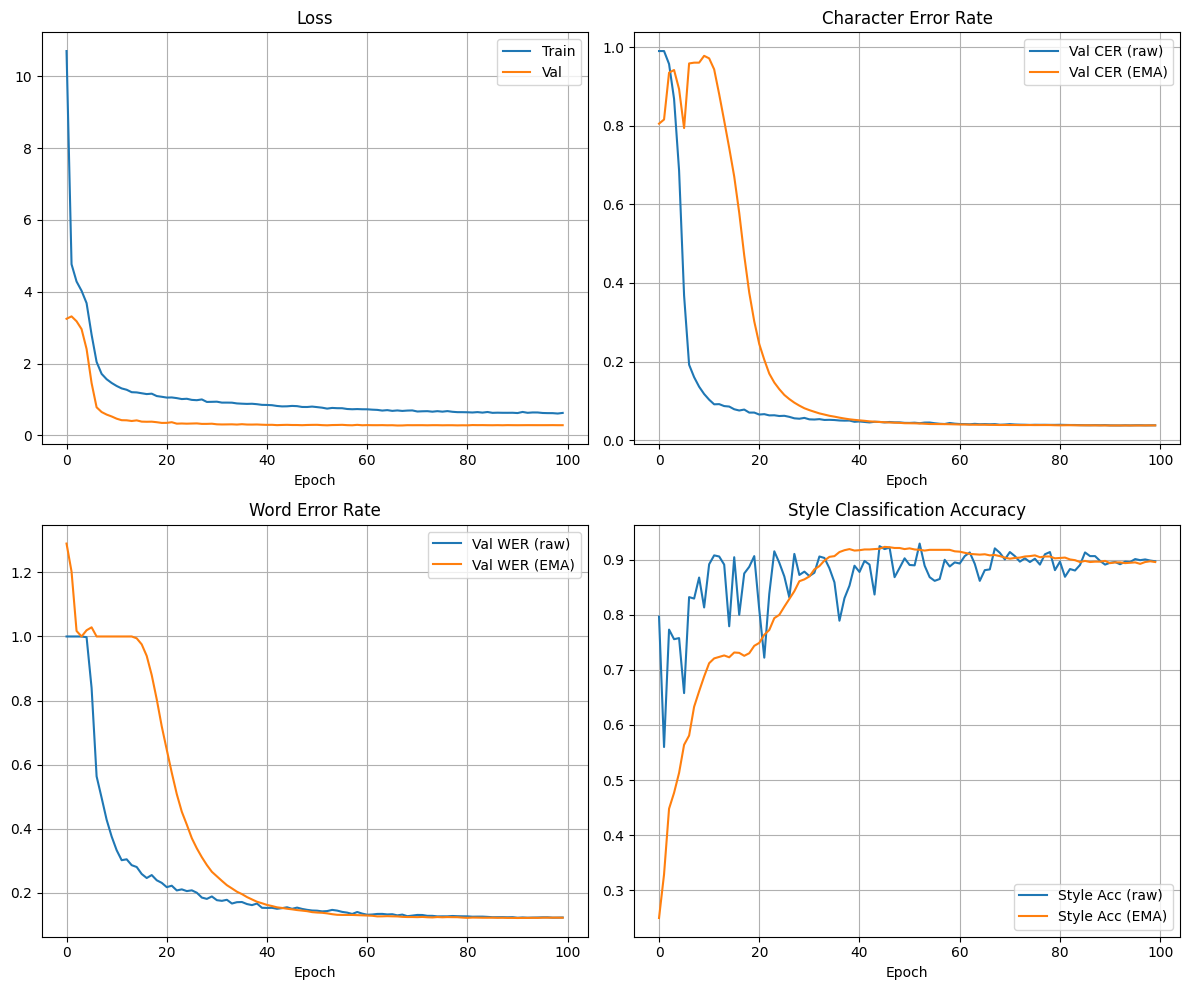


TEST EVALUATION

TEST (Best EMA) — CER=0.0394 | WER=0.1276 | Style Acc=0.9116


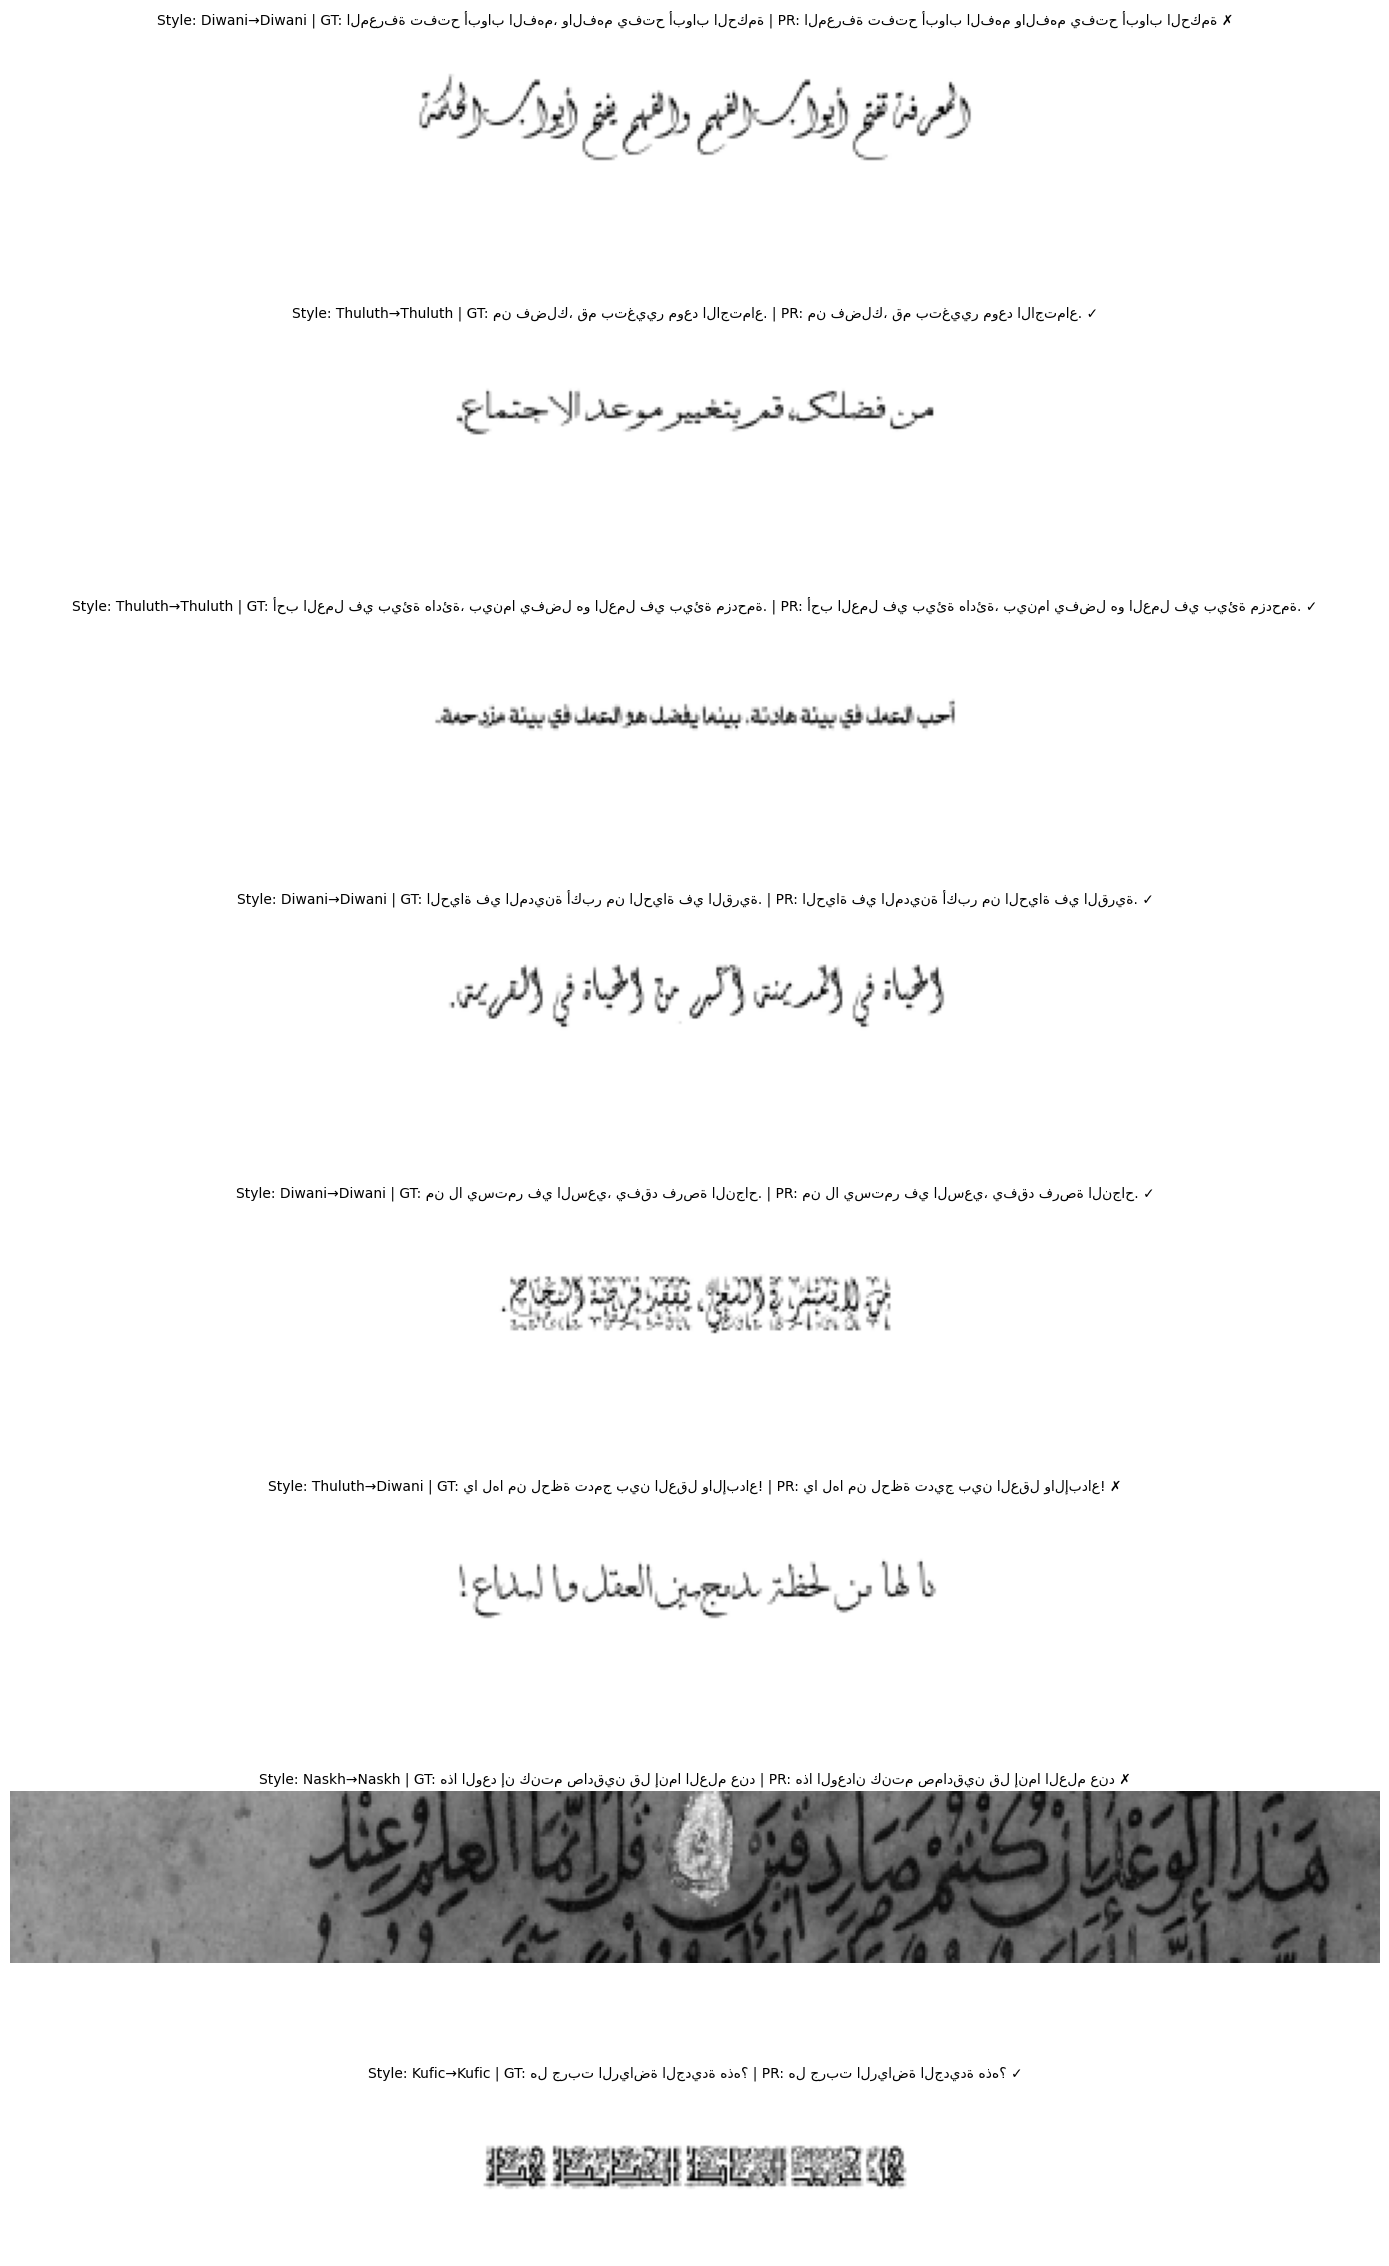


FINAL SUMMARY
Dataset = 14,928 images
Classes: 4 styles
Charset: 72 characters
Model parameters: 30,408,788

Best Validation CER (RAW): 0.0372
Best Validation CER (EMA): 0.0370

Test Metrics:
  - CER: 0.0394
  - WER: 0.1276
  - Style Accuracy: 0.9116

Checkpoints saved to: checkpoints
✅ December Run Complete!


In [ ]:
# %% DECEMBER RUNS v2 - Fixed Multi-Set OCR Pipeline (L4 GPU Optimized)
# ====================== Setup / Installs ======================
from google.colab import drive
drive.mount('/content/drive')

# Extract all 3 sets to local storage for faster I/O
import zipfile
import os



"""
DRIVE_BASE = "/content/drive/MyDrive/Full_Dataset/Complete_Dataset"
LOCAL_BASE = "/content/dataset"
os.makedirs(LOCAL_BASE, exist_ok=True)

for set_name in ["Set1", "Set2", "Set3", "Set4"]:
    zip_path = f"{DRIVE_BASE}/{set_name}.zip"
    extract_dir = f"{LOCAL_BASE}/{set_name}"
    if os.path.exists(zip_path):
        print(f"Extracting {set_name}...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(LOCAL_BASE)
        print(f"  ✓ {set_name} extracted to {extract_dir}")
    else:
        print(f"  ⚠ {zip_path} not found, skipping...")
"""


!pip -q install albumentations==1.4.7 editdistance==0.8.1 tqdm
!pip -q install "sympy<1.13"  # 🔧 fix torchvision ↔ sympy compatibility

# ====================== Imports ======================
import time, random, unicodedata, warnings, math, gc
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import albumentations as A
from torchvision import models

warnings.filterwarnings("ignore", category=UserWarning)
cv2.setNumThreads(0)

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

def human(n): return f"{n:,}"

# Use bfloat16 for better numerical stability (L4 supports it well)
def autocast_cuda():
    return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        t = torch.cuda.get_device_properties(0).total_memory/1e9
        return f"GPU: {a:.2f}/{r:.2f}/{t:.1f}GB"
    return "CPU"

# ====================== Data Paths ======================
LOCAL_BASE = Path("/content/dataset")
CSV_PATH = Path("/content/drive/MyDrive/Full_Dataset/Complete_Dataset/labels_fixed.csv")
assert CSV_PATH.exists(), f"CSV not found: {CSV_PATH}"
print(f"Labels CSV: {CSV_PATH}")

# ====================== Load & Merge All Sets ======================
df = pd.read_csv(CSV_PATH)
assert {'img_name', 'label', 'class'}.issubset(df.columns), f"Missing columns. Found: {df.columns.tolist()}"

def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df['label'] = df['label'].astype(str).apply(normalize_label)

# Build image paths based on Set prefix in img_name
def get_img_path(img_name):
    for set_num in [1, 2, 3, 4]:
        prefix = f"Set{set_num}_"
        if img_name.startswith(prefix):
            actual_name = img_name[len(prefix):]
            return str(LOCAL_BASE / f"Set{set_num}" / "images" / actual_name)
    for set_num in [1, 2, 3, 4]:
        path = LOCAL_BASE / f"Set{set_num}" / "images" / img_name
        if path.exists():
            return str(path)
    return None

df['img_path'] = df['img_name'].apply(get_img_path)

before_filter = len(df)
df = df[df['img_path'].apply(lambda p: p is not None and Path(p).exists())].reset_index(drop=True)
print(f"Images found: {human(len(df))} / {human(before_filter)} ({100*len(df)/before_filter:.1f}%)")

# ====================== Charset ======================
char_counts = Counter()
for s in df['label']:
    for ch in s:
        char_counts[ch] += 1

charset = ['<BLANK>'] + sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
char2idx = {c: i for i, c in enumerate(charset)}
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
print(f"Charset size (incl <BLANK>): {len(charset)}")

# ====================== Style Classes ======================
style_names = sorted(df['class'].fillna("Unknown").unique().tolist())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}
print(f"Styles ({len(style_names)}): {style_names}")

# ====================== Class Distribution Analysis ======================
print("\n" + "="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)
class_counts = df['class'].value_counts()
print(class_counts)
print(f"\nMax class: {class_counts.max()} | Min class: {class_counts.min()}")
print(f"Imbalance ratio: {class_counts.max() / class_counts.min():.2f}x")

# ====================== Encode Labels ======================
RTL_REVERSE = True

def encode_label(text, rtl_reverse=True):
    if rtl_reverse:
        text = text[::-1]
    ids = [char2idx[ch] for ch in text if ch in char2idx and ch != '<BLANK>']
    return ids

df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
before = len(df)
df = df[df['enc_len'] > 0].reset_index(drop=True)
print(f"Filtered empty labels: {human(before)} -> {human(len(df))}")

# ====================== Train/Val/Test Split ======================
train_df, test_df = train_test_split(
    df, test_size=0.10, random_state=SEED, stratify=df['class'].fillna("Unknown")
)
train_df, val_df = train_test_split(
    train_df, test_size=0.1111, random_state=SEED, stratify=train_df['class'].fillna("Unknown")
)
print(f"\nTrain: {human(len(train_df))} | Val: {human(len(val_df))} | Test: {human(len(test_df))}")

# ====================== Class Balancing - SMARTER APPROACH ======================
print("\n" + "="*60)
print("HANDLING CLASS IMBALANCE")
print("="*60)

train_class_counts = train_df['class'].value_counts()
# Use sqrt-based rebalancing instead of full equalization (less aggressive)
# This prevents oversampling tiny classes too much which causes instability
median_count = train_class_counts.median()
class_weights = {}
for cls, count in train_class_counts.items():
    # Sqrt scaling: minority classes get boosted but not to full parity
    weight = np.sqrt(median_count / count)
    weight = np.clip(weight, 1.0, 10.0)  # Cap maximum oversampling at 10x
    class_weights[cls] = weight

sample_weights = train_df['class'].map(class_weights).values
sample_weights = torch.DoubleTensor(sample_weights)

# Effective samples calculation
effective_per_class = {cls: int(count * class_weights[cls]) for cls, count in train_class_counts.items()}
effective_total = sum(effective_per_class.values())
print("Effective samples per class (sqrt-scaled, capped at 10x):")
for cls in style_names:
    orig = train_class_counts.get(cls, 0)
    eff = effective_per_class.get(cls, 0)
    w = class_weights.get(cls, 1.0)
    print(f"  {cls}: {orig} -> ~{eff} (weight={w:.2f}x)")
print(f"Total effective samples/epoch: {effective_total}")

# ====================== Image Processing ======================
H_TARGET = 64
W_MAX = 512
MEAN, STD = 0.5, 0.5
MIN_PX_PER_CHAR = 8

def decode_pred(indices, rtl_reverse=RTL_REVERSE):
    res, prev = [], None
    for idx in indices:
        if idx != BLANK_IDX and idx != prev:
            res.append(idx2char[idx])
        prev = idx
    s = "".join(res)
    return s[::-1] if rtl_reverse else s

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def pad_width_to_multiple(img, multiple=4, pad_value=255):
    h, w = img.shape
    pad_w = (multiple - (w % multiple)) % multiple
    if pad_w == 0:
        return img
    return cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=pad_value)

# ====================== Augmentations (moderate) ======================
AUG_P = 0.35

def stroke_thickness_jitter(img, p=0.5):
    if random.random() > p:
        return img
    k = random.choice([1, 1, 2])
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*k+1, 2*k+1))
    if random.random() < 0.5:
        img = cv2.erode(img, kernel, iterations=1)
    else:
        img = cv2.dilate(img, kernel, iterations=1)
    return img

def cutout_stripes(img, max_stripes=2, max_frac=0.10, p=0.3):
    if random.random() > p:
        return img
    h, w = img.shape
    n = random.randint(1, max_stripes)
    for _ in range(n):
        stripe_w = max(2, int(random.random() * max(3, w * max_frac)))
        x0 = random.randint(0, max(0, w - stripe_w))
        img[:, x0:x0+stripe_w] = 255
    return img

train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.MotionBlur(blur_limit=3, p=AUG_P * 0.7),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P * 0.8),
    A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.02, rotate_limit=3, border_mode=cv2.BORDER_REPLICATE, p=AUG_P * 0.8),
    A.CoarseDropout(max_holes=3, max_height=8, max_width=20, fill_value=255, p=AUG_P * 0.5),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P * 0.8),
])

def apply_train_aug(img):
    img = stroke_thickness_jitter(img, p=0.4)
    img = cutout_stripes(img, p=0.25)
    return train_aug(image=img)["image"]

# ====================== Dataset ======================
class OCRDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, training=True):
        self.df = frame.reset_index(drop=True)
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            # Return a dummy sample if image fails to load
            img = np.ones((H_TARGET, 64), dtype=np.uint8) * 255

        label_str = row['label']
        label_ids = encode_label(label_str, RTL_REVERSE)
        style_idx = style2idx[row['class']]

        img = resize_keep_ar_enforced(img, H_TARGET, label_len=len(label_ids))
        if self.training:
            img = apply_train_aug(img)
        img = pad_width_to_multiple(img, multiple=4, pad_value=255)

        img = img.astype(np.float32) / 255.0
        img = (img - MEAN) / STD
        img_t = torch.from_numpy(img)[None, ...]

        return img_t, torch.tensor(label_ids, dtype=torch.long), label_str, torch.tensor(style_idx), row['class'], img_t.shape[-1]

def collate_fn(batch):
    batch = sorted(batch, key=lambda x: x[-1], reverse=True)
    imgs, labels, label_strs, style_idxs, style_names_b, widths = zip(*batch)
    max_w = max(widths)
    bsz = len(imgs)
    padded = torch.full((bsz, 1, H_TARGET, max_w), (0.0 - MEAN) / STD, dtype=torch.float32)
    for i, im in enumerate(imgs):
        w = im.shape[-1]
        padded[i, :, :, :w] = im
    label_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels_concat = torch.cat(labels, dim=0) if len(labels) and sum(label_lens).item() > 0 else torch.tensor([], dtype=torch.long)
    return padded, labels_concat, label_lens, label_strs, torch.stack(style_idxs), style_names_b, torch.tensor(widths, dtype=torch.long)

# ====================== Model Architecture ======================
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)

try:
    _IMAGENET_WEIGHTS = models.ResNet34_Weights.IMAGENET1K_V1
except:
    _IMAGENET_WEIGHTS = "IMAGENET1K_V1"

class ResNet34OCRBackbone(nn.Module):
    """ResNet34 backbone adapted for OCR (preserves width dimension)."""
    def __init__(self, in_ch=1):
        super().__init__()
        try:
            m = models.resnet34(weights=_IMAGENET_WEIGHTS)
        except TypeError:
            m = models.resnet34(pretrained=True)

        with torch.no_grad():
            w = m.conv1.weight.data
            new_w = w.mean(dim=1, keepdim=True)
        m.conv1 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=(2, 1), padding=3, bias=False)
        with torch.no_grad():
            m.conv1.weight.copy_(new_w)

        m.maxpool = nn.MaxPool2d(kernel_size=3, stride=(2, 1), padding=1)

        def set_layer_height_only(layer):
            b0 = layer[0]
            b0.conv1.stride = (2, 1)
            if b0.downsample is not None and isinstance(b0.downsample, nn.Sequential):
                ds0 = b0.downsample[0]
                if isinstance(ds0, nn.Conv2d):
                    ds0.stride = (2, 1)

        set_layer_height_only(m.layer2)
        set_layer_height_only(m.layer3)
        set_layer_height_only(m.layer4)

        self.stem = nn.Sequential(m.conv1, m.bn1, m.relu, m.maxpool)
        self.layer1 = m.layer1
        self.layer2 = m.layer2
        self.layer3 = m.layer3
        self.layer4 = m.layer4
        self.out = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        fmap = x
        seq = self.out(fmap).squeeze(2).permute(2, 0, 1)
        return seq, fmap

class TemporalGLUBlock(nn.Module):
    """Temporal convolution with GLU gating."""
    def __init__(self, c=512, k=5, dilation=1, p=0.1):
        super().__init__()
        pad = (k - 1) // 2 * dilation
        self.conv = nn.Conv1d(c, 2 * c, kernel_size=k, padding=pad, dilation=dilation)
        self.glu = nn.GLU(dim=1)
        self.drop = nn.Dropout(p)
        self.res = nn.Conv1d(c, c, kernel_size=1)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        y = self.glu(self.conv(x))
        y = self.drop(y) + self.res(x)
        return y.permute(2, 0, 1)

class BiLSTMStack(nn.Module):
    """Stacked bidirectional LSTM."""
    def __init__(self, in_dim, hidden=256, num_layers=2, dropout=0.25):
        super().__init__()
        layers = []
        for i in range(num_layers):
            inp = in_dim if i == 0 else hidden * 2
            layers.append(nn.LSTM(inp, hidden, bidirectional=True, batch_first=False))
            layers.append(nn.Dropout(dropout))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for i in range(0, len(self.layers), 2):
            x, _ = self.layers[i](x)
            x = self.layers[i + 1](x)
        return x

class OCR_MultiTask_V3(nn.Module):
    """
    Improved OCR model:
    - ResNet34 backbone
    - TCN blocks for temporal modeling
    - BiLSTM sequence model
    - Auxiliary CTC head
    - Style classification head
    """
    def __init__(self, num_chars, num_styles, blank_idx=0, aux_weight=0.3):
        super().__init__()
        self.backbone = ResNet34OCRBackbone(in_ch=1)

        # Temporal modeling
        self.tcn1 = TemporalGLUBlock(512, k=5, dilation=1, p=0.1)
        self.tcn2 = TemporalGLUBlock(512, k=5, dilation=2, p=0.1)

        # BiLSTM
        self.lstm = BiLSTMStack(in_dim=512, hidden=256, num_layers=2, dropout=0.25)

        # CTC heads
        self.ctc_head_main = nn.Linear(512, num_chars)
        self.ctc_head_aux = nn.Linear(512, num_chars)

        # Style classification
        self.style_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(512, max(256, num_styles * 4)), nn.ReLU(True),
            nn.Linear(max(256, num_styles * 4), num_styles)
        )

        self.blank_idx = blank_idx
        self.aux_weight = aux_weight

        # Initialize CTC head biases
        with torch.no_grad():
            self.ctc_head_main.bias.zero_()
            self.ctc_head_main.bias[blank_idx] = -2.0
            self.ctc_head_aux.bias.zero_()
            self.ctc_head_aux.bias[blank_idx] = -2.0

    def forward(self, x):
        seq_feats, fmap = self.backbone(x)

        # TCN
        tcn_out = self.tcn2(self.tcn1(seq_feats))

        # BiLSTM
        lstm_out = self.lstm(tcn_out)

        # CTC outputs
        ctc_logits_main = self.ctc_head_main(lstm_out)
        ctc_logits_aux = self.ctc_head_aux(tcn_out)

        # Style classification (detach to reduce gradient conflict)
        style_logits = self.style_head(fmap.detach())

        return ctc_logits_main, ctc_logits_aux, style_logits

# ====================== Training Configuration (L4 Optimized) ======================
# INCREASED batch size to better utilize L4's 23.8GB VRAM
BATCH_SIZE = 128  # Increased from 96
EPOCHS = 100
INIT_LR_HEAD = 8e-4
INIT_LR_BB = 2e-4
WEIGHT_DECAY = 1e-4
MAX_NORM = 5.0  # More relaxed gradient clipping
LAMBDA_CLS = 0.2
AUX_CTC_WEIGHT = 0.3

# Sampler with effective samples
sampler = WeightedRandomSampler(sample_weights, num_samples=effective_total, replacement=True)

# ====================== Dataloaders ======================
train_ds = OCRDataset(train_df, training=True)
val_ds = OCRDataset(val_df, training=False)
test_ds = OCRDataset(test_df, training=False)

NUM_WORKERS = 4
loader_kwargs = dict(collate_fn=collate_fn, pin_memory=True, num_workers=NUM_WORKERS, persistent_workers=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, **loader_kwargs)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, **loader_kwargs)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, **loader_kwargs)

print(f"Train loader: {len(train_loader)} batches (with balanced sampling)")
print(f"Val loader: {len(val_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

# ====================== Model & Optimizer ======================
num_chars = len(charset)
num_styles = len(style_names)
model = OCR_MultiTask_V3(num_chars, num_styles, blank_idx=BLANK_IDX, aux_weight=AUX_CTC_WEIGHT).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {human(total_params)}")
print(f"Trainable parameters: {human(trainable_params)}")

ctc_loss_fn = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True)
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)

# Parameter groups
bb_params = list(model.backbone.parameters())
mid_params = list(model.tcn1.parameters()) + list(model.tcn2.parameters()) + list(model.lstm.parameters())
head_params = list(model.ctc_head_main.parameters()) + list(model.ctc_head_aux.parameters()) + list(model.style_head.parameters())

optimizer = torch.optim.AdamW([
    {"params": bb_params, "lr": INIT_LR_BB},
    {"params": mid_params, "lr": INIT_LR_HEAD},
    {"params": head_params, "lr": INIT_LR_HEAD}
], weight_decay=WEIGHT_DECAY)

# CosineAnnealing - more stable than OneCycleLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# GradScaler with growth interval to prevent NaN
scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE == "cuda"), growth_interval=2000)

# ====================== EMA ======================
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items()}

    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v, alpha=1.0 - self.decay)
            else:
                self.shadow[k] = v.clone()

    def apply_to(self, model):
        self._backup = {k: v.clone() for k, v in model.state_dict().items()}
        model.load_state_dict(self.shadow, strict=False)

    def restore(self, model):
        model.load_state_dict(self._backup, strict=False)
        del self._backup

ema = EMA(model, decay=0.999)

# ====================== Metrics ======================
def cer(ref, hyp):
    return 0.0 if (len(ref) == 0 and len(hyp) == 0) else editdistance.eval(ref, hyp) / max(1, len(ref))

def wer(ref, hyp):
    r, h = ref.split(), hyp.split()
    return 0.0 if (len(r) == 0 and len(h) == 0) else editdistance.eval(r, h) / max(1, len(r))

def ctc_time_lengths(widths):
    return torch.clamp(widths, min=1)

@torch.no_grad()
def greedy_decode_ctc(logits, out_lens):
    max_idxs = logits.softmax(dim=-1).argmax(dim=-1)
    T, B = max_idxs.shape
    dec = []
    for b in range(B):
        L = int(out_lens[b])
        seq = max_idxs[:L, b].tolist()
        dec.append(decode_pred(seq))
    return dec

# ====================== Evaluation ======================
@torch.no_grad()
def evaluate(model, loader, use_ema=False):
    if use_ema:
        ema.apply_to(model)
    model.eval()

    tot_loss = tot_cer = tot_wer = 0.0
    cnt = 0
    cls_correct = cls_total = 0

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in loader:
        imgs = imgs.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)

        with autocast_cuda():
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)

        if len(labels_concat) > 0:
            loss_ctc = ctc_loss_fn(log_probs_main.float(), labels_concat.to(DEVICE), input_lens, label_lens.to(DEVICE))
        else:
            loss_ctc = torch.tensor(0., device=DEVICE)
        loss_cls = cls_loss_fn(style_logits, style_idxs)
        loss = loss_ctc + LAMBDA_CLS * loss_cls

        B = imgs.size(0)
        tot_loss += loss.item() * B
        cnt += B

        preds = greedy_decode_ctc(ctc_logits_main, input_lens)
        for gt, pr in zip(label_strs, preds):
            tot_cer += cer(gt, pr)
            tot_wer += wer(gt, pr)

        pred_style = style_logits.argmax(dim=1)
        cls_correct += (pred_style == style_idxs).sum().item()
        cls_total += B

    if use_ema:
        ema.restore(model)

    return {
        "loss": tot_loss / cnt if cnt else None,
        "cer": tot_cer / cnt if cnt else None,
        "wer": tot_wer / cnt if cnt else None,
        "style_acc": cls_correct / cls_total if cls_total > 0 else None
    }

# ====================== Training Loop ======================
print("\n" + "="*60)
print("TRAINING")
print("="*60)

SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH = SAVE_DIR / "ocr_december_best.pt"
BEST_EMA_PATH = SAVE_DIR / "ocr_december_best_ema.pt"

history = {
    "train_loss": [], "val_loss": [],
    "val_cer_raw": [], "val_cer_ema": [],
    "val_wer_raw": [], "val_wer_ema": [],
    "val_style_acc_raw": [], "val_style_acc_ema": []
}

best_cer_raw = float('inf')
best_cer_ema = float('inf')

# Freeze backbone for warmup
for p in model.backbone.parameters():
    p.requires_grad = False
print("Backbone frozen for warmup epoch.")

steps_per_epoch = len(train_loader)
print(f"\n[Training] Epochs={EPOCHS}, Batch={BATCH_SIZE}, Steps/epoch={steps_per_epoch}")
print(f"Device: {DEVICE} | {gpu_mem()}\n")

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    seen = 0
    nan_batches = 0
    t0 = time.time()

    # Unfreeze backbone after warmup
    if epoch == 2:
        for p in model.backbone.parameters():
            p.requires_grad = True
        print("Backbone unfrozen.")

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch:03d}", leave=False)
    for bidx, (imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths) in pbar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        style_idxs = style_idxs.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with autocast_cuda():
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)

            if len(labels_concat) > 0:
                loss_ctc_main = ctc_loss_fn(log_probs_main.float(), labels_concat.to(DEVICE), input_lens, label_lens.to(DEVICE))
                log_probs_aux = ctc_logits_aux.log_softmax(2)
                loss_ctc_aux = ctc_loss_fn(log_probs_aux.float(), labels_concat.to(DEVICE), input_lens, label_lens.to(DEVICE))
            else:
                loss_ctc_main = torch.tensor(0., device=DEVICE)
                loss_ctc_aux = torch.tensor(0., device=DEVICE)

            loss_cls = cls_loss_fn(style_logits, style_idxs)
            loss = loss_ctc_main + AUX_CTC_WEIGHT * loss_ctc_aux + LAMBDA_CLS * loss_cls

        # Check for NaN and skip batch if needed
        if torch.isnan(loss) or torch.isinf(loss):
            nan_batches += 1
            scaler.update()  # Still update scaler to adjust scale
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
        scaler.step(optimizer)
        scaler.update()
        ema.update(model)

        running += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix(loss=f"{loss.item():.3f}", avg=f"{running/max(1,seen):.3f}")

    scheduler.step()
    train_loss = running / max(1, seen) if seen > 0 else float('nan')
    history["train_loss"].append(train_loss)

    if nan_batches > 0:
        print(f"  Warning: {nan_batches} batches skipped due to NaN loss")

    # Validation
    val_raw = evaluate(model, val_loader, use_ema=False)
    val_ema = evaluate(model, val_loader, use_ema=True)

    history["val_loss"].append(val_raw["loss"])
    history["val_cer_raw"].append(val_raw["cer"])
    history["val_cer_ema"].append(val_ema["cer"])
    history["val_wer_raw"].append(val_raw["wer"])
    history["val_wer_ema"].append(val_ema["wer"])
    history["val_style_acc_raw"].append(val_raw["style_acc"])
    history["val_style_acc_ema"].append(val_ema["style_acc"])

    dt = time.time() - t0
    print(f"Epoch {epoch:03d}/{EPOCHS} | train={train_loss:.3f} | "
          f"val_raw: CER={val_raw['cer']:.4f} WER={val_raw['wer']:.4f} style={val_raw['style_acc']:.3f} | "
          f"val_EMA: CER={val_ema['cer']:.4f} WER={val_ema['wer']:.4f} style={val_ema['style_acc']:.3f} | "
          f"{dt:.1f}s | {gpu_mem()}")

    # Save best RAW model
    if val_raw["cer"] is not None and val_raw["cer"] < best_cer_raw:
        best_cer_raw = val_raw["cer"]
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "charset": charset,
            "style_names": style_names,
            "config": {"H_TARGET": H_TARGET, "RTL_REVERSE": RTL_REVERSE},
            "metrics": val_raw
        }, BEST_PATH)
        print(f"  ✓ New best RAW CER={best_cer_raw:.4f} saved to {BEST_PATH}")

    # Save best EMA model
    if val_ema["cer"] is not None and val_ema["cer"] < best_cer_ema:
        best_cer_ema = val_ema["cer"]
        ema.apply_to(model)
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "charset": charset,
            "style_names": style_names,
            "config": {"H_TARGET": H_TARGET, "RTL_REVERSE": RTL_REVERSE},
            "metrics": val_ema
        }, BEST_EMA_PATH)
        ema.restore(model)
        print(f"  ✓ New best EMA CER={best_cer_ema:.4f} saved to {BEST_EMA_PATH}")

    # Memory cleanup every 10 epochs
    if epoch % 10 == 0:
        gc.collect()
        torch.cuda.empty_cache()

print("\n[Training] Complete!")
print(f"Best RAW CER: {best_cer_raw:.4f}")
print(f"Best EMA CER: {best_cer_ema:.4f}")

# ====================== Training Curves ======================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history["train_loss"], label="Train")
axes[0, 0].plot(history["val_loss"], label="Val")
axes[0, 0].set_title("Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history["val_cer_raw"], label="Val CER (raw)")
axes[0, 1].plot(history["val_cer_ema"], label="Val CER (EMA)")
axes[0, 1].set_title("Character Error Rate")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history["val_wer_raw"], label="Val WER (raw)")
axes[1, 0].plot(history["val_wer_ema"], label="Val WER (EMA)")
axes[1, 0].set_title("Word Error Rate")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history["val_style_acc_raw"], label="Style Acc (raw)")
axes[1, 1].plot(history["val_style_acc_ema"], label="Style Acc (EMA)")
axes[1, 1].set_title("Style Classification Accuracy")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(SAVE_DIR / "training_curves.png", dpi=150)
plt.show()

# ====================== Test Evaluation ======================
print("\n" + "="*60)
print("TEST EVALUATION")
print("="*60)

ckpt = torch.load(BEST_EMA_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"], strict=False)
model.eval()

test_metrics = evaluate(model, test_loader, use_ema=False)
print(f"\nTEST (Best EMA) — CER={test_metrics['cer']:.4f} | WER={test_metrics['wer']:.4f} | "
      f"Style Acc={test_metrics['style_acc']:.4f}")

# ====================== Qualitative Samples ======================
@torch.no_grad()
def show_samples(model, loader, k=8):
    model.eval()
    imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths = next(iter(loader))
    imgs = imgs.to(DEVICE)

    ctc_logits_main, _, style_logits = model(imgs)
    preds = greedy_decode_ctc(ctc_logits_main, ctc_time_lengths(widths))
    style_pred = style_logits.softmax(1).argmax(1).cpu().tolist()

    fig, axes = plt.subplots(k, 1, figsize=(14, 3*k))
    for i in range(min(k, imgs.size(0))):
        im = imgs[i, 0].cpu().numpy()
        im = np.clip(im * STD + MEAN, 0, 1)

        gt_style = style_names_b[i]
        pr_style = idx2style[style_pred[i]]
        gt_text = label_strs[i]
        pr_text = preds[i]
        match = "✓" if gt_text == pr_text else "✗"

        axes[i].imshow(im, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Style: {gt_style}→{pr_style} | GT: {gt_text} | PR: {pr_text} {match}", fontsize=10)

    plt.tight_layout()
    plt.savefig(SAVE_DIR / "sample_predictions.png", dpi=150)
    plt.show()

show_samples(model, test_loader, k=8)

# ====================== Final Summary ======================
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Dataset = {human(len(df))} images")
print(f"Classes: {len(style_names)} styles")
print(f"Charset: {len(charset)} characters")
print(f"Model parameters: {human(total_params)}")
print(f"\nBest Validation CER (RAW): {best_cer_raw:.4f}")
print(f"Best Validation CER (EMA): {best_cer_ema:.4f}")
print(f"\nTest Metrics:")
print(f"  - CER: {test_metrics['cer']:.4f}")
print(f"  - WER: {test_metrics['wer']:.4f}")
print(f"  - Style Accuracy: {test_metrics['style_acc']:.4f}")
print(f"\nCheckpoints saved to: {SAVE_DIR}")
print("✅ December Run Complete!")

## RESULTS VISUALIZATION


DETAILED VISUAL ANALYSIS (TEST SET)


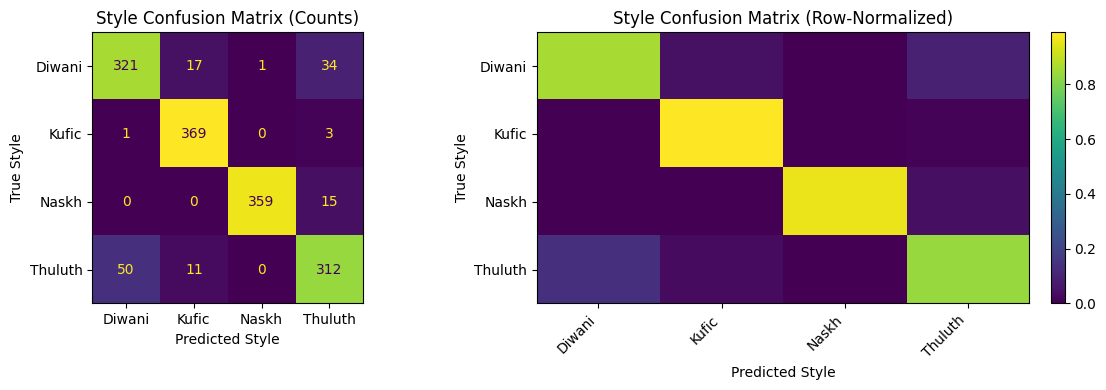

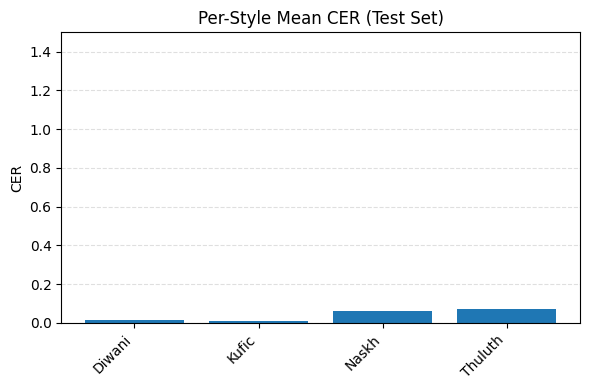

Per-style mean CER:
  Diwani     -> 0.0159
  Kufic      -> 0.0078
  Naskh      -> 0.0623
  Thuluth    -> 0.0713


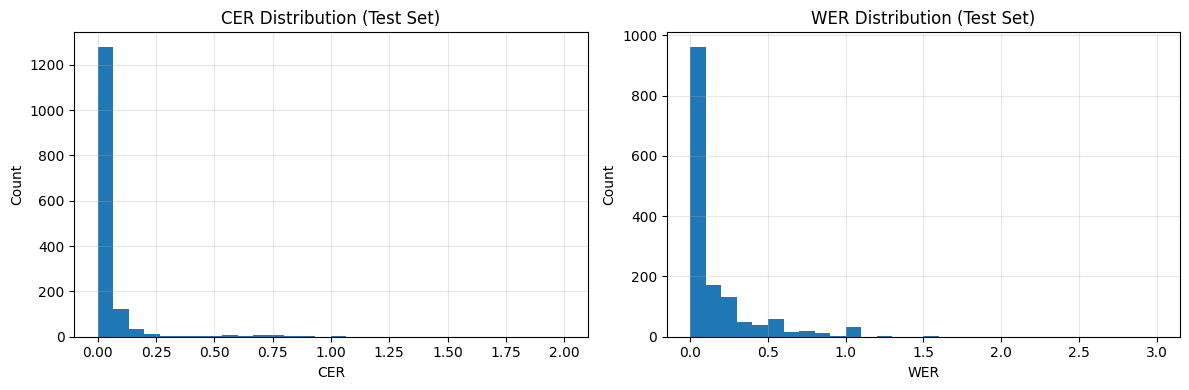

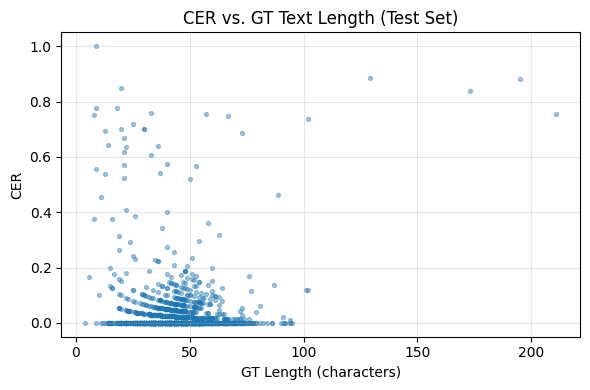


Summary (Test Set Distributions):
  CER  -> mean=0.0394, median=0.0000
  WER  -> mean=0.1276, median=0.0000
  Len  -> mean=45.17, median=44.00
✅ Visual analysis complete (saved in checkpoints/).


In [ ]:
# %% VISUAL ANALYSIS: CONFUSION MATRIX & ERROR DISTRIBUTIONS (DECEMBER RUN v2)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("\n" + "="*60)
print("DETAILED VISUAL ANALYSIS (TEST SET)")
print("="*60)

@torch.no_grad()
def collect_test_stats(model, loader):
    model.eval()
    all_style_true = []
    all_style_pred = []
    cer_list = []
    wer_list = []
    len_list = []
    examples = []  # (img, gt, pred, style_gt, style_pred)

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in loader:
        imgs = imgs.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)

        # Forward
        with autocast_cuda():
            ctc_logits_main, _, style_logits = model(imgs)

        preds = greedy_decode_ctc(ctc_logits_main, input_lens)
        style_hat = style_logits.argmax(dim=1)

        for i in range(len(label_strs)):
            gt = label_strs[i]
            pr = preds[i]

            c = cer(gt, pr)
            w = wer(gt, pr)
            cer_list.append(c)
            wer_list.append(w)
            len_list.append(len(gt))

            s_true = int(style_idxs[i].item())
            s_pred = int(style_hat[i].item())
            all_style_true.append(s_true)
            all_style_pred.append(s_pred)

            if len(examples) < 50:  # keep a few for possible later inspection
                examples.append({
                    "img": imgs[i, 0].detach().cpu().numpy(),
                    "gt": gt,
                    "pred": pr,
                    "style_true": idx2style[s_true],
                    "style_pred": idx2style[s_pred],
                    "cer": c,
                    "wer": w,
                })

    stats = {
        "style_true": all_style_true,
        "style_pred": all_style_pred,
        "cer": np.array(cer_list),
        "wer": np.array(wer_list),
        "lengths": np.array(len_list),
        "examples": examples,
    }
    return stats

stats = collect_test_stats(model, test_loader)

# ---------- STYLE CONFUSION MATRIX ----------
cm = confusion_matrix(
    stats["style_true"],
    stats["style_pred"],
    labels=list(range(len(style_names)))
)

fig_cm, ax_cm = plt.subplots(1, 2, figsize=(12, 4))

# Raw counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=style_names)
disp.plot(ax=ax_cm[0], colorbar=False)
ax_cm[0].set_title("Style Confusion Matrix (Counts)")
ax_cm[0].set_xlabel("Predicted Style")
ax_cm[0].set_ylabel("True Style")

# Row-normalized
cm_norm = cm.astype(np.float32)
cm_norm = cm_norm / cm_norm.sum(axis=1, keepdims=True).clip(min=1)

im = ax_cm[1].imshow(cm_norm, aspect='auto')
ax_cm[1].set_xticks(range(len(style_names)))
ax_cm[1].set_yticks(range(len(style_names)))
ax_cm[1].set_xticklabels(style_names, rotation=45, ha='right')
ax_cm[1].set_yticklabels(style_names)
ax_cm[1].set_title("Style Confusion Matrix (Row-Normalized)")
ax_cm[1].set_xlabel("Predicted Style")
ax_cm[1].set_ylabel("True Style")
fig_cm.colorbar(im, ax=ax_cm[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(SAVE_DIR / "style_confusion_matrix.png", dpi=150)
plt.show()

# ---------- PER-STYLE MEAN CER ----------
style_cer = {s: [] for s in style_names}
for s_idx, c in zip(stats["style_true"], stats["cer"]):
    style_cer[idx2style[s_idx]].append(c)

style_mean_cer = {s: (np.mean(v) if len(v) > 0 else np.nan)
                  for s, v in style_cer.items()}

fig_style, ax_style = plt.subplots(figsize=(6, 4))
ax_style.bar(list(style_mean_cer.keys()), list(style_mean_cer.values()))
ax_style.set_title("Per-Style Mean CER (Test Set)")
ax_style.set_ylabel("CER")
ax_style.set_ylim(0, 1.5)
for tick in ax_style.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')
ax_style.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(SAVE_DIR / "per_style_cer.png", dpi=150)
plt.show()

print("Per-style mean CER:")
for s, v in style_mean_cer.items():
    print(f"  {s:10s} -> {v:.4f}")

# ---------- CER / WER HISTOGRAMS ----------
fig_hist, axes_hist = plt.subplots(1, 2, figsize=(12, 4))

axes_hist[0].hist(stats["cer"], bins=30, range=(0, 2.0))
axes_hist[0].set_title("CER Distribution (Test Set)")
axes_hist[0].set_xlabel("CER")
axes_hist[0].set_ylabel("Count")
axes_hist[0].grid(alpha=0.3)

axes_hist[1].hist(stats["wer"], bins=30, range=(0, 3.0))
axes_hist[1].set_title("WER Distribution (Test Set)")
axes_hist[1].set_xlabel("WER")
axes_hist[1].set_ylabel("Count")
axes_hist[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(SAVE_DIR / "cer_wer_histograms.png", dpi=150)
plt.show()

# ---------- CER vs WORD LENGTH ----------
fig_len, ax_len = plt.subplots(figsize=(6, 4))
ax_len.scatter(stats["lengths"], stats["cer"], s=8, alpha=0.4)
ax_len.set_title("CER vs. GT Text Length (Test Set)")
ax_len.set_xlabel("GT Length (characters)")
ax_len.set_ylabel("CER")
ax_len.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(SAVE_DIR / "cer_vs_length.png", dpi=150)
plt.show()

print("\nSummary (Test Set Distributions):")
print(f"  CER  -> mean={stats['cer'].mean():.4f}, median={np.median(stats['cer']):.4f}")
print(f"  WER  -> mean={stats['wer'].mean():.4f}, median={np.median(stats['wer']):.4f}")
print(f"  Len  -> mean={stats['lengths'].mean():.2f}, median={np.median(stats['lengths']):.2f}")
print("✅ Visual analysis complete (saved in checkpoints/).")


## BETTER VISUALIZATION FOR OPTIMAL MODEL

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  ✓ Set1 already extracted
  ✓ Set2 already extracted
  ✓ Set3 already extracted
  ✓ Set4 already extracted
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 10.3 MB/s eta 0:00:00
Device: cuda
GPU: NVIDIA L4
Total VRAM: 23.8 GB
Labels CSV: /content/drive/MyDrive/Full_Dataset/Complete_Dataset/labels_fixed.csv
Images found: 14,928 / 14,932 (100.0%)
Charset size (incl <BLANK>): 72
Styles (4): ['Diwani', 'Kufic', 'Naskh', 'Thuluth']
Filtered empty labels: 14,928 -> 14,928

Test set: 1,493 images

LOADING PRETRAINED MODEL
✓ Model loaded from: /content/checkpoints/ocr_december_best.pt
  Checkpoint metrics: {'loss': 0.28249500229785046, 'cer': 0.03715593418605404, 'wer': 0.12157543283657629, 'style_acc': 0.8914936369725385}
Test loader: 24 batches

TEST EVALUATION


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]


TEST RESULTS:
  - CER: 0.0393
  - WER: 0.1283
  - Style Accuracy: 0.9062

SAMPLE PREDICTIONS (Proper Arabic Display)


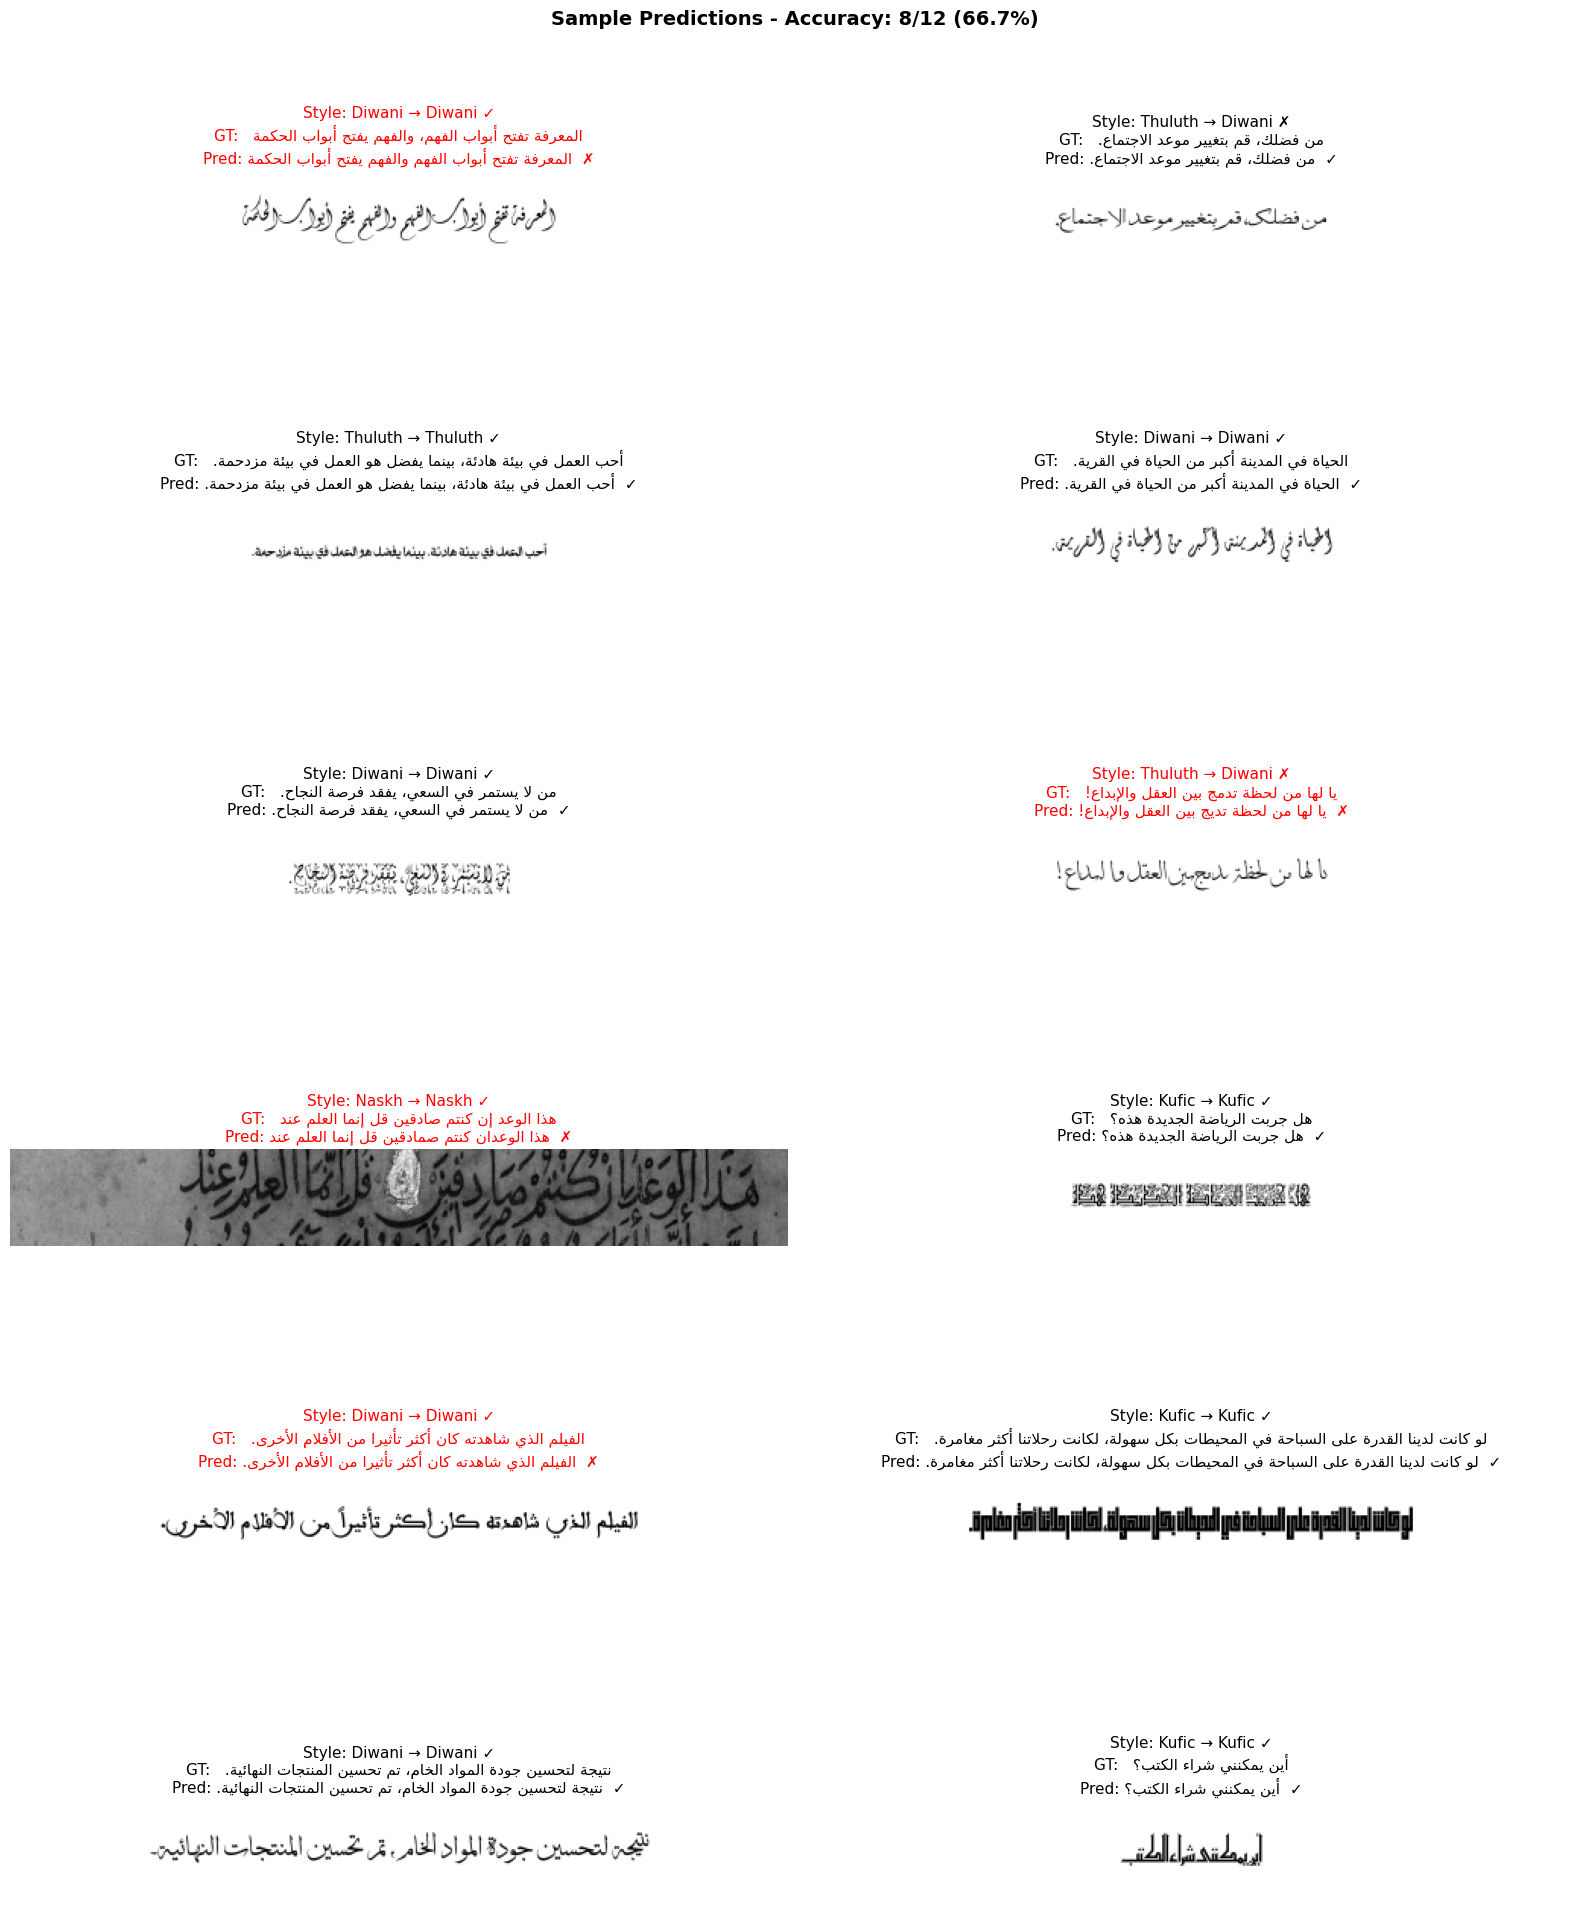


✓ Saved to /content/sample_predictions_arabic.png
  Sample accuracy: 8/12 (66.7%)

PER-CLASS ANALYSIS


Per-class eval:   0%|          | 0/24 [00:00<?, ?it/s]


Class                CER        WER        Style Acc    Samples   
--------------------------------------------------------------
Diwani               0.0157     0.0476     0.8954       373       
Kufic                0.0080     0.0283     0.9839       373       
Naskh                0.0638     0.2839     0.9599       374       
Thuluth              0.0695     0.1528     0.7855       373       

RANDOM SAMPLES FROM EACH CLASS


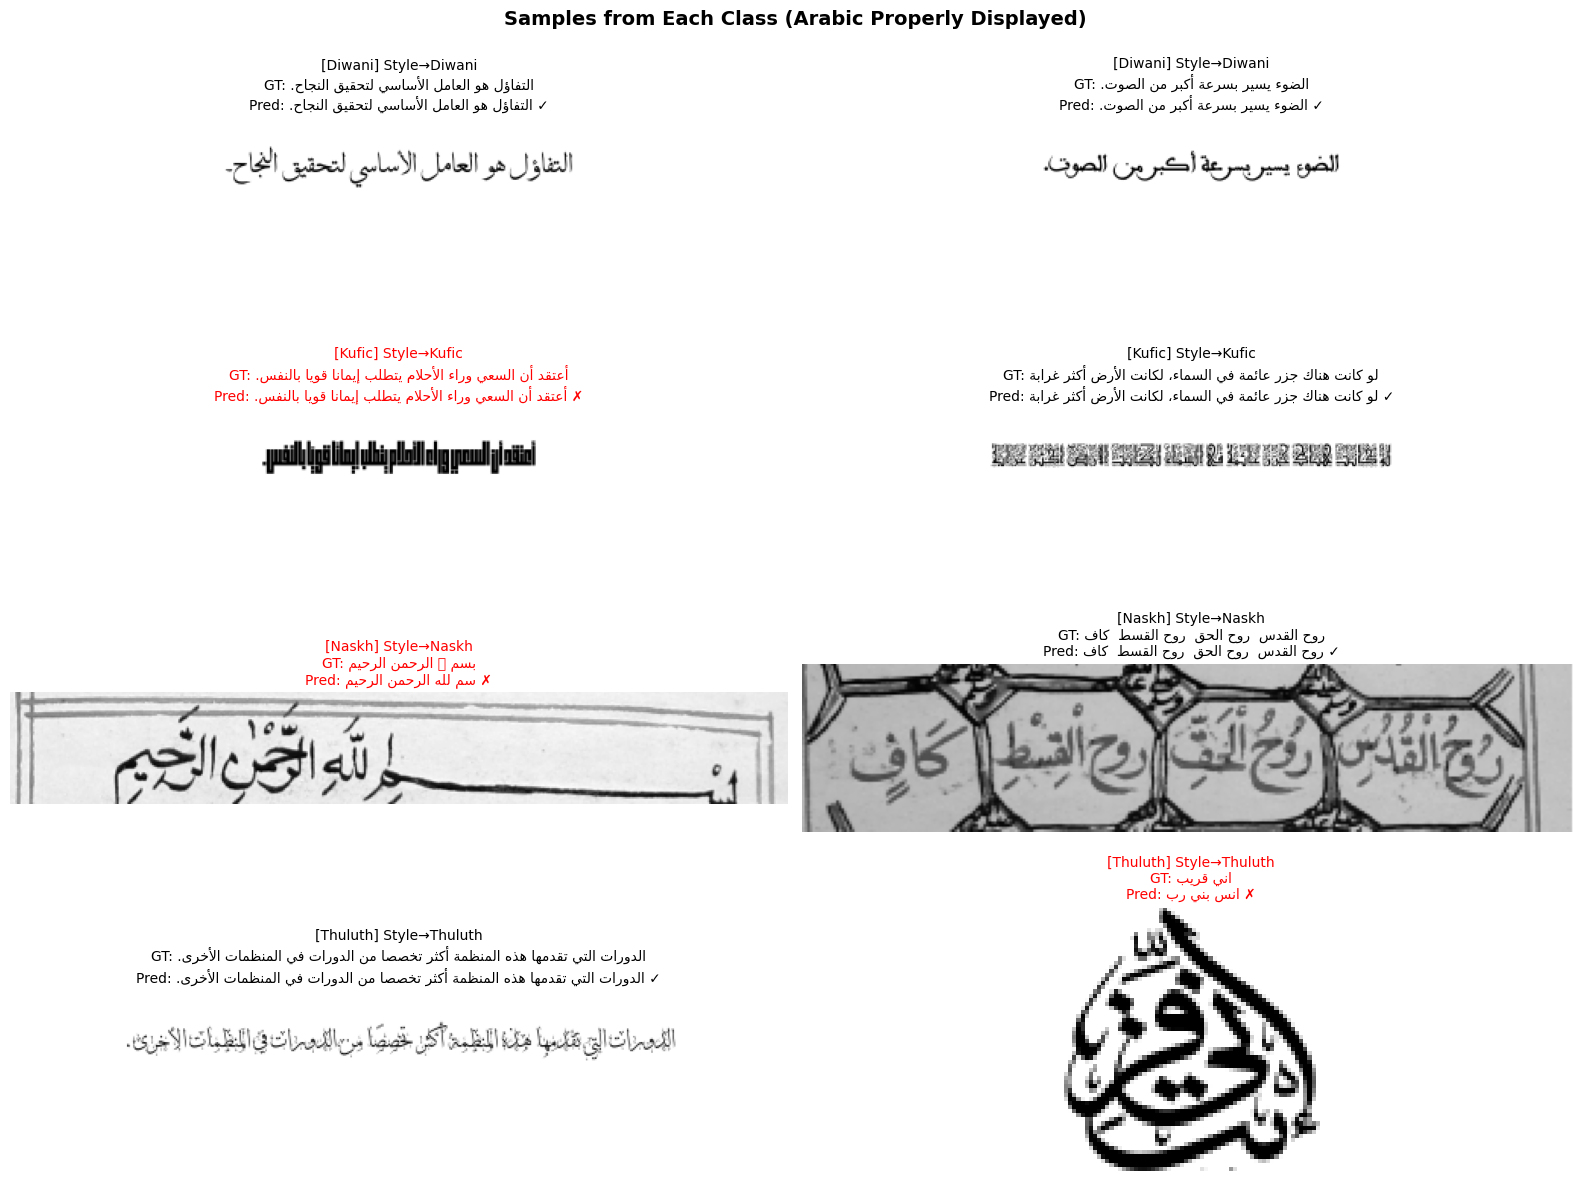


✓ Saved to /content/class_samples_arabic.png

✅ EVALUATION COMPLETE!


In [ ]:
# %% BASELINE EVALUATION - Arabic Text Display Fixed
# ====================== Setup / Installs ======================
from google.colab import drive
drive.mount('/content/drive')

# Extract all 3 sets to local storage for faster I/O
import zipfile
import os

DRIVE_BASE = "/content/drive/MyDrive/Full_Dataset/Complete_Dataset"
LOCAL_BASE = "/content/dataset"
os.makedirs(LOCAL_BASE, exist_ok=True)

for set_name in ["Set1", "Set2", "Set3", "Set4"]:
    zip_path = f"{DRIVE_BASE}/{set_name}.zip"
    extract_dir = f"{LOCAL_BASE}/{set_name}"
    if not os.path.exists(extract_dir):  # Only extract if not already done
        if os.path.exists(zip_path):
            print(f"Extracting {set_name}...")
            with zipfile.ZipFile(zip_path, 'r') as zf:
                zf.extractall(LOCAL_BASE)
            print(f"  ✓ {set_name} extracted to {extract_dir}")
        else:
            print(f"  ⚠ {zip_path} not found, skipping...")
    else:
        print(f"  ✓ {set_name} already extracted")

!pip -q install albumentations==1.4.7 editdistance==0.8.1 tqdm arabic-reshaper python-bidi

# ====================== Imports ======================
import time, random, unicodedata, warnings, math, gc
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import albumentations as A
from torchvision import models

# Arabic text display imports
import arabic_reshaper
from bidi.algorithm import get_display

warnings.filterwarnings("ignore", category=UserWarning)
cv2.setNumThreads(0)

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

def human(n): return f"{n:,}"

def autocast_cuda():
    return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

# ====================== Data Paths ======================
LOCAL_BASE = Path("/content/dataset")
CSV_PATH = Path("/content/drive/MyDrive/Full_Dataset/Complete_Dataset/labels_fixed.csv")
assert CSV_PATH.exists(), f"CSV not found: {CSV_PATH}"
print(f"Labels CSV: {CSV_PATH}")

# ====================== Load & Merge All Sets ======================
df = pd.read_csv(CSV_PATH)
assert {'img_name', 'label', 'class'}.issubset(df.columns), f"Missing columns. Found: {df.columns.tolist()}"

def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df['label'] = df['label'].astype(str).apply(normalize_label)

# Build image paths based on Set prefix in img_name
def get_img_path(img_name):
    for set_num in [1, 2, 3, 4]:
        prefix = f"Set{set_num}_"
        if img_name.startswith(prefix):
            actual_name = img_name[len(prefix):]
            return str(LOCAL_BASE / f"Set{set_num}" / "images" / actual_name)
    for set_num in [1, 2, 3, 4]:
        path = LOCAL_BASE / f"Set{set_num}" / "images" / img_name
        if path.exists():
            return str(path)
    return None

df['img_path'] = df['img_name'].apply(get_img_path)

before_filter = len(df)
df = df[df['img_path'].apply(lambda p: p is not None and Path(p).exists())].reset_index(drop=True)
print(f"Images found: {human(len(df))} / {human(before_filter)} ({100*len(df)/before_filter:.1f}%)")

# ====================== Charset ======================
char_counts = Counter()
for s in df['label']:
    for ch in s:
        char_counts[ch] += 1

charset = ['<BLANK>'] + sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
char2idx = {c: i for i, c in enumerate(charset)}
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
print(f"Charset size (incl <BLANK>): {len(charset)}")

# ====================== Style Classes ======================
style_names = sorted(df['class'].fillna("Unknown").unique().tolist())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}
print(f"Styles ({len(style_names)}): {style_names}")

# ====================== Image Processing ======================
H_TARGET = 64
W_MAX = 512
MEAN, STD = 0.5, 0.5
MIN_PX_PER_CHAR = 8
RTL_REVERSE = True

def encode_label(text, rtl_reverse=True):
    if rtl_reverse:
        text = text[::-1]
    ids = [char2idx[ch] for ch in text if ch in char2idx and ch != '<BLANK>']
    return ids

df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
before = len(df)
df = df[df['enc_len'] > 0].reset_index(drop=True)
print(f"Filtered empty labels: {human(before)} -> {human(len(df))}")

# ====================== Decode with PROPER Arabic display ======================
def decode_pred(indices, rtl_reverse=RTL_REVERSE):
    """Decode CTC output indices to text."""
    res, prev = [], None
    for idx in indices:
        if idx != BLANK_IDX and idx != prev:
            res.append(idx2char[idx])
        prev = idx
    s = "".join(res)
    return s[::-1] if rtl_reverse else s

def format_arabic_for_display(text):
    """
    Format Arabic text for proper display:
    1. Reshape Arabic letters to connect properly
    2. Apply bidirectional algorithm for correct RTL display
    """
    try:
        # Reshape Arabic text (connects letters properly)
        reshaped = arabic_reshaper.reshape(text)
        # Apply bidi algorithm for correct display order
        display_text = get_display(reshaped)
        return display_text
    except:
        return text

# ====================== Test Split ======================
train_df, test_df = train_test_split(
    df, test_size=0.10, random_state=SEED, stratify=df['class'].fillna("Unknown")
)
print(f"\nTest set: {human(len(test_df))} images")

# ====================== Image Processing Functions ======================
def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def pad_width_to_multiple(img, multiple=4, pad_value=255):
    h, w = img.shape
    pad_w = (multiple - (w % multiple)) % multiple
    if pad_w == 0:
        return img
    return cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=pad_value)

# ====================== Dataset ======================
class OCRDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, training=False):
        self.df = frame.reset_index(drop=True)
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.ones((H_TARGET, 64), dtype=np.uint8) * 255

        label_str = row['label']
        label_ids = encode_label(label_str, RTL_REVERSE)
        style_idx = style2idx[row['class']]

        img = resize_keep_ar_enforced(img, H_TARGET, label_len=len(label_ids))
        img = pad_width_to_multiple(img, multiple=4, pad_value=255)

        img = img.astype(np.float32) / 255.0
        img = (img - MEAN) / STD
        img_t = torch.from_numpy(img)[None, ...]

        return img_t, torch.tensor(label_ids, dtype=torch.long), label_str, torch.tensor(style_idx), row['class'], img_t.shape[-1]

def collate_fn(batch):
    batch = sorted(batch, key=lambda x: x[-1], reverse=True)
    imgs, labels, label_strs, style_idxs, style_names_b, widths = zip(*batch)
    max_w = max(widths)
    bsz = len(imgs)
    padded = torch.full((bsz, 1, H_TARGET, max_w), (0.0 - MEAN) / STD, dtype=torch.float32)
    for i, im in enumerate(imgs):
        w = im.shape[-1]
        padded[i, :, :, :w] = im
    label_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels_concat = torch.cat(labels, dim=0) if len(labels) and sum(label_lens).item() > 0 else torch.tensor([], dtype=torch.long)
    return padded, labels_concat, label_lens, label_strs, torch.stack(style_idxs), style_names_b, torch.tensor(widths, dtype=torch.long)

# ====================== Model Architecture ======================
try:
    _IMAGENET_WEIGHTS = models.ResNet34_Weights.IMAGENET1K_V1
except:
    _IMAGENET_WEIGHTS = "IMAGENET1K_V1"

class ResNet34OCRBackbone(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        try:
            m = models.resnet34(weights=_IMAGENET_WEIGHTS)
        except TypeError:
            m = models.resnet34(pretrained=True)

        with torch.no_grad():
            w = m.conv1.weight.data
            new_w = w.mean(dim=1, keepdim=True)
        m.conv1 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=(2, 1), padding=3, bias=False)
        with torch.no_grad():
            m.conv1.weight.copy_(new_w)

        m.maxpool = nn.MaxPool2d(kernel_size=3, stride=(2, 1), padding=1)

        def set_layer_height_only(layer):
            b0 = layer[0]
            b0.conv1.stride = (2, 1)
            if b0.downsample is not None and isinstance(b0.downsample, nn.Sequential):
                ds0 = b0.downsample[0]
                if isinstance(ds0, nn.Conv2d):
                    ds0.stride = (2, 1)

        set_layer_height_only(m.layer2)
        set_layer_height_only(m.layer3)
        set_layer_height_only(m.layer4)

        self.stem = nn.Sequential(m.conv1, m.bn1, m.relu, m.maxpool)
        self.layer1 = m.layer1
        self.layer2 = m.layer2
        self.layer3 = m.layer3
        self.layer4 = m.layer4
        self.out = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        fmap = x
        seq = self.out(fmap).squeeze(2).permute(2, 0, 1)
        return seq, fmap

class TemporalGLUBlock(nn.Module):
    def __init__(self, c=512, k=5, dilation=1, p=0.1):
        super().__init__()
        pad = (k - 1) // 2 * dilation
        self.conv = nn.Conv1d(c, 2 * c, kernel_size=k, padding=pad, dilation=dilation)
        self.glu = nn.GLU(dim=1)
        self.drop = nn.Dropout(p)
        self.res = nn.Conv1d(c, c, kernel_size=1)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        y = self.glu(self.conv(x))
        y = self.drop(y) + self.res(x)
        return y.permute(2, 0, 1)

class BiLSTMStack(nn.Module):
    def __init__(self, in_dim, hidden=256, num_layers=2, dropout=0.25):
        super().__init__()
        layers = []
        for i in range(num_layers):
            inp = in_dim if i == 0 else hidden * 2
            layers.append(nn.LSTM(inp, hidden, bidirectional=True, batch_first=False))
            layers.append(nn.Dropout(dropout))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for i in range(0, len(self.layers), 2):
            x, _ = self.layers[i](x)
            x = self.layers[i + 1](x)
        return x

class OCR_MultiTask_V3(nn.Module):
    def __init__(self, num_chars, num_styles, blank_idx=0, aux_weight=0.3):
        super().__init__()
        self.backbone = ResNet34OCRBackbone(in_ch=1)
        self.tcn1 = TemporalGLUBlock(512, k=5, dilation=1, p=0.1)
        self.tcn2 = TemporalGLUBlock(512, k=5, dilation=2, p=0.1)
        self.lstm = BiLSTMStack(in_dim=512, hidden=256, num_layers=2, dropout=0.25)
        self.ctc_head_main = nn.Linear(512, num_chars)
        self.ctc_head_aux = nn.Linear(512, num_chars)
        self.style_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(512, max(256, num_styles * 4)), nn.ReLU(True),
            nn.Linear(max(256, num_styles * 4), num_styles)
        )
        self.blank_idx = blank_idx
        self.aux_weight = aux_weight

    def forward(self, x):
        seq_feats, fmap = self.backbone(x)
        tcn_out = self.tcn2(self.tcn1(seq_feats))
        lstm_out = self.lstm(tcn_out)
        ctc_logits_main = self.ctc_head_main(lstm_out)
        ctc_logits_aux = self.ctc_head_aux(tcn_out)
        style_logits = self.style_head(fmap.detach())
        return ctc_logits_main, ctc_logits_aux, style_logits

# ====================== Load Model ======================
print("\n" + "="*60)
print("LOADING PRETRAINED MODEL")
print("="*60)

# Path to checkpoint - adjust based on which model you want to use
MODEL_PATH = "/content/checkpoints/ocr_december_best.pt"

# Alternative paths (uncomment to use):
# MODEL_PATH = "/content/drive/MyDrive/Full_Dataset/Full_Dataset/DECEMBER V2 (100 epochs)/ocr_december_best_ema.pt"
# MODEL_PATH = "/content/drive/MyDrive/Full_Dataset/Full_Dataset/DECEMBER V2 (100 epochs)/ocr_december_best.pt"

num_chars = len(charset)
num_styles = len(style_names)
model = OCR_MultiTask_V3(num_chars, num_styles, blank_idx=BLANK_IDX).to(DEVICE)

ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"], strict=False)
model.eval()
print(f"✓ Model loaded from: {MODEL_PATH}")
print(f"  Checkpoint metrics: {ckpt.get('metrics', 'N/A')}")

# ====================== Metrics ======================
def cer(ref, hyp):
    return 0.0 if (len(ref) == 0 and len(hyp) == 0) else editdistance.eval(ref, hyp) / max(1, len(ref))

def wer(ref, hyp):
    r, h = ref.split(), hyp.split()
    return 0.0 if (len(r) == 0 and len(h) == 0) else editdistance.eval(r, h) / max(1, len(r))

def ctc_time_lengths(widths):
    return torch.clamp(widths, min=1)

@torch.no_grad()
def greedy_decode_ctc(logits, out_lens):
    max_idxs = logits.softmax(dim=-1).argmax(dim=-1)
    T, B = max_idxs.shape
    dec = []
    for b in range(B):
        L = int(out_lens[b])
        seq = max_idxs[:L, b].tolist()
        dec.append(decode_pred(seq))
    return dec

# ====================== Create Test Loader ======================
test_ds = OCRDataset(test_df, training=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn,
                         pin_memory=True, num_workers=4)
print(f"Test loader: {len(test_loader)} batches")

# ====================== Evaluation ======================
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    tot_cer = tot_wer = 0.0
    cnt = 0
    cls_correct = cls_total = 0

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in tqdm(loader, desc="Evaluating"):
        imgs = imgs.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)

        with autocast_cuda():
            ctc_logits_main, _, style_logits = model(imgs)

        B = imgs.size(0)
        cnt += B

        preds = greedy_decode_ctc(ctc_logits_main, input_lens)
        for gt, pr in zip(label_strs, preds):
            tot_cer += cer(gt, pr)
            tot_wer += wer(gt, pr)

        pred_style = style_logits.argmax(dim=1)
        cls_correct += (pred_style == style_idxs).sum().item()
        cls_total += B

    return {
        "cer": tot_cer / cnt if cnt else None,
        "wer": tot_wer / cnt if cnt else None,
        "style_acc": cls_correct / cls_total if cls_total > 0 else None
    }

print("\n" + "="*60)
print("TEST EVALUATION")
print("="*60)
test_metrics = evaluate(model, test_loader)
print(f"\nTEST RESULTS:")
print(f"  - CER: {test_metrics['cer']:.4f}")
print(f"  - WER: {test_metrics['wer']:.4f}")
print(f"  - Style Accuracy: {test_metrics['style_acc']:.4f}")

# ====================== SAMPLE VISUALIZATION WITH PROPER ARABIC DISPLAY ======================
print("\n" + "="*60)
print("SAMPLE PREDICTIONS (Proper Arabic Display)")
print("="*60)

# Setup matplotlib for Arabic font support
plt.rcParams['font.family'] = 'DejaVu Sans'

@torch.no_grad()
def show_samples_arabic(model, loader, k=12):
    """
    Display sample predictions with proper Arabic text rendering:
    - Letters are connected (using arabic_reshaper)
    - Text is displayed right-to-left (using python-bidi)
    """
    model.eval()
    imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths = next(iter(loader))
    imgs = imgs.to(DEVICE)

    ctc_logits_main, _, style_logits = model(imgs)
    preds = greedy_decode_ctc(ctc_logits_main, ctc_time_lengths(widths))
    style_pred = style_logits.softmax(1).argmax(1).cpu().tolist()

    # Calculate grid dimensions
    n_samples = min(k, imgs.size(0))
    n_cols = 2
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
    axes = axes.flatten() if n_samples > 1 else [axes]

    correct = 0
    total = 0

    for i in range(n_samples):
        im = imgs[i, 0].cpu().numpy()
        im = np.clip(im * STD + MEAN, 0, 1)

        gt_style = style_names_b[i]
        pr_style = idx2style[style_pred[i]]
        gt_text = label_strs[i]
        pr_text = preds[i]

        # Format for proper Arabic display
        gt_display = format_arabic_for_display(gt_text)
        pr_display = format_arabic_for_display(pr_text)

        match = gt_text == pr_text
        if match:
            correct += 1
        total += 1

        match_symbol = "✓" if match else "✗"
        match_color = "green" if match else "red"
        style_match = "✓" if gt_style == pr_style else "✗"

        axes[i].imshow(im, cmap='gray')
        axes[i].axis('off')

        # Create title with proper Arabic display
        title = f"Style: {gt_style} → {pr_style} {style_match}\n"
        title += f"GT:   {gt_display}\n"
        title += f"Pred: {pr_display}  {match_symbol}"

        axes[i].set_title(title, fontsize=11, color=match_color if not match else 'black',
                         fontfamily='DejaVu Sans', ha='center')

    # Hide unused axes
    for i in range(n_samples, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f"Sample Predictions - Accuracy: {correct}/{total} ({100*correct/total:.1f}%)",
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig("/content/sample_predictions_arabic.png", dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Saved to /content/sample_predictions_arabic.png")
    print(f"  Sample accuracy: {correct}/{total} ({100*correct/total:.1f}%)")

# Show samples
show_samples_arabic(model, test_loader, k=12)

# ====================== Per-Class Analysis ======================
print("\n" + "="*60)
print("PER-CLASS ANALYSIS")
print("="*60)

@torch.no_grad()
def per_class_evaluation(model, loader):
    model.eval()
    class_metrics = defaultdict(lambda: {"cer": [], "wer": [], "correct": 0, "total": 0})

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in tqdm(loader, desc="Per-class eval"):
        imgs = imgs.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)

        with autocast_cuda():
            ctc_logits_main, _, style_logits = model(imgs)

        preds = greedy_decode_ctc(ctc_logits_main, input_lens)
        pred_style = style_logits.argmax(dim=1)

        for i, (gt, pr, cls_name, gt_style_idx, pr_style_idx) in enumerate(
            zip(label_strs, preds, style_names_b, style_idxs.cpu(), pred_style.cpu())):

            c = cer(gt, pr)
            w = wer(gt, pr)
            class_metrics[cls_name]["cer"].append(c)
            class_metrics[cls_name]["wer"].append(w)
            class_metrics[cls_name]["total"] += 1
            if gt_style_idx == pr_style_idx:
                class_metrics[cls_name]["correct"] += 1

    return class_metrics

class_results = per_class_evaluation(model, test_loader)

print(f"\n{'Class':<20} {'CER':<10} {'WER':<10} {'Style Acc':<12} {'Samples':<10}")
print("-" * 62)
for cls_name in sorted(class_results.keys()):
    m = class_results[cls_name]
    avg_cer = np.mean(m["cer"])
    avg_wer = np.mean(m["wer"])
    style_acc = m["correct"] / m["total"] if m["total"] > 0 else 0
    print(f"{cls_name:<20} {avg_cer:<10.4f} {avg_wer:<10.4f} {style_acc:<12.4f} {m['total']:<10}")

# ====================== Random Samples from Each Class ======================
print("\n" + "="*60)
print("RANDOM SAMPLES FROM EACH CLASS")
print("="*60)

@torch.no_grad()
def show_class_samples(model, test_df, n_per_class=2):
    """Show n samples from each class with proper Arabic display."""
    model.eval()

    classes = sorted(test_df['class'].unique())
    n_classes = len(classes)

    fig, axes = plt.subplots(n_classes, n_per_class, figsize=(8 * n_per_class, 3 * n_classes))

    for cls_idx, cls_name in enumerate(classes):
        cls_df = test_df[test_df['class'] == cls_name].sample(n=min(n_per_class, len(test_df[test_df['class'] == cls_name])),
                                                               random_state=SEED)

        for j, (_, row) in enumerate(cls_df.iterrows()):
            if j >= n_per_class:
                break

            # Load and process image
            img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            label_str = row['label']
            label_ids = encode_label(label_str, RTL_REVERSE)

            img_proc = resize_keep_ar_enforced(img, H_TARGET, label_len=len(label_ids))
            img_proc = pad_width_to_multiple(img_proc, multiple=4, pad_value=255)
            img_proc = img_proc.astype(np.float32) / 255.0
            img_proc = (img_proc - MEAN) / STD
            img_t = torch.from_numpy(img_proc)[None, None, ...].to(DEVICE)

            with autocast_cuda():
                ctc_logits_main, _, style_logits = model(img_t)

            input_len = torch.tensor([img_t.shape[-1]], device=DEVICE)
            pred = greedy_decode_ctc(ctc_logits_main, input_len)[0]
            pr_style = idx2style[style_logits.softmax(1).argmax(1).item()]

            # Format for display
            gt_display = format_arabic_for_display(label_str)
            pr_display = format_arabic_for_display(pred)

            match = label_str == pred
            match_sym = "✓" if match else "✗"
            color = "green" if match else "red"

            # Display
            ax = axes[cls_idx, j] if n_per_class > 1 else axes[cls_idx]
            im_show = np.clip(img_proc * STD + MEAN, 0, 1)
            ax.imshow(im_show, cmap='gray')
            ax.axis('off')
            ax.set_title(f"[{cls_name}] Style→{pr_style}\nGT: {gt_display}\nPred: {pr_display} {match_sym}",
                        fontsize=10, color=color if not match else 'black')

    plt.suptitle("Samples from Each Class (Arabic Properly Displayed)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig("/content/class_samples_arabic.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved to /content/class_samples_arabic.png")

show_class_samples(model, test_df, n_per_class=2)

print("\n" + "="*60)
print("✅ EVALUATION COMPLETE!")
print("="*60)